# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning
---

## Project
---

Install packages that are not part of the basic virtual environment defined on the ReadMe.

Import relevant packages

In [1]:
from datasets import load_dataset, Audio,DatasetDict, Dataset, concatenate_datasets
import numpy as np
from transformers import AutoFeatureExtractor, TrainingArguments, Trainer,AutoConfig
import evaluate
import torch
import gc
from sklearn import metrics
import matplotlib.pyplot as plt
from model.AST_FineTunedModel import AST
import torchaudio
import pandas as pd
from tqdm import tqdm
import optuna
import os
import operator

c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Audio Augmentation on the dataset:
By using TorchAudio AudioEffector and FFmpeg effects, creating random new data.

In [2]:
# Auxiliry function that applies an effects(Audio augmentation) on a waveform
def apply_effect(waveform, sample_rate, effect, base_path, key_effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    new_wf = effector.apply(waveform, sample_rate)
    if waveform.shape[0] < new_wf.shape[0]:
      start_idx = np.random.randint(0, new_wf.shape[0] - waveform.shape[0])
      end_idx = start_idx + waveform.shape[0]
      new_wf = new_wf[start_idx:end_idx, :]
      assert new_wf.shape[0] == waveform.shape[0]
    new_path = base_path.replace(".wav",f".{key_effect}.wav")
    torchaudio.save(new_path, new_wf, sample_rate, channels_first=False)
    return new_path

# Display the spectrogram of a waveform
def show(result,sr, *, stereo=False):
    figsize = (6.4, 2.1 if stereo else 1.2)
    num_channels = result.size(1)
    f, ax = plt.subplots(num_channels, 1, squeeze=False, figsize=figsize, sharex=True)
    for i in range(num_channels):
        ax[i][0].specgram(result[:, i], Fs=sr)
    f.set_tight_layout(True)
    return result

# Add augmented samples to given datasets
def Audio_Augmentation(dataset):
  features = dataset.features
  new_data = {"file":[],"audio":[],"genre":[]}
  for i in tqdm(range(len(dataset))):
    file = dataset[i]
    # Upload the original audio waveform
    waveform , sr = torchaudio.load(file['file'], channels_first=False)
    # Create a random fast paced sample from the original audio
    fast_path = apply_effect(waveform,sr,f"atempo={np.random.randint(low=16,high=20)/10}",file["file"],"fast")
    # Create a random slow paced sample from the original audio
    slow_path = apply_effect(waveform,sr,f"atempo={np.random.randint(low=6,high=9)/10}",file["file"],"slow")
    # Create a random high pass filtered sample from the original audio
    highpass_path = apply_effect(waveform,sr,f"highpass=frequency={np.random.randint(low=1400,high=1600)}", file["file"], "highpass")
    # Create a random low pass filtered sample from the original audio
    lowpass_path = apply_effect(waveform,sr,f"lowpass=frequency={np.random.randint(low=900,high=1100)}", file["file"], "lowpass")
    # Create a sample from the original audio which contains echos of itself simulating a random sound barrier that reflects the sound 
    random_in_gain = np.random.randint(low=60,high=99)/100
    random_out_gain = np.random.randint(low=60,high=99)/100
    random_delay = np.random.randint(low=50,high=500)
    random_decay = np.random.randint(low=2,high=5)/10
    echo_path = apply_effect(waveform,sr,f"aecho=in_gain={random_in_gain}:out_gain={random_out_gain}:delays={random_delay}:decays={random_decay}", file["file"], "echo")
    # Create a mix of random augmentations sample from the original audio
    mix_effect = ",".join(
    [
        f"lowpass=frequency={np.random.randint(low=500,high=800)}:poles=1",  # apply single-pole lowpass filter
        f"atempo={np.random.randint(low=6,high=10)/10}",  # reduce the speed
        "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|delays=400:decays=0.3"
        # Applying echo gives some dramatic feeling
    ],
)
    mix_path = apply_effect(waveform,sr,mix_effect, file["file"],"mix")
    # Adding the newly created samples to the original dataset
    new_paths = [fast_path, slow_path, highpass_path, lowpass_path, echo_path, mix_path]
    new_data["file"] += new_paths
    new_data["audio"] += [{"path":n_path}for n_path in new_paths]
    new_data["genre"] += [file["genre"]]*len(new_paths)
    new_data_df = pd.DataFrame(new_data)
  new_data_df = pd.DataFrame(new_data)
  new_data_dataset = Dataset.from_pandas(new_data_df).cast(features)
  new_dataset = concatenate_datasets([dataset, new_data_dataset])
  new_dataset.save_to_disk("updated_gtzan")
  return new_dataset

Get gtzan audio files and their corresponding labels from the Hugging Face Hub and split the dataset into training, validation and test sets.  
Then apply the augmentation scheme defined above.

In [3]:
gtzan = load_dataset("marsyas/gtzan", "all",trust_remote_code=True)
train_rest = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.2)
aug_train_set = Audio_Augmentation(train_rest["train"]).shuffle()
val_test = train_rest["test"].train_test_split(seed=42, shuffle=True, test_size=0.5)
###optuna_train=train_rest["train"].train_test_split(seed=42, shuffle=True, test_size=0.0)["train"]
gtzan=DatasetDict({"train": aug_train_set,"val": val_test["train"],"test": val_test["test"],"optuna_train":aug_train_set})

Saving the dataset (15/15 shards): 100%|██████████| 5593/5593 [02:46<00:00, 33.62 examples/s]


Get AST feature extractor which: 
1. Extracts mel-filter bank features from raw speech.
2. Pads/truncates the features to a fixed length.
3. Normalizes the features(Substracting mean and dividing by the standard deviation).

In [4]:
model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

Resample the dataset according to the pretrained AST sample rate.

In [5]:
sampling_rate = feature_extractor.sampling_rate
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=sampling_rate))

Apply AST feature extractor to the datasets. 

In [6]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)

Map: 100%|██████████| 5593/5593 [02:22<00:00, 39.21 examples/s]


Obtain the label mappings from the dataset.

In [7]:
id2label_fn = gtzan["train"].features["genre"].int2str
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")
id2label = {
    i: id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

Create accuracy calculation function. 

In [8]:
metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Get, adjust and train the AST pretrained model.

In [9]:
# Clean cuda cache
gc.collect()
torch.cuda.empty_cache()
# Define default hyperparameters
useOptuna=True
    # Model hyperparameters
    # No verification actions are performed on the following model hyperparametes.
model_config=AutoConfig.from_pretrained(model_id)
num_labels = len(id2label)
model_config.num_labels = num_labels
model_config.id2label=id2label
model_config.label2id=label2id
model_config.to_low_rank_layer_idx=[11] #0(first layer)-11(last layer)
model_config.low_rank_layer_rank=[2] #defines to_low_rank_layer[i] with low_rank_layer_rank[i] rank. list the same len as to_low_rank_layer.
model_config.low_rank_layer_alpha=[8] #defines to_low_rank_layer[i] with low_rank_layer_rank[i] alpha. list the same len as to_low_rank_layer.
model_config.dropout_rat=[0.05,0.1] # drop ratio of the two dropout layers in the classifier.
model_config.classifier_hidden_layer_size=100
    # Training method hyperparameters
batch_size = 8
gradient_accumulation_steps = 8
num_train_epochs = 20
learning_rate=5e-5
warmup_ratio=0.1
# Instantiate default trainer arguments
model_name = model_id.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=warmup_ratio,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
    save_total_limit=1,
    report_to='tensorboard',
)
if useOptuna:
# Hyperparameters search with Optuna backend over Trainer API
    # Create a model initialization function with the model hyperparameters
    def model_init(trial):
        config=model_config
        if trial is not None:  
            if type(trial) is optuna.trial.Trial:
                min_layer_to_update = trial.suggest_int("encoder_min_layer_to_update", 10, 11) 
                rank=trial.suggest_int("encoder_update_rank", 1, 3)
                alpha=trial.suggest_float("encoder_update_alpha", 0.1, 10.0, log=True)
                hidden_size=trial.suggest_categorical("classifier_hidden_layer_size", [50,100,200])
            elif type(trial) is dict:
                for key, value in trial.items(): 
                    if key=="encoder_min_layer_to_update":
                        min_layer_to_update =value
                    elif key=="encoder_update_rank":
                        rank=value
                    elif key=="encoder_update_alpha":
                        alpha=value
                    elif key=="classifier_hidden_layer_size":
                        hidden_size=value
            config.to_low_rank_layer_idx=list(range(min_layer_to_update,12)) 
            config.low_rank_layer_rank=[rank]*len(config.to_low_rank_layer_idx)
            config.low_rank_layer_alpha=[alpha]*len(config.to_low_rank_layer_idx)
            config.classifier_hidden_layer_size=hidden_size
        return AST(config)
    # Define searched hyperparameters 
    def optuna_hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 5e-6, 5e-4, log=True),
            "per_device_train_batch_size": trial.suggest_categorical("batch_size", [2,4,8,16]),
            "warmup_ratio": trial.suggest_float("warmup_ratio", 0.01, 0.1),
            "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.15),
            "num_train_epochs": trial.suggest_int("num_train_epochs", 7, 20)
        }
    # Define trails Optuna objective as evaluation set accuracy
    def compute_objective(metrics):
        return metrics["eval_accuracy"]
    # Define SQLite database to enable study restoration
    storage_name="sqlite:///optuna_study.db"
    storage = optuna.storages.RDBStorage(
        url=storage_name,  # Save the study to an SQLite database file
        heartbeat_interval=60,  # Optional: To track trial status
        grace_period=120,       # Optional: Grace period for stale trials
    )
    # Instantiate a hyperparameters search trainer with dataset optuna_train(partial training set)
    trainer = Trainer(
        model=None,
        args=training_args,
        train_dataset=gtzan_encoded["optuna_train"].with_format("torch"),
        eval_dataset=gtzan_encoded["val"].with_format("torch"),
        tokenizer=feature_extractor,
        model_init=model_init,
        compute_metrics=compute_metrics,
    )
    # Hyperparameters search
    study_name="music_classification_on_AST_study"
    best_trial = trainer.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        hp_space=optuna_hp_space,
        n_trials=5,
        compute_objective=compute_objective,
        storage=storage,  # Use the SQLite storage
        load_if_exists=True,  # Load the study if it already exists
        study_name=study_name,  # Name of the study
    )
    print(f"Best trial hyperparameters: {best_trial.hyperparameters}")
    print(f"Best evaluation accuracy: {best_trial.objective}")
    # Update default trainer arguments to the best trail trainer arguments
    for key, value in best_trial.hyperparameters.items(): 
        if key=='batch_size':
            key='per_device_train_batch_size'
        if hasattr(training_args, key): 
            old_attr = getattr(training_args, key, None) 
            # Casting value to the proper type 
            if old_attr is not None: 
                value = type(old_attr)(value) 
                ###if key=='num_train_epochs':
                ###    value=int(np.ceil(value*gtzan_encoded["mini_train"].num_rows/gtzan_encoded["train"].num_rows*5))
                setattr(training_args, key, value) 
    # Instantiate a model with best trail model hyperparameters
    model=model_init(best_trial.hyperparameters)
else:
    # Instantiate a model with default model hyperparameters
    model=AST(model_config)
# Instantiate the chosen trainer with the full training set
trainer =Trainer(
    model=model,
    args=training_args,
    train_dataset=gtzan_encoded["train"].with_format("torch"),
    eval_dataset=gtzan_encoded["val"].with_format("torch"),
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
# Train, save and evaluate the chosen model using the chosen trainer
trainer.train()
trainer.save_model('Best_Model')
eval_metrics = trainer.evaluate()
print("Final best model evaluation set performance metrics:")
print(eval_metrics)

c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
[I 2024-08-18 08:54:26,402] Using an existing study with name 'music_classification_on_AST_study' instead of creating a new one.
c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\optuna\study\_optimize.py:185: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)
  0%|          | 0/2784 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\transformers\models\audio_spectrogram_transformer\modeling_audio_spectrogram_transformer.py:187: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\

{'loss': 2.3618, 'grad_norm': 3.5879673957824707, 'learning_rate': 3.7852866300468036e-06, 'epoch': 0.03}


  0%|          | 10/2784 [00:13<1:00:44,  1.31s/it]

{'loss': 2.3214, 'grad_norm': 3.782130002975464, 'learning_rate': 7.570573260093607e-06, 'epoch': 0.06}


  1%|          | 15/2784 [00:20<1:00:05,  1.30s/it]

{'loss': 2.3362, 'grad_norm': 3.566641092300415, 'learning_rate': 1.1355859890140411e-05, 'epoch': 0.09}


  1%|          | 20/2784 [00:26<1:00:14,  1.31s/it]

{'loss': 2.3288, 'grad_norm': 2.997063159942627, 'learning_rate': 1.5141146520187215e-05, 'epoch': 0.11}


  1%|          | 25/2784 [00:33<1:01:46,  1.34s/it]

{'loss': 2.3062, 'grad_norm': 3.593696117401123, 'learning_rate': 1.8926433150234015e-05, 'epoch': 0.14}


  1%|          | 30/2784 [00:40<1:01:50,  1.35s/it]

{'loss': 2.2645, 'grad_norm': 3.5948102474212646, 'learning_rate': 2.2711719780280822e-05, 'epoch': 0.17}


  1%|▏         | 35/2784 [00:47<1:08:26,  1.49s/it]

{'loss': 2.2247, 'grad_norm': 3.3741965293884277, 'learning_rate': 2.6497006410327622e-05, 'epoch': 0.2}


  1%|▏         | 40/2784 [00:54<1:05:12,  1.43s/it]

{'loss': 2.2059, 'grad_norm': 2.943270444869995, 'learning_rate': 3.028229304037443e-05, 'epoch': 0.23}


  2%|▏         | 45/2784 [01:01<1:03:58,  1.40s/it]

{'loss': 2.1436, 'grad_norm': 3.447117567062378, 'learning_rate': 3.406757967042123e-05, 'epoch': 0.26}


  2%|▏         | 50/2784 [01:08<1:04:16,  1.41s/it]

{'loss': 2.1034, 'grad_norm': 3.50620174407959, 'learning_rate': 3.785286630046803e-05, 'epoch': 0.29}


  2%|▏         | 55/2784 [01:16<1:05:18,  1.44s/it]

{'loss': 2.0697, 'grad_norm': 3.6767616271972656, 'learning_rate': 4.163815293051484e-05, 'epoch': 0.31}


  2%|▏         | 60/2784 [01:23<1:03:07,  1.39s/it]

{'loss': 1.9981, 'grad_norm': 3.3505847454071045, 'learning_rate': 4.5423439560561644e-05, 'epoch': 0.34}


  2%|▏         | 65/2784 [01:32<1:22:40,  1.82s/it]

{'loss': 1.9646, 'grad_norm': 3.428945779800415, 'learning_rate': 4.920872619060845e-05, 'epoch': 0.37}


  3%|▎         | 70/2784 [01:41<1:27:26,  1.93s/it]

{'loss': 1.919, 'grad_norm': 3.923841953277588, 'learning_rate': 5.2994012820655244e-05, 'epoch': 0.4}


  3%|▎         | 75/2784 [01:52<1:36:27,  2.14s/it]

{'loss': 1.8189, 'grad_norm': 4.187745571136475, 'learning_rate': 5.6779299450702055e-05, 'epoch': 0.43}


  3%|▎         | 80/2784 [02:02<1:36:46,  2.15s/it]

{'loss': 1.7352, 'grad_norm': 3.4203567504882812, 'learning_rate': 6.056458608074886e-05, 'epoch': 0.46}


  3%|▎         | 85/2784 [02:16<2:03:03,  2.74s/it]

{'loss': 1.7136, 'grad_norm': 4.659480094909668, 'learning_rate': 6.434987271079567e-05, 'epoch': 0.49}


  3%|▎         | 90/2784 [02:29<1:51:38,  2.49s/it]

{'loss': 1.6303, 'grad_norm': 3.8966164588928223, 'learning_rate': 6.813515934084247e-05, 'epoch': 0.51}


  3%|▎         | 95/2784 [02:39<1:32:25,  2.06s/it]

{'loss': 1.6023, 'grad_norm': 3.6567916870117188, 'learning_rate': 7.192044597088928e-05, 'epoch': 0.54}


  4%|▎         | 100/2784 [02:49<1:29:52,  2.01s/it]

{'loss': 1.3906, 'grad_norm': 3.9182674884796143, 'learning_rate': 7.570573260093606e-05, 'epoch': 0.57}


  4%|▍         | 105/2784 [02:57<1:17:10,  1.73s/it]

{'loss': 1.3447, 'grad_norm': 3.8062002658843994, 'learning_rate': 7.949101923098287e-05, 'epoch': 0.6}


  4%|▍         | 110/2784 [03:05<1:08:45,  1.54s/it]

{'loss': 1.2911, 'grad_norm': 3.7619874477386475, 'learning_rate': 8.327630586102968e-05, 'epoch': 0.63}


  4%|▍         | 115/2784 [03:13<1:09:31,  1.56s/it]

{'loss': 1.1737, 'grad_norm': 3.4662234783172607, 'learning_rate': 8.706159249107648e-05, 'epoch': 0.66}


  4%|▍         | 120/2784 [03:21<1:14:37,  1.68s/it]

{'loss': 1.1431, 'grad_norm': 4.509917736053467, 'learning_rate': 9.084687912112329e-05, 'epoch': 0.69}


  4%|▍         | 125/2784 [03:29<1:10:50,  1.60s/it]

{'loss': 1.0278, 'grad_norm': 4.412300109863281, 'learning_rate': 9.46321657511701e-05, 'epoch': 0.71}


  5%|▍         | 130/2784 [03:36<1:07:10,  1.52s/it]

{'loss': 1.1212, 'grad_norm': 3.1510937213897705, 'learning_rate': 9.84174523812169e-05, 'epoch': 0.74}


  5%|▍         | 135/2784 [03:44<1:06:02,  1.50s/it]

{'loss': 1.0423, 'grad_norm': 4.701257705688477, 'learning_rate': 0.0001022027390112637, 'epoch': 0.77}


  5%|▌         | 140/2784 [03:52<1:08:06,  1.55s/it]

{'loss': 0.9888, 'grad_norm': 4.990779876708984, 'learning_rate': 0.00010598802564131049, 'epoch': 0.8}


  5%|▌         | 145/2784 [04:00<1:13:33,  1.67s/it]

{'loss': 0.9832, 'grad_norm': 5.252183437347412, 'learning_rate': 0.0001097733122713573, 'epoch': 0.83}


  5%|▌         | 150/2784 [04:08<1:08:42,  1.57s/it]

{'loss': 0.8016, 'grad_norm': 4.4204325675964355, 'learning_rate': 0.00011355859890140411, 'epoch': 0.86}


  6%|▌         | 155/2784 [04:15<1:08:15,  1.56s/it]

{'loss': 0.8476, 'grad_norm': 3.808159112930298, 'learning_rate': 0.0001173438855314509, 'epoch': 0.89}


  6%|▌         | 160/2784 [04:24<1:16:50,  1.76s/it]

{'loss': 0.7967, 'grad_norm': 3.2738616466522217, 'learning_rate': 0.00012112917216149772, 'epoch': 0.91}


  6%|▌         | 165/2784 [04:32<1:10:30,  1.62s/it]

{'loss': 0.8099, 'grad_norm': 4.904151916503906, 'learning_rate': 0.00012491445879154453, 'epoch': 0.94}


  6%|▌         | 170/2784 [04:40<1:09:55,  1.61s/it]

{'loss': 0.7947, 'grad_norm': 4.373132705688477, 'learning_rate': 0.0001262836419493597, 'epoch': 0.97}


                                                    
  6%|▋         | 174/2784 [04:52<1:13:10,  1.68s/it]
[I 2024-08-18 08:59:21,205] Trial 31 pruned. 
c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\optuna\study\_optimize.py:185: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)
c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


{'eval_loss': 0.6718798875808716, 'eval_accuracy': 0.8, 'eval_runtime': 4.4102, 'eval_samples_per_second': 22.674, 'eval_steps_per_second': 2.948, 'epoch': 0.99}


  0%|          | 5/3490 [00:05<56:28,  1.03it/s]  

{'loss': 2.3503, 'grad_norm': 3.5614938735961914, 'learning_rate': 3.5387734838910735e-06, 'epoch': 0.01}


  0%|          | 10/3490 [00:09<55:13,  1.05it/s]

{'loss': 2.4108, 'grad_norm': 3.8361740112304688, 'learning_rate': 7.077546967782147e-06, 'epoch': 0.03}


  0%|          | 15/3490 [00:14<55:58,  1.03it/s]

{'loss': 2.3215, 'grad_norm': 3.8411266803741455, 'learning_rate': 1.0616320451673221e-05, 'epoch': 0.04}


  1%|          | 20/3490 [00:19<55:24,  1.04it/s]

{'loss': 2.3499, 'grad_norm': 3.6276793479919434, 'learning_rate': 1.4155093935564294e-05, 'epoch': 0.06}


  1%|          | 25/3490 [00:24<55:45,  1.04it/s]

{'loss': 2.3669, 'grad_norm': 4.058201313018799, 'learning_rate': 1.769386741945537e-05, 'epoch': 0.07}


  1%|          | 30/3490 [00:29<55:01,  1.05it/s]

{'loss': 2.3195, 'grad_norm': 4.346050262451172, 'learning_rate': 2.1232640903346442e-05, 'epoch': 0.09}


  1%|          | 35/3490 [00:34<56:25,  1.02it/s]

{'loss': 2.2948, 'grad_norm': 3.624541997909546, 'learning_rate': 2.4771414387237517e-05, 'epoch': 0.1}


  1%|          | 40/3490 [00:39<57:26,  1.00it/s]

{'loss': 2.2171, 'grad_norm': 3.0832972526550293, 'learning_rate': 2.8310187871128588e-05, 'epoch': 0.11}


  1%|▏         | 45/3490 [00:44<56:39,  1.01it/s]

{'loss': 2.2645, 'grad_norm': 4.01827335357666, 'learning_rate': 3.184896135501966e-05, 'epoch': 0.13}


  1%|▏         | 50/3490 [00:50<1:22:47,  1.44s/it]

{'loss': 2.2495, 'grad_norm': 3.0544588565826416, 'learning_rate': 3.538773483891074e-05, 'epoch': 0.14}


  2%|▏         | 55/3490 [00:56<1:06:19,  1.16s/it]

{'loss': 2.211, 'grad_norm': 3.919935464859009, 'learning_rate': 3.892650832280181e-05, 'epoch': 0.16}


  2%|▏         | 60/3490 [01:01<1:03:14,  1.11s/it]

{'loss': 2.1924, 'grad_norm': 3.5326130390167236, 'learning_rate': 4.2465281806692884e-05, 'epoch': 0.17}


  2%|▏         | 65/3490 [01:07<1:04:28,  1.13s/it]

{'loss': 2.17, 'grad_norm': 3.497591018676758, 'learning_rate': 4.600405529058396e-05, 'epoch': 0.19}


  2%|▏         | 70/3490 [01:12<59:25,  1.04s/it]  

{'loss': 2.2109, 'grad_norm': 4.132244110107422, 'learning_rate': 4.9542828774475034e-05, 'epoch': 0.2}


  2%|▏         | 75/3490 [01:17<58:48,  1.03s/it]  

{'loss': 2.1297, 'grad_norm': 3.358348846435547, 'learning_rate': 5.3081602258366105e-05, 'epoch': 0.21}


  2%|▏         | 80/3490 [01:22<57:42,  1.02s/it]

{'loss': 2.1256, 'grad_norm': 3.114048719406128, 'learning_rate': 5.6620375742257176e-05, 'epoch': 0.23}


  2%|▏         | 85/3490 [01:27<55:52,  1.02it/s]

{'loss': 2.0688, 'grad_norm': 3.6163930892944336, 'learning_rate': 6.0159149226148255e-05, 'epoch': 0.24}


  3%|▎         | 90/3490 [01:32<55:08,  1.03it/s]

{'loss': 2.0362, 'grad_norm': 3.10005521774292, 'learning_rate': 6.369792271003933e-05, 'epoch': 0.26}


  3%|▎         | 95/3490 [01:38<1:05:49,  1.16s/it]

{'loss': 1.9862, 'grad_norm': 3.5594379901885986, 'learning_rate': 6.72366961939304e-05, 'epoch': 0.27}


  3%|▎         | 100/3490 [01:43<1:00:59,  1.08s/it]

{'loss': 1.9366, 'grad_norm': 3.3555080890655518, 'learning_rate': 7.077546967782148e-05, 'epoch': 0.29}


  3%|▎         | 105/3490 [01:48<57:09,  1.01s/it]  

{'loss': 1.9099, 'grad_norm': 3.409005641937256, 'learning_rate': 7.431424316171256e-05, 'epoch': 0.3}


  3%|▎         | 110/3490 [01:54<56:38,  1.01s/it]

{'loss': 1.9348, 'grad_norm': 4.163383960723877, 'learning_rate': 7.785301664560363e-05, 'epoch': 0.31}


  3%|▎         | 115/3490 [01:59<55:52,  1.01it/s]

{'loss': 1.8668, 'grad_norm': 3.8314552307128906, 'learning_rate': 8.13917901294947e-05, 'epoch': 0.33}


  3%|▎         | 120/3490 [02:04<56:11,  1.00s/it]

{'loss': 1.7828, 'grad_norm': 3.749446153640747, 'learning_rate': 8.493056361338577e-05, 'epoch': 0.34}


  4%|▎         | 125/3490 [02:08<53:37,  1.05it/s]

{'loss': 1.8083, 'grad_norm': 3.5286569595336914, 'learning_rate': 8.846933709727685e-05, 'epoch': 0.36}


  4%|▎         | 130/3490 [02:13<56:18,  1.01s/it]

{'loss': 1.7023, 'grad_norm': 3.706754446029663, 'learning_rate': 9.200811058116792e-05, 'epoch': 0.37}


  4%|▍         | 135/3490 [02:18<55:09,  1.01it/s]

{'loss': 1.6237, 'grad_norm': 4.302224636077881, 'learning_rate': 9.554688406505899e-05, 'epoch': 0.39}


  4%|▍         | 140/3490 [02:24<59:34,  1.07s/it]  

{'loss': 1.6247, 'grad_norm': 4.447391986846924, 'learning_rate': 9.908565754895007e-05, 'epoch': 0.4}


  4%|▍         | 145/3490 [02:30<1:07:32,  1.21s/it]

{'loss': 1.6389, 'grad_norm': 3.7455039024353027, 'learning_rate': 0.00010262443103284115, 'epoch': 0.41}


  4%|▍         | 150/3490 [02:35<1:03:43,  1.14s/it]

{'loss': 1.4379, 'grad_norm': 4.576867580413818, 'learning_rate': 0.00010616320451673221, 'epoch': 0.43}


  4%|▍         | 155/3490 [02:41<1:03:49,  1.15s/it]

{'loss': 1.401, 'grad_norm': 4.313321113586426, 'learning_rate': 0.00010970197800062329, 'epoch': 0.44}


  5%|▍         | 160/3490 [02:47<1:03:18,  1.14s/it]

{'loss': 1.3708, 'grad_norm': 3.819333076477051, 'learning_rate': 0.00011324075148451435, 'epoch': 0.46}


  5%|▍         | 165/3490 [02:52<56:54,  1.03s/it]  

{'loss': 1.3931, 'grad_norm': 3.635014772415161, 'learning_rate': 0.00011677952496840543, 'epoch': 0.47}


  5%|▍         | 170/3490 [02:57<53:49,  1.03it/s]

{'loss': 1.3825, 'grad_norm': 5.236191272735596, 'learning_rate': 0.00012031829845229651, 'epoch': 0.49}


  5%|▌         | 175/3490 [03:02<52:04,  1.06it/s]

{'loss': 1.3373, 'grad_norm': 3.293877124786377, 'learning_rate': 0.0001238570719361876, 'epoch': 0.5}


  5%|▌         | 180/3490 [03:08<1:04:29,  1.17s/it]

{'loss': 1.1183, 'grad_norm': 3.7785463333129883, 'learning_rate': 0.00012739584542007865, 'epoch': 0.51}


  5%|▌         | 185/3490 [03:13<55:55,  1.02s/it]  

{'loss': 1.2113, 'grad_norm': 4.414219379425049, 'learning_rate': 0.00013093461890396972, 'epoch': 0.53}


  5%|▌         | 190/3490 [03:18<53:24,  1.03it/s]

{'loss': 1.3126, 'grad_norm': 4.055842399597168, 'learning_rate': 0.0001344733923878608, 'epoch': 0.54}


  6%|▌         | 195/3490 [03:22<52:18,  1.05it/s]

{'loss': 1.0596, 'grad_norm': 3.482402801513672, 'learning_rate': 0.00013801216587175187, 'epoch': 0.56}


  6%|▌         | 200/3490 [03:27<51:32,  1.06it/s]

{'loss': 0.9584, 'grad_norm': 3.361398220062256, 'learning_rate': 0.00014155093935564296, 'epoch': 0.57}


  6%|▌         | 205/3490 [03:32<52:21,  1.05it/s]

{'loss': 0.8886, 'grad_norm': 2.857025384902954, 'learning_rate': 0.00014508971283953403, 'epoch': 0.59}


  6%|▌         | 210/3490 [03:37<52:11,  1.05it/s]

{'loss': 1.1227, 'grad_norm': 4.043030261993408, 'learning_rate': 0.00014862848632342512, 'epoch': 0.6}


  6%|▌         | 215/3490 [03:41<51:16,  1.06it/s]

{'loss': 1.094, 'grad_norm': 3.9060657024383545, 'learning_rate': 0.00015216725980731619, 'epoch': 0.61}


  6%|▋         | 220/3490 [03:46<56:52,  1.04s/it]

{'loss': 0.9064, 'grad_norm': 3.7628796100616455, 'learning_rate': 0.00015570603329120725, 'epoch': 0.63}


  6%|▋         | 225/3490 [03:51<52:51,  1.03it/s]

{'loss': 0.9682, 'grad_norm': 5.3789520263671875, 'learning_rate': 0.00015924480677509834, 'epoch': 0.64}


  7%|▋         | 230/3490 [03:56<51:53,  1.05it/s]

{'loss': 0.8728, 'grad_norm': 3.5718472003936768, 'learning_rate': 0.0001627835802589894, 'epoch': 0.66}


  7%|▋         | 235/3490 [04:01<51:52,  1.05it/s]

{'loss': 0.8676, 'grad_norm': 2.893148183822632, 'learning_rate': 0.00016632235374288047, 'epoch': 0.67}


  7%|▋         | 240/3490 [04:05<52:14,  1.04it/s]

{'loss': 0.927, 'grad_norm': 3.7458126544952393, 'learning_rate': 0.00016986112722677154, 'epoch': 0.69}


  7%|▋         | 245/3490 [04:10<51:12,  1.06it/s]

{'loss': 0.8081, 'grad_norm': 4.364028453826904, 'learning_rate': 0.00017339990071066263, 'epoch': 0.7}


  7%|▋         | 250/3490 [04:15<52:10,  1.04it/s]

{'loss': 0.763, 'grad_norm': 3.6234161853790283, 'learning_rate': 0.0001769386741945537, 'epoch': 0.72}


  7%|▋         | 255/3490 [04:20<51:37,  1.04it/s]

{'loss': 0.8911, 'grad_norm': 3.8293228149414062, 'learning_rate': 0.00018047744767844476, 'epoch': 0.73}


  7%|▋         | 260/3490 [04:25<51:08,  1.05it/s]

{'loss': 0.8137, 'grad_norm': 3.6158177852630615, 'learning_rate': 0.00018401622116233585, 'epoch': 0.74}


  8%|▊         | 265/3490 [04:30<52:19,  1.03it/s]

{'loss': 0.7646, 'grad_norm': 3.9156618118286133, 'learning_rate': 0.00018755499464622691, 'epoch': 0.76}


  8%|▊         | 270/3490 [04:34<51:19,  1.05it/s]

{'loss': 0.9066, 'grad_norm': 3.3583931922912598, 'learning_rate': 0.0001872642117087909, 'epoch': 0.77}


  8%|▊         | 275/3490 [04:39<50:54,  1.05it/s]

{'loss': 0.862, 'grad_norm': 3.606339693069458, 'learning_rate': 0.00018697342877135487, 'epoch': 0.79}


  8%|▊         | 280/3490 [04:44<50:47,  1.05it/s]

{'loss': 0.7622, 'grad_norm': 3.4385950565338135, 'learning_rate': 0.0001866826458339189, 'epoch': 0.8}


  8%|▊         | 285/3490 [04:49<49:29,  1.08it/s]

{'loss': 0.746, 'grad_norm': 3.868563175201416, 'learning_rate': 0.00018639186289648286, 'epoch': 0.82}


  8%|▊         | 290/3490 [04:53<48:08,  1.11it/s]

{'loss': 0.7169, 'grad_norm': 4.854214668273926, 'learning_rate': 0.00018610107995904686, 'epoch': 0.83}


  8%|▊         | 295/3490 [04:58<53:35,  1.01s/it]

{'loss': 0.6192, 'grad_norm': 3.684682846069336, 'learning_rate': 0.00018581029702161085, 'epoch': 0.84}


  9%|▊         | 300/3490 [05:04<55:24,  1.04s/it]

{'loss': 0.6081, 'grad_norm': 3.1817891597747803, 'learning_rate': 0.00018551951408417484, 'epoch': 0.86}


  9%|▊         | 305/3490 [05:09<56:17,  1.06s/it]  

{'loss': 0.8006, 'grad_norm': 5.751487731933594, 'learning_rate': 0.00018522873114673884, 'epoch': 0.87}


  9%|▉         | 310/3490 [05:14<54:19,  1.03s/it]

{'loss': 0.6894, 'grad_norm': 3.0575203895568848, 'learning_rate': 0.00018493794820930283, 'epoch': 0.89}


  9%|▉         | 315/3490 [05:19<53:36,  1.01s/it]

{'loss': 0.6599, 'grad_norm': 3.167231321334839, 'learning_rate': 0.0001846471652718668, 'epoch': 0.9}


  9%|▉         | 320/3490 [05:24<51:11,  1.03it/s]

{'loss': 0.6712, 'grad_norm': 3.5944716930389404, 'learning_rate': 0.0001843563823344308, 'epoch': 0.92}


  9%|▉         | 325/3490 [05:29<50:29,  1.04it/s]

{'loss': 0.6666, 'grad_norm': 4.3603434562683105, 'learning_rate': 0.0001840655993969948, 'epoch': 0.93}


  9%|▉         | 330/3490 [05:34<49:53,  1.06it/s]

{'loss': 0.7156, 'grad_norm': 4.604966640472412, 'learning_rate': 0.00018377481645955878, 'epoch': 0.94}


 10%|▉         | 335/3490 [05:39<50:07,  1.05it/s]

{'loss': 0.6206, 'grad_norm': 3.0409748554229736, 'learning_rate': 0.00018348403352212277, 'epoch': 0.96}


 10%|▉         | 340/3490 [05:43<49:57,  1.05it/s]

{'loss': 0.6536, 'grad_norm': 3.6998958587646484, 'learning_rate': 0.00018319325058468674, 'epoch': 0.97}


 10%|▉         | 345/3490 [05:48<49:47,  1.05it/s]

{'loss': 0.6157, 'grad_norm': 3.1561405658721924, 'learning_rate': 0.00018290246764725074, 'epoch': 0.99}


                                                  
 10%|█         | 349/3490 [05:57<49:42,  1.05it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.6096968054771423, 'eval_accuracy': 0.81, 'eval_runtime': 4.4131, 'eval_samples_per_second': 22.66, 'eval_steps_per_second': 2.946, 'epoch': 1.0}


 10%|█         | 350/3490 [05:59<2:21:53,  2.71s/it]

{'loss': 0.7367, 'grad_norm': 4.312195777893066, 'learning_rate': 0.00018261168470981473, 'epoch': 1.0}


 10%|█         | 355/3490 [06:04<1:05:17,  1.25s/it]

{'loss': 0.4537, 'grad_norm': 3.7870473861694336, 'learning_rate': 0.00018232090177237872, 'epoch': 1.02}


 10%|█         | 360/3490 [06:08<52:04,  1.00it/s]  

{'loss': 0.6741, 'grad_norm': 2.8271031379699707, 'learning_rate': 0.00018203011883494272, 'epoch': 1.03}


 10%|█         | 365/3490 [06:13<50:02,  1.04it/s]

{'loss': 0.5781, 'grad_norm': 5.291653633117676, 'learning_rate': 0.00018173933589750668, 'epoch': 1.04}


 11%|█         | 370/3490 [06:18<50:03,  1.04it/s]

{'loss': 0.6879, 'grad_norm': 2.342510461807251, 'learning_rate': 0.00018144855296007068, 'epoch': 1.06}


 11%|█         | 375/3490 [06:23<49:38,  1.05it/s]

{'loss': 0.4648, 'grad_norm': 4.659543991088867, 'learning_rate': 0.00018115777002263467, 'epoch': 1.07}


 11%|█         | 380/3490 [06:28<49:55,  1.04it/s]

{'loss': 0.7568, 'grad_norm': 5.538459300994873, 'learning_rate': 0.00018086698708519867, 'epoch': 1.09}


 11%|█         | 385/3490 [06:32<49:38,  1.04it/s]

{'loss': 0.5102, 'grad_norm': 3.324319839477539, 'learning_rate': 0.00018057620414776266, 'epoch': 1.1}


 11%|█         | 390/3490 [06:37<49:44,  1.04it/s]

{'loss': 0.4741, 'grad_norm': 1.9766433238983154, 'learning_rate': 0.00018028542121032665, 'epoch': 1.12}


 11%|█▏        | 395/3490 [06:42<49:37,  1.04it/s]

{'loss': 0.5496, 'grad_norm': 2.5549533367156982, 'learning_rate': 0.00017999463827289062, 'epoch': 1.13}


 11%|█▏        | 400/3490 [06:47<49:41,  1.04it/s]

{'loss': 0.413, 'grad_norm': 4.250556468963623, 'learning_rate': 0.00017970385533545461, 'epoch': 1.14}


 12%|█▏        | 405/3490 [06:52<49:38,  1.04it/s]

{'loss': 0.5323, 'grad_norm': 2.5708067417144775, 'learning_rate': 0.0001794130723980186, 'epoch': 1.16}


 12%|█▏        | 410/3490 [06:57<49:24,  1.04it/s]

{'loss': 0.6133, 'grad_norm': 3.648994207382202, 'learning_rate': 0.0001791222894605826, 'epoch': 1.17}


 12%|█▏        | 415/3490 [07:01<49:00,  1.05it/s]

{'loss': 0.4601, 'grad_norm': 2.3795812129974365, 'learning_rate': 0.0001788315065231466, 'epoch': 1.19}


 12%|█▏        | 420/3490 [07:06<50:41,  1.01it/s]

{'loss': 0.4927, 'grad_norm': 2.8348212242126465, 'learning_rate': 0.00017854072358571056, 'epoch': 1.2}


 12%|█▏        | 425/3490 [07:12<55:40,  1.09s/it]

{'loss': 0.597, 'grad_norm': 4.505401134490967, 'learning_rate': 0.00017824994064827456, 'epoch': 1.22}


 12%|█▏        | 430/3490 [07:17<49:54,  1.02it/s]

{'loss': 0.6065, 'grad_norm': 4.658350944519043, 'learning_rate': 0.00017795915771083858, 'epoch': 1.23}


 12%|█▏        | 435/3490 [07:22<50:26,  1.01it/s]

{'loss': 0.575, 'grad_norm': 2.5939905643463135, 'learning_rate': 0.00017766837477340255, 'epoch': 1.24}


 13%|█▎        | 440/3490 [07:27<49:08,  1.03it/s]

{'loss': 0.4061, 'grad_norm': 1.4396464824676514, 'learning_rate': 0.00017737759183596654, 'epoch': 1.26}


 13%|█▎        | 445/3490 [07:32<49:27,  1.03it/s]

{'loss': 0.4779, 'grad_norm': 3.309622287750244, 'learning_rate': 0.0001770868088985305, 'epoch': 1.27}


 13%|█▎        | 450/3490 [07:37<50:05,  1.01it/s]

{'loss': 0.6262, 'grad_norm': 2.845085859298706, 'learning_rate': 0.00017679602596109453, 'epoch': 1.29}


 13%|█▎        | 455/3490 [07:42<49:48,  1.02it/s]

{'loss': 0.6028, 'grad_norm': 4.855777740478516, 'learning_rate': 0.00017650524302365852, 'epoch': 1.3}


 13%|█▎        | 460/3490 [07:46<48:48,  1.03it/s]

{'loss': 0.6782, 'grad_norm': 4.4700117111206055, 'learning_rate': 0.0001762144600862225, 'epoch': 1.32}


 13%|█▎        | 465/3490 [07:51<47:59,  1.05it/s]

{'loss': 0.5229, 'grad_norm': 1.728602409362793, 'learning_rate': 0.00017592367714878648, 'epoch': 1.33}


 13%|█▎        | 470/3490 [07:56<48:04,  1.05it/s]

{'loss': 0.4693, 'grad_norm': 2.6765317916870117, 'learning_rate': 0.00017563289421135048, 'epoch': 1.34}


 14%|█▎        | 475/3490 [08:01<48:13,  1.04it/s]

{'loss': 0.4474, 'grad_norm': 3.6909027099609375, 'learning_rate': 0.00017534211127391447, 'epoch': 1.36}


 14%|█▍        | 480/3490 [08:06<47:51,  1.05it/s]

{'loss': 0.464, 'grad_norm': 4.093767166137695, 'learning_rate': 0.00017505132833647846, 'epoch': 1.37}


 14%|█▍        | 485/3490 [08:10<47:53,  1.05it/s]

{'loss': 0.5835, 'grad_norm': 2.6701314449310303, 'learning_rate': 0.00017476054539904243, 'epoch': 1.39}


 14%|█▍        | 490/3490 [08:15<47:56,  1.04it/s]

{'loss': 0.4455, 'grad_norm': 2.960446834564209, 'learning_rate': 0.00017446976246160642, 'epoch': 1.4}


 14%|█▍        | 495/3490 [08:20<47:21,  1.05it/s]

{'loss': 0.517, 'grad_norm': 3.918562412261963, 'learning_rate': 0.00017417897952417042, 'epoch': 1.42}


 14%|█▍        | 500/3490 [08:25<48:12,  1.03it/s]

{'loss': 0.6388, 'grad_norm': 4.759253025054932, 'learning_rate': 0.0001738881965867344, 'epoch': 1.43}


 14%|█▍        | 505/3490 [08:32<1:09:37,  1.40s/it]

{'loss': 0.7028, 'grad_norm': 4.235161781311035, 'learning_rate': 0.0001735974136492984, 'epoch': 1.44}


 15%|█▍        | 510/3490 [08:36<48:12,  1.03it/s]  

{'loss': 0.4698, 'grad_norm': 3.685232400894165, 'learning_rate': 0.0001733066307118624, 'epoch': 1.46}


 15%|█▍        | 515/3490 [08:40<44:48,  1.11it/s]

{'loss': 0.5008, 'grad_norm': 4.50812292098999, 'learning_rate': 0.00017301584777442637, 'epoch': 1.47}


 15%|█▍        | 520/3490 [08:45<45:06,  1.10it/s]

{'loss': 0.4789, 'grad_norm': 2.817112445831299, 'learning_rate': 0.00017272506483699036, 'epoch': 1.49}


 15%|█▌        | 525/3490 [08:49<43:23,  1.14it/s]

{'loss': 0.6451, 'grad_norm': 5.9736480712890625, 'learning_rate': 0.00017243428189955435, 'epoch': 1.5}


 15%|█▌        | 530/3490 [08:54<43:11,  1.14it/s]

{'loss': 0.5161, 'grad_norm': 3.5190811157226562, 'learning_rate': 0.00017214349896211835, 'epoch': 1.52}


 15%|█▌        | 535/3490 [08:58<42:50,  1.15it/s]

{'loss': 0.4863, 'grad_norm': 4.141984462738037, 'learning_rate': 0.00017185271602468234, 'epoch': 1.53}


 15%|█▌        | 540/3490 [09:02<42:20,  1.16it/s]

{'loss': 0.4798, 'grad_norm': 4.517485618591309, 'learning_rate': 0.0001715619330872463, 'epoch': 1.54}


 16%|█▌        | 545/3490 [09:07<42:19,  1.16it/s]

{'loss': 0.5888, 'grad_norm': 3.901393413543701, 'learning_rate': 0.0001712711501498103, 'epoch': 1.56}


 16%|█▌        | 550/3490 [09:11<42:39,  1.15it/s]

{'loss': 0.5831, 'grad_norm': 3.751171588897705, 'learning_rate': 0.0001709803672123743, 'epoch': 1.57}


 16%|█▌        | 555/3490 [09:16<42:27,  1.15it/s]

{'loss': 0.3188, 'grad_norm': 2.8475286960601807, 'learning_rate': 0.0001706895842749383, 'epoch': 1.59}


 16%|█▌        | 560/3490 [09:20<41:52,  1.17it/s]

{'loss': 0.3998, 'grad_norm': 2.6191041469573975, 'learning_rate': 0.00017039880133750229, 'epoch': 1.6}


 16%|█▌        | 565/3490 [09:24<42:43,  1.14it/s]

{'loss': 0.7554, 'grad_norm': 5.240154266357422, 'learning_rate': 0.00017010801840006625, 'epoch': 1.62}


 16%|█▋        | 570/3490 [09:29<43:14,  1.13it/s]

{'loss': 0.4346, 'grad_norm': 2.815537214279175, 'learning_rate': 0.00016981723546263025, 'epoch': 1.63}


 16%|█▋        | 575/3490 [09:33<42:14,  1.15it/s]

{'loss': 0.4752, 'grad_norm': 4.0569539070129395, 'learning_rate': 0.00016952645252519427, 'epoch': 1.64}


 17%|█▋        | 580/3490 [09:37<40:19,  1.20it/s]

{'loss': 0.5745, 'grad_norm': 3.418642520904541, 'learning_rate': 0.00016923566958775823, 'epoch': 1.66}


 17%|█▋        | 585/3490 [09:41<39:58,  1.21it/s]

{'loss': 0.5379, 'grad_norm': 2.297628879547119, 'learning_rate': 0.00016894488665032223, 'epoch': 1.67}


 17%|█▋        | 590/3490 [09:46<41:41,  1.16it/s]

{'loss': 0.4986, 'grad_norm': 3.807631254196167, 'learning_rate': 0.00016865410371288622, 'epoch': 1.69}


 17%|█▋        | 595/3490 [09:50<42:45,  1.13it/s]

{'loss': 0.4421, 'grad_norm': 3.716130256652832, 'learning_rate': 0.0001683633207754502, 'epoch': 1.7}


 17%|█▋        | 600/3490 [09:55<43:06,  1.12it/s]

{'loss': 0.5135, 'grad_norm': 3.5638492107391357, 'learning_rate': 0.0001680725378380142, 'epoch': 1.72}


 17%|█▋        | 605/3490 [09:59<42:25,  1.13it/s]

{'loss': 0.386, 'grad_norm': 2.2791106700897217, 'learning_rate': 0.00016778175490057818, 'epoch': 1.73}


 17%|█▋        | 610/3490 [10:03<42:06,  1.14it/s]

{'loss': 0.4242, 'grad_norm': 4.038239002227783, 'learning_rate': 0.00016749097196314217, 'epoch': 1.74}


 18%|█▊        | 615/3490 [10:08<41:28,  1.16it/s]

{'loss': 0.4824, 'grad_norm': 4.784937858581543, 'learning_rate': 0.00016720018902570616, 'epoch': 1.76}


 18%|█▊        | 620/3490 [10:12<41:34,  1.15it/s]

{'loss': 0.4579, 'grad_norm': 3.6590967178344727, 'learning_rate': 0.00016690940608827016, 'epoch': 1.77}


 18%|█▊        | 625/3490 [10:17<41:43,  1.14it/s]

{'loss': 0.4838, 'grad_norm': 3.7984063625335693, 'learning_rate': 0.00016661862315083415, 'epoch': 1.79}


 18%|█▊        | 630/3490 [10:21<41:09,  1.16it/s]

{'loss': 0.5056, 'grad_norm': 2.6659328937530518, 'learning_rate': 0.00016632784021339815, 'epoch': 1.8}


 18%|█▊        | 635/3490 [10:25<41:09,  1.16it/s]

{'loss': 0.4254, 'grad_norm': 4.5281500816345215, 'learning_rate': 0.0001660370572759621, 'epoch': 1.82}


 18%|█▊        | 640/3490 [10:29<40:40,  1.17it/s]

{'loss': 0.3731, 'grad_norm': 3.7424967288970947, 'learning_rate': 0.0001657462743385261, 'epoch': 1.83}


 18%|█▊        | 645/3490 [10:34<41:02,  1.16it/s]

{'loss': 0.5291, 'grad_norm': 2.8092315196990967, 'learning_rate': 0.0001654554914010901, 'epoch': 1.84}


 19%|█▊        | 650/3490 [10:38<41:08,  1.15it/s]

{'loss': 0.5088, 'grad_norm': 2.579238176345825, 'learning_rate': 0.0001651647084636541, 'epoch': 1.86}


 19%|█▉        | 655/3490 [10:43<41:48,  1.13it/s]

{'loss': 0.3279, 'grad_norm': 5.263656139373779, 'learning_rate': 0.0001648739255262181, 'epoch': 1.87}


 19%|█▉        | 660/3490 [10:47<41:37,  1.13it/s]

{'loss': 0.4315, 'grad_norm': 2.7383737564086914, 'learning_rate': 0.00016458314258878206, 'epoch': 1.89}


 19%|█▉        | 665/3490 [10:51<40:57,  1.15it/s]

{'loss': 0.4328, 'grad_norm': 2.952863931655884, 'learning_rate': 0.00016429235965134605, 'epoch': 1.9}


 19%|█▉        | 670/3490 [10:56<40:24,  1.16it/s]

{'loss': 0.3883, 'grad_norm': 3.7265193462371826, 'learning_rate': 0.00016400157671391004, 'epoch': 1.92}


 19%|█▉        | 675/3490 [11:00<40:57,  1.15it/s]

{'loss': 0.4315, 'grad_norm': 3.920997142791748, 'learning_rate': 0.00016371079377647404, 'epoch': 1.93}


 19%|█▉        | 680/3490 [11:04<40:18,  1.16it/s]

{'loss': 0.384, 'grad_norm': 2.7601418495178223, 'learning_rate': 0.00016342001083903803, 'epoch': 1.94}


 20%|█▉        | 685/3490 [11:09<40:26,  1.16it/s]

{'loss': 0.4682, 'grad_norm': 2.589108943939209, 'learning_rate': 0.000163129227901602, 'epoch': 1.96}


 20%|█▉        | 690/3490 [11:13<40:30,  1.15it/s]

{'loss': 0.5498, 'grad_norm': 2.36836314201355, 'learning_rate': 0.000162838444964166, 'epoch': 1.97}


 20%|█▉        | 695/3490 [11:17<40:01,  1.16it/s]

{'loss': 0.4255, 'grad_norm': 2.885324001312256, 'learning_rate': 0.00016254766202672999, 'epoch': 1.99}


                                                  
 20%|██        | 699/3490 [11:25<40:01,  1.16it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.4736272394657135, 'eval_accuracy': 0.85, 'eval_runtime': 3.8683, 'eval_samples_per_second': 25.851, 'eval_steps_per_second': 3.361, 'epoch': 2.0}


 20%|██        | 700/3490 [11:26<1:37:58,  2.11s/it]

{'loss': 0.3704, 'grad_norm': 1.729888677597046, 'learning_rate': 0.00016225687908929398, 'epoch': 2.0}


 20%|██        | 705/3490 [11:30<49:41,  1.07s/it]  

{'loss': 0.2431, 'grad_norm': 0.75710129737854, 'learning_rate': 0.00016196609615185797, 'epoch': 2.02}


 20%|██        | 710/3490 [11:34<41:45,  1.11it/s]

{'loss': 0.4524, 'grad_norm': 3.533015489578247, 'learning_rate': 0.00016167531321442197, 'epoch': 2.03}


 20%|██        | 715/3490 [11:39<40:20,  1.15it/s]

{'loss': 0.4255, 'grad_norm': 2.2763257026672363, 'learning_rate': 0.00016138453027698594, 'epoch': 2.05}


 21%|██        | 720/3490 [11:43<39:47,  1.16it/s]

{'loss': 0.4162, 'grad_norm': 3.076833486557007, 'learning_rate': 0.00016109374733954993, 'epoch': 2.06}


 21%|██        | 725/3490 [11:47<39:51,  1.16it/s]

{'loss': 0.4188, 'grad_norm': 3.1493382453918457, 'learning_rate': 0.00016080296440211392, 'epoch': 2.07}


 21%|██        | 730/3490 [11:52<39:43,  1.16it/s]

{'loss': 0.6327, 'grad_norm': 4.762120723724365, 'learning_rate': 0.00016051218146467792, 'epoch': 2.09}


 21%|██        | 735/3490 [11:56<40:25,  1.14it/s]

{'loss': 0.4613, 'grad_norm': 2.598285436630249, 'learning_rate': 0.0001602213985272419, 'epoch': 2.1}


 21%|██        | 740/3490 [12:00<40:06,  1.14it/s]

{'loss': 0.5214, 'grad_norm': 3.617302894592285, 'learning_rate': 0.00015993061558980588, 'epoch': 2.12}


 21%|██▏       | 745/3490 [12:05<39:34,  1.16it/s]

{'loss': 0.2819, 'grad_norm': 1.8470959663391113, 'learning_rate': 0.00015963983265236987, 'epoch': 2.13}


 21%|██▏       | 750/3490 [12:09<39:15,  1.16it/s]

{'loss': 0.4418, 'grad_norm': 3.7838850021362305, 'learning_rate': 0.0001593490497149339, 'epoch': 2.15}


 22%|██▏       | 755/3490 [12:13<39:17,  1.16it/s]

{'loss': 0.3925, 'grad_norm': 4.369685173034668, 'learning_rate': 0.00015905826677749786, 'epoch': 2.16}


 22%|██▏       | 760/3490 [12:18<39:24,  1.15it/s]

{'loss': 0.4951, 'grad_norm': 4.518711090087891, 'learning_rate': 0.00015876748384006185, 'epoch': 2.17}


 22%|██▏       | 765/3490 [12:22<39:22,  1.15it/s]

{'loss': 0.4119, 'grad_norm': 4.9670634269714355, 'learning_rate': 0.00015847670090262582, 'epoch': 2.19}


 22%|██▏       | 770/3490 [12:26<39:27,  1.15it/s]

{'loss': 0.3781, 'grad_norm': 3.3046185970306396, 'learning_rate': 0.00015818591796518984, 'epoch': 2.2}


 22%|██▏       | 775/3490 [12:31<39:14,  1.15it/s]

{'loss': 0.5451, 'grad_norm': 5.499444961547852, 'learning_rate': 0.00015789513502775384, 'epoch': 2.22}


 22%|██▏       | 780/3490 [12:35<39:51,  1.13it/s]

{'loss': 0.3647, 'grad_norm': 4.303313255310059, 'learning_rate': 0.0001576043520903178, 'epoch': 2.23}


 22%|██▏       | 785/3490 [12:40<39:58,  1.13it/s]

{'loss': 0.3506, 'grad_norm': 3.2861268520355225, 'learning_rate': 0.0001573135691528818, 'epoch': 2.25}


 23%|██▎       | 790/3490 [12:44<39:17,  1.15it/s]

{'loss': 0.3153, 'grad_norm': 3.399127244949341, 'learning_rate': 0.0001570227862154458, 'epoch': 2.26}


 23%|██▎       | 795/3490 [12:49<43:38,  1.03it/s]

{'loss': 0.3935, 'grad_norm': 4.005215167999268, 'learning_rate': 0.00015673200327800978, 'epoch': 2.27}


 23%|██▎       | 800/3490 [12:54<45:19,  1.01s/it]

{'loss': 0.4118, 'grad_norm': 2.740948438644409, 'learning_rate': 0.00015644122034057378, 'epoch': 2.29}


 23%|██▎       | 805/3490 [12:59<46:20,  1.04s/it]

{'loss': 0.5064, 'grad_norm': 4.184272766113281, 'learning_rate': 0.00015615043740313774, 'epoch': 2.3}


 23%|██▎       | 810/3490 [13:05<45:19,  1.01s/it]

{'loss': 0.4306, 'grad_norm': 5.5428876876831055, 'learning_rate': 0.00015585965446570174, 'epoch': 2.32}


 23%|██▎       | 815/3490 [13:10<44:54,  1.01s/it]

{'loss': 0.5006, 'grad_norm': 3.894221067428589, 'learning_rate': 0.00015556887152826573, 'epoch': 2.33}


 23%|██▎       | 820/3490 [13:15<44:24,  1.00it/s]

{'loss': 0.3508, 'grad_norm': 1.940028429031372, 'learning_rate': 0.00015527808859082973, 'epoch': 2.35}


 24%|██▎       | 825/3490 [13:20<43:30,  1.02it/s]

{'loss': 0.4273, 'grad_norm': 2.785672664642334, 'learning_rate': 0.00015498730565339372, 'epoch': 2.36}


 24%|██▍       | 830/3490 [13:25<44:22,  1.00s/it]

{'loss': 0.4399, 'grad_norm': 3.5119333267211914, 'learning_rate': 0.00015469652271595771, 'epoch': 2.37}


 24%|██▍       | 835/3490 [13:30<43:34,  1.02it/s]

{'loss': 0.3535, 'grad_norm': 3.2253098487854004, 'learning_rate': 0.00015440573977852168, 'epoch': 2.39}


 24%|██▍       | 840/3490 [13:35<43:20,  1.02it/s]

{'loss': 0.6195, 'grad_norm': 3.6313059329986572, 'learning_rate': 0.00015411495684108568, 'epoch': 2.4}


 24%|██▍       | 845/3490 [13:39<42:00,  1.05it/s]

{'loss': 0.3919, 'grad_norm': 3.342113971710205, 'learning_rate': 0.00015382417390364967, 'epoch': 2.42}


 24%|██▍       | 850/3490 [13:45<45:56,  1.04s/it]

{'loss': 0.3217, 'grad_norm': 4.182734489440918, 'learning_rate': 0.00015353339096621366, 'epoch': 2.43}


 24%|██▍       | 855/3490 [13:50<48:04,  1.09s/it]

{'loss': 0.3018, 'grad_norm': 1.622225046157837, 'learning_rate': 0.00015324260802877766, 'epoch': 2.45}


 25%|██▍       | 860/3490 [13:56<49:39,  1.13s/it]

{'loss': 0.2995, 'grad_norm': 1.2039241790771484, 'learning_rate': 0.00015295182509134162, 'epoch': 2.46}


 25%|██▍       | 865/3490 [14:02<49:12,  1.12s/it]

{'loss': 0.3969, 'grad_norm': 3.2591354846954346, 'learning_rate': 0.00015266104215390562, 'epoch': 2.47}


 25%|██▍       | 870/3490 [14:08<50:19,  1.15s/it]

{'loss': 0.5593, 'grad_norm': 5.000172138214111, 'learning_rate': 0.0001523702592164696, 'epoch': 2.49}


 25%|██▌       | 875/3490 [14:13<50:17,  1.15s/it]

{'loss': 0.2897, 'grad_norm': 3.8648569583892822, 'learning_rate': 0.0001520794762790336, 'epoch': 2.5}


 25%|██▌       | 880/3490 [14:19<50:35,  1.16s/it]

{'loss': 0.498, 'grad_norm': 3.031858205795288, 'learning_rate': 0.0001517886933415976, 'epoch': 2.52}


 25%|██▌       | 885/3490 [14:25<49:52,  1.15s/it]

{'loss': 0.4676, 'grad_norm': 2.1998212337493896, 'learning_rate': 0.00015149791040416157, 'epoch': 2.53}


 26%|██▌       | 890/3490 [14:31<49:39,  1.15s/it]

{'loss': 0.4237, 'grad_norm': 3.784306049346924, 'learning_rate': 0.00015120712746672556, 'epoch': 2.55}


 26%|██▌       | 895/3490 [14:37<49:57,  1.16s/it]

{'loss': 0.4901, 'grad_norm': 3.2170841693878174, 'learning_rate': 0.00015091634452928958, 'epoch': 2.56}


 26%|██▌       | 900/3490 [14:43<50:00,  1.16s/it]

{'loss': 0.4635, 'grad_norm': 3.372208833694458, 'learning_rate': 0.00015062556159185355, 'epoch': 2.57}


 26%|██▌       | 905/3490 [14:48<49:30,  1.15s/it]

{'loss': 0.2501, 'grad_norm': 3.7716519832611084, 'learning_rate': 0.00015033477865441754, 'epoch': 2.59}


 26%|██▌       | 910/3490 [14:54<49:51,  1.16s/it]

{'loss': 0.4828, 'grad_norm': 4.345674991607666, 'learning_rate': 0.00015004399571698154, 'epoch': 2.6}


 26%|██▌       | 915/3490 [15:00<49:11,  1.15s/it]

{'loss': 0.3001, 'grad_norm': 3.0443918704986572, 'learning_rate': 0.0001497532127795455, 'epoch': 2.62}


 26%|██▋       | 920/3490 [15:06<48:49,  1.14s/it]

{'loss': 0.3284, 'grad_norm': 2.5573127269744873, 'learning_rate': 0.00014946242984210952, 'epoch': 2.63}


 27%|██▋       | 925/3490 [15:12<49:48,  1.16s/it]

{'loss': 0.4012, 'grad_norm': 3.1564362049102783, 'learning_rate': 0.0001491716469046735, 'epoch': 2.65}


 27%|██▋       | 930/3490 [15:17<48:06,  1.13s/it]

{'loss': 0.2244, 'grad_norm': 1.8091404438018799, 'learning_rate': 0.00014888086396723748, 'epoch': 2.66}


 27%|██▋       | 935/3490 [15:23<49:09,  1.15s/it]

{'loss': 0.314, 'grad_norm': 2.6573755741119385, 'learning_rate': 0.00014859008102980148, 'epoch': 2.67}


 27%|██▋       | 940/3490 [15:29<48:41,  1.15s/it]

{'loss': 0.2851, 'grad_norm': 2.866948366165161, 'learning_rate': 0.00014829929809236545, 'epoch': 2.69}


 27%|██▋       | 945/3490 [15:35<48:58,  1.15s/it]

{'loss': 0.2415, 'grad_norm': 2.4565672874450684, 'learning_rate': 0.00014800851515492947, 'epoch': 2.7}


 27%|██▋       | 950/3490 [15:41<49:18,  1.16s/it]

{'loss': 0.391, 'grad_norm': 4.016969680786133, 'learning_rate': 0.00014771773221749346, 'epoch': 2.72}


 27%|██▋       | 955/3490 [15:46<49:05,  1.16s/it]

{'loss': 0.4136, 'grad_norm': 3.9283077716827393, 'learning_rate': 0.00014742694928005743, 'epoch': 2.73}


 28%|██▊       | 960/3490 [15:52<49:25,  1.17s/it]

{'loss': 0.3572, 'grad_norm': 2.222961187362671, 'learning_rate': 0.00014713616634262142, 'epoch': 2.75}


 28%|██▊       | 965/3490 [15:58<48:31,  1.15s/it]

{'loss': 0.4234, 'grad_norm': 4.831040859222412, 'learning_rate': 0.00014684538340518542, 'epoch': 2.76}


 28%|██▊       | 970/3490 [16:04<48:57,  1.17s/it]

{'loss': 0.3767, 'grad_norm': 2.8671059608459473, 'learning_rate': 0.0001465546004677494, 'epoch': 2.77}


 28%|██▊       | 975/3490 [16:10<47:49,  1.14s/it]

{'loss': 0.3625, 'grad_norm': 4.1847639083862305, 'learning_rate': 0.0001462638175303134, 'epoch': 2.79}


 28%|██▊       | 980/3490 [16:16<48:28,  1.16s/it]

{'loss': 0.3531, 'grad_norm': 2.823345899581909, 'learning_rate': 0.00014597303459287737, 'epoch': 2.8}


 28%|██▊       | 985/3490 [16:22<48:28,  1.16s/it]

{'loss': 0.5476, 'grad_norm': 4.8882880210876465, 'learning_rate': 0.00014568225165544136, 'epoch': 2.82}


 28%|██▊       | 990/3490 [16:28<48:27,  1.16s/it]

{'loss': 0.3709, 'grad_norm': 2.59210467338562, 'learning_rate': 0.00014539146871800536, 'epoch': 2.83}


 29%|██▊       | 995/3490 [16:33<48:21,  1.16s/it]

{'loss': 0.4114, 'grad_norm': 4.5274977684021, 'learning_rate': 0.00014510068578056935, 'epoch': 2.85}


 29%|██▊       | 1000/3490 [16:39<45:55,  1.11s/it]

{'loss': 0.3463, 'grad_norm': 5.264134883880615, 'learning_rate': 0.00014480990284313335, 'epoch': 2.86}


 29%|██▉       | 1005/3490 [16:44<41:45,  1.01s/it]

{'loss': 0.3808, 'grad_norm': 4.240447998046875, 'learning_rate': 0.0001445191199056973, 'epoch': 2.87}


 29%|██▉       | 1010/3490 [16:49<42:09,  1.02s/it]

{'loss': 0.2989, 'grad_norm': 2.6252622604370117, 'learning_rate': 0.0001442283369682613, 'epoch': 2.89}


 29%|██▉       | 1015/3490 [16:55<46:30,  1.13s/it]

{'loss': 0.3251, 'grad_norm': 3.8846757411956787, 'learning_rate': 0.0001439375540308253, 'epoch': 2.9}


 29%|██▉       | 1020/3490 [17:00<43:21,  1.05s/it]

{'loss': 0.4611, 'grad_norm': 2.8214964866638184, 'learning_rate': 0.0001436467710933893, 'epoch': 2.92}


 29%|██▉       | 1025/3490 [17:06<42:57,  1.05s/it]

{'loss': 0.3111, 'grad_norm': 3.4248270988464355, 'learning_rate': 0.0001433559881559533, 'epoch': 2.93}


 30%|██▉       | 1030/3490 [17:11<44:24,  1.08s/it]

{'loss': 0.342, 'grad_norm': 2.2096145153045654, 'learning_rate': 0.00014306520521851728, 'epoch': 2.95}


 30%|██▉       | 1035/3490 [17:16<42:33,  1.04s/it]

{'loss': 0.3372, 'grad_norm': 2.149578094482422, 'learning_rate': 0.00014277442228108125, 'epoch': 2.96}


 30%|██▉       | 1040/3490 [17:22<43:31,  1.07s/it]

{'loss': 0.3727, 'grad_norm': 1.8221039772033691, 'learning_rate': 0.00014248363934364524, 'epoch': 2.97}


 30%|██▉       | 1045/3490 [17:26<35:44,  1.14it/s]

{'loss': 0.2711, 'grad_norm': 3.426743984222412, 'learning_rate': 0.00014219285640620924, 'epoch': 2.99}


                                                   
 30%|███       | 1048/3490 [17:33<35:05,  1.16it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.44061753153800964, 'eval_accuracy': 0.85, 'eval_runtime': 3.6774, 'eval_samples_per_second': 27.193, 'eval_steps_per_second': 3.535, 'epoch': 3.0}


 30%|███       | 1050/3490 [17:34<1:09:21,  1.71s/it]

{'loss': 0.2979, 'grad_norm': 4.500548839569092, 'learning_rate': 0.00014190207346877323, 'epoch': 3.0}


 30%|███       | 1055/3490 [17:39<40:57,  1.01s/it]  

{'loss': 0.3178, 'grad_norm': 4.254749774932861, 'learning_rate': 0.00014161129053133723, 'epoch': 3.02}


 30%|███       | 1060/3490 [17:43<36:43,  1.10it/s]

{'loss': 0.3494, 'grad_norm': 4.160633563995361, 'learning_rate': 0.0001413205075939012, 'epoch': 3.03}


 31%|███       | 1065/3490 [17:47<35:18,  1.14it/s]

{'loss': 0.1885, 'grad_norm': 2.6121366024017334, 'learning_rate': 0.00014102972465646519, 'epoch': 3.05}


 31%|███       | 1070/3490 [17:52<34:49,  1.16it/s]

{'loss': 0.3332, 'grad_norm': 3.3079047203063965, 'learning_rate': 0.0001407389417190292, 'epoch': 3.06}


 31%|███       | 1075/3490 [17:56<34:47,  1.16it/s]

{'loss': 0.4078, 'grad_norm': 2.7824277877807617, 'learning_rate': 0.00014044815878159317, 'epoch': 3.07}


 31%|███       | 1080/3490 [18:00<34:46,  1.16it/s]

{'loss': 0.2687, 'grad_norm': 2.6973462104797363, 'learning_rate': 0.00014015737584415717, 'epoch': 3.09}


 31%|███       | 1085/3490 [18:05<34:27,  1.16it/s]

{'loss': 0.5174, 'grad_norm': 4.315011501312256, 'learning_rate': 0.00013986659290672113, 'epoch': 3.1}


 31%|███       | 1090/3490 [18:09<34:54,  1.15it/s]

{'loss': 0.363, 'grad_norm': 2.6784744262695312, 'learning_rate': 0.00013957580996928516, 'epoch': 3.12}


 31%|███▏      | 1095/3490 [18:13<33:58,  1.17it/s]

{'loss': 0.3866, 'grad_norm': 3.6100783348083496, 'learning_rate': 0.00013928502703184915, 'epoch': 3.13}


 32%|███▏      | 1100/3490 [18:17<32:48,  1.21it/s]

{'loss': 0.3125, 'grad_norm': 2.3115134239196777, 'learning_rate': 0.00013899424409441312, 'epoch': 3.15}


 32%|███▏      | 1105/3490 [18:21<32:54,  1.21it/s]

{'loss': 0.3919, 'grad_norm': 2.7160511016845703, 'learning_rate': 0.0001387034611569771, 'epoch': 3.16}


 32%|███▏      | 1110/3490 [18:26<34:34,  1.15it/s]

{'loss': 0.3591, 'grad_norm': 4.574233531951904, 'learning_rate': 0.0001384126782195411, 'epoch': 3.17}


 32%|███▏      | 1115/3490 [18:30<34:26,  1.15it/s]

{'loss': 0.2896, 'grad_norm': 3.0382513999938965, 'learning_rate': 0.0001381218952821051, 'epoch': 3.19}


 32%|███▏      | 1120/3490 [18:35<34:32,  1.14it/s]

{'loss': 0.3997, 'grad_norm': 4.461740493774414, 'learning_rate': 0.0001378311123446691, 'epoch': 3.2}


 32%|███▏      | 1125/3490 [18:39<34:08,  1.15it/s]

{'loss': 0.2861, 'grad_norm': 2.9348526000976562, 'learning_rate': 0.00013754032940723306, 'epoch': 3.22}


 32%|███▏      | 1130/3490 [18:43<33:49,  1.16it/s]

{'loss': 0.4909, 'grad_norm': 3.236100673675537, 'learning_rate': 0.00013724954646979705, 'epoch': 3.23}


 33%|███▎      | 1135/3490 [18:48<33:49,  1.16it/s]

{'loss': 0.4557, 'grad_norm': 5.106791019439697, 'learning_rate': 0.00013695876353236105, 'epoch': 3.25}


 33%|███▎      | 1140/3490 [18:52<33:53,  1.16it/s]

{'loss': 0.4413, 'grad_norm': 3.6449930667877197, 'learning_rate': 0.00013666798059492504, 'epoch': 3.26}


 33%|███▎      | 1145/3490 [18:56<33:38,  1.16it/s]

{'loss': 0.2501, 'grad_norm': 2.3241798877716064, 'learning_rate': 0.00013637719765748903, 'epoch': 3.27}


 33%|███▎      | 1150/3490 [19:01<33:44,  1.16it/s]

{'loss': 0.4794, 'grad_norm': 4.395277976989746, 'learning_rate': 0.00013608641472005303, 'epoch': 3.29}


 33%|███▎      | 1155/3490 [19:05<33:38,  1.16it/s]

{'loss': 0.3051, 'grad_norm': 2.2511065006256104, 'learning_rate': 0.000135795631782617, 'epoch': 3.3}


 33%|███▎      | 1160/3490 [19:09<33:07,  1.17it/s]

{'loss': 0.3328, 'grad_norm': 2.638671398162842, 'learning_rate': 0.000135504848845181, 'epoch': 3.32}


 33%|███▎      | 1165/3490 [19:14<33:49,  1.15it/s]

{'loss': 0.2852, 'grad_norm': 3.762903928756714, 'learning_rate': 0.00013521406590774498, 'epoch': 3.33}


 34%|███▎      | 1170/3490 [19:18<34:24,  1.12it/s]

{'loss': 0.4031, 'grad_norm': 4.140488624572754, 'learning_rate': 0.00013492328297030898, 'epoch': 3.35}


 34%|███▎      | 1175/3490 [19:22<33:53,  1.14it/s]

{'loss': 0.4622, 'grad_norm': 4.625236511230469, 'learning_rate': 0.00013463250003287297, 'epoch': 3.36}


 34%|███▍      | 1180/3490 [19:27<33:17,  1.16it/s]

{'loss': 0.3986, 'grad_norm': 1.415568470954895, 'learning_rate': 0.00013434171709543694, 'epoch': 3.38}


 34%|███▍      | 1185/3490 [19:31<32:17,  1.19it/s]

{'loss': 0.4423, 'grad_norm': 4.020468235015869, 'learning_rate': 0.00013405093415800093, 'epoch': 3.39}


 34%|███▍      | 1190/3490 [19:35<31:29,  1.22it/s]

{'loss': 0.4717, 'grad_norm': 4.127464294433594, 'learning_rate': 0.00013376015122056493, 'epoch': 3.4}


 34%|███▍      | 1195/3490 [19:39<32:38,  1.17it/s]

{'loss': 0.2908, 'grad_norm': 3.3169901371002197, 'learning_rate': 0.00013346936828312892, 'epoch': 3.42}


 34%|███▍      | 1200/3490 [19:44<33:21,  1.14it/s]

{'loss': 0.2394, 'grad_norm': 2.4593276977539062, 'learning_rate': 0.00013317858534569291, 'epoch': 3.43}


 35%|███▍      | 1205/3490 [19:48<33:15,  1.15it/s]

{'loss': 0.2868, 'grad_norm': 4.19035530090332, 'learning_rate': 0.00013288780240825688, 'epoch': 3.45}


 35%|███▍      | 1210/3490 [19:53<33:26,  1.14it/s]

{'loss': 0.3581, 'grad_norm': 2.532212257385254, 'learning_rate': 0.00013259701947082087, 'epoch': 3.46}


 35%|███▍      | 1215/3490 [19:57<33:21,  1.14it/s]

{'loss': 0.3913, 'grad_norm': 2.739732265472412, 'learning_rate': 0.0001323062365333849, 'epoch': 3.48}


 35%|███▍      | 1220/3490 [20:01<32:30,  1.16it/s]

{'loss': 0.571, 'grad_norm': 2.404024839401245, 'learning_rate': 0.00013201545359594886, 'epoch': 3.49}


 35%|███▌      | 1225/3490 [20:05<31:53,  1.18it/s]

{'loss': 0.2811, 'grad_norm': 2.118088960647583, 'learning_rate': 0.00013172467065851286, 'epoch': 3.5}


 35%|███▌      | 1230/3490 [20:10<32:20,  1.16it/s]

{'loss': 0.254, 'grad_norm': 1.9280024766921997, 'learning_rate': 0.00013143388772107685, 'epoch': 3.52}


 35%|███▌      | 1235/3490 [20:14<32:37,  1.15it/s]

{'loss': 0.2486, 'grad_norm': 3.0616416931152344, 'learning_rate': 0.00013114310478364082, 'epoch': 3.53}


 36%|███▌      | 1240/3490 [20:19<32:55,  1.14it/s]

{'loss': 0.2961, 'grad_norm': 2.7491796016693115, 'learning_rate': 0.00013085232184620484, 'epoch': 3.55}


 36%|███▌      | 1245/3490 [20:23<32:39,  1.15it/s]

{'loss': 0.25, 'grad_norm': 3.3089566230773926, 'learning_rate': 0.0001305615389087688, 'epoch': 3.56}


 36%|███▌      | 1250/3490 [20:27<32:15,  1.16it/s]

{'loss': 0.2746, 'grad_norm': 2.547179698944092, 'learning_rate': 0.0001302707559713328, 'epoch': 3.58}


 36%|███▌      | 1255/3490 [20:32<32:30,  1.15it/s]

{'loss': 0.2923, 'grad_norm': 1.7262680530548096, 'learning_rate': 0.0001299799730338968, 'epoch': 3.59}


 36%|███▌      | 1260/3490 [20:36<32:24,  1.15it/s]

{'loss': 0.2953, 'grad_norm': 4.052071571350098, 'learning_rate': 0.00012968919009646076, 'epoch': 3.6}


 36%|███▌      | 1265/3490 [20:40<32:00,  1.16it/s]

{'loss': 0.3879, 'grad_norm': 4.550049304962158, 'learning_rate': 0.00012939840715902478, 'epoch': 3.62}


 36%|███▋      | 1270/3490 [20:45<32:07,  1.15it/s]

{'loss': 0.5543, 'grad_norm': 6.394124984741211, 'learning_rate': 0.00012910762422158878, 'epoch': 3.63}


 37%|███▋      | 1275/3490 [20:49<31:44,  1.16it/s]

{'loss': 0.2371, 'grad_norm': 3.364328622817993, 'learning_rate': 0.00012881684128415274, 'epoch': 3.65}


 37%|███▋      | 1280/3490 [20:53<31:20,  1.18it/s]

{'loss': 0.2256, 'grad_norm': 1.8823405504226685, 'learning_rate': 0.00012852605834671674, 'epoch': 3.66}


 37%|███▋      | 1285/3490 [20:57<30:46,  1.19it/s]

{'loss': 0.2234, 'grad_norm': 1.330168604850769, 'learning_rate': 0.00012823527540928073, 'epoch': 3.68}


 37%|███▋      | 1290/3490 [21:02<30:51,  1.19it/s]

{'loss': 0.2598, 'grad_norm': 3.884645462036133, 'learning_rate': 0.00012794449247184472, 'epoch': 3.69}


 37%|███▋      | 1295/3490 [21:06<31:17,  1.17it/s]

{'loss': 0.4301, 'grad_norm': 3.484441041946411, 'learning_rate': 0.00012765370953440872, 'epoch': 3.7}


 37%|███▋      | 1300/3490 [21:10<30:53,  1.18it/s]

{'loss': 0.3436, 'grad_norm': 4.392358303070068, 'learning_rate': 0.00012736292659697268, 'epoch': 3.72}


 37%|███▋      | 1305/3490 [21:14<30:54,  1.18it/s]

{'loss': 0.2863, 'grad_norm': 2.7362396717071533, 'learning_rate': 0.00012707214365953668, 'epoch': 3.73}


 38%|███▊      | 1310/3490 [21:19<31:30,  1.15it/s]

{'loss': 0.2057, 'grad_norm': 2.0426852703094482, 'learning_rate': 0.00012678136072210067, 'epoch': 3.75}


 38%|███▊      | 1315/3490 [21:23<30:10,  1.20it/s]

{'loss': 0.2702, 'grad_norm': 3.595038414001465, 'learning_rate': 0.00012649057778466467, 'epoch': 3.76}


 38%|███▊      | 1320/3490 [21:27<30:53,  1.17it/s]

{'loss': 0.3093, 'grad_norm': 3.3087775707244873, 'learning_rate': 0.00012619979484722866, 'epoch': 3.78}


 38%|███▊      | 1325/3490 [21:31<31:13,  1.16it/s]

{'loss': 0.3004, 'grad_norm': 3.6405489444732666, 'learning_rate': 0.00012590901190979263, 'epoch': 3.79}


 38%|███▊      | 1330/3490 [21:36<31:11,  1.15it/s]

{'loss': 0.2701, 'grad_norm': 3.87286114692688, 'learning_rate': 0.00012561822897235662, 'epoch': 3.8}


 38%|███▊      | 1335/3490 [21:40<31:36,  1.14it/s]

{'loss': 0.2539, 'grad_norm': 1.8674415349960327, 'learning_rate': 0.00012532744603492062, 'epoch': 3.82}


 38%|███▊      | 1340/3490 [21:45<30:43,  1.17it/s]

{'loss': 0.3287, 'grad_norm': 3.9901108741760254, 'learning_rate': 0.0001250366630974846, 'epoch': 3.83}


 39%|███▊      | 1345/3490 [21:49<30:51,  1.16it/s]

{'loss': 0.4349, 'grad_norm': 4.476541042327881, 'learning_rate': 0.0001247458801600486, 'epoch': 3.85}


 39%|███▊      | 1350/3490 [21:53<30:58,  1.15it/s]

{'loss': 0.3359, 'grad_norm': 3.612462282180786, 'learning_rate': 0.0001244550972226126, 'epoch': 3.86}


 39%|███▉      | 1355/3490 [21:58<31:17,  1.14it/s]

{'loss': 0.2501, 'grad_norm': 1.5314974784851074, 'learning_rate': 0.00012416431428517656, 'epoch': 3.88}


 39%|███▉      | 1360/3490 [22:02<30:50,  1.15it/s]

{'loss': 0.2284, 'grad_norm': 2.4813342094421387, 'learning_rate': 0.00012387353134774056, 'epoch': 3.89}


 39%|███▉      | 1365/3490 [22:06<30:37,  1.16it/s]

{'loss': 0.3715, 'grad_norm': 1.8499112129211426, 'learning_rate': 0.00012358274841030455, 'epoch': 3.9}


 39%|███▉      | 1370/3490 [22:11<30:07,  1.17it/s]

{'loss': 0.3659, 'grad_norm': 3.2660903930664062, 'learning_rate': 0.00012329196547286855, 'epoch': 3.92}


 39%|███▉      | 1375/3490 [22:15<30:33,  1.15it/s]

{'loss': 0.197, 'grad_norm': 1.8176194429397583, 'learning_rate': 0.00012300118253543254, 'epoch': 3.93}


 40%|███▉      | 1380/3490 [22:19<29:01,  1.21it/s]

{'loss': 0.3196, 'grad_norm': 2.1214253902435303, 'learning_rate': 0.0001227103995979965, 'epoch': 3.95}


 40%|███▉      | 1385/3490 [22:23<29:48,  1.18it/s]

{'loss': 0.2525, 'grad_norm': 1.9938230514526367, 'learning_rate': 0.0001224196166605605, 'epoch': 3.96}


 40%|███▉      | 1390/3490 [22:28<29:51,  1.17it/s]

{'loss': 0.28, 'grad_norm': 2.8032968044281006, 'learning_rate': 0.00012212883372312452, 'epoch': 3.98}


 40%|███▉      | 1395/3490 [22:32<29:58,  1.16it/s]

{'loss': 0.345, 'grad_norm': 4.206756591796875, 'learning_rate': 0.00012183805078568849, 'epoch': 3.99}


                                                   
 40%|████      | 1398/3490 [22:39<33:53,  1.03it/s]
[I 2024-08-18 09:22:04,247] Trial 32 pruned. 
c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\optuna\study\_optimize.py:185: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)
c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


{'eval_loss': 0.45857706665992737, 'eval_accuracy': 0.84, 'eval_runtime': 3.9278, 'eval_samples_per_second': 25.46, 'eval_steps_per_second': 3.31, 'epoch': 4.0}


  0%|          | 5/3839 [00:04<56:09,  1.14it/s]  

{'loss': 2.3504, 'grad_norm': 3.5364460945129395, 'learning_rate': 3.790422943553889e-06, 'epoch': 0.01}


  0%|          | 10/3839 [00:08<54:41,  1.17it/s]

{'loss': 2.4108, 'grad_norm': 3.8141422271728516, 'learning_rate': 7.580845887107778e-06, 'epoch': 0.03}


  0%|          | 15/3839 [00:13<54:22,  1.17it/s]

{'loss': 2.3212, 'grad_norm': 3.8174655437469482, 'learning_rate': 1.1371268830661667e-05, 'epoch': 0.04}


  1%|          | 20/3839 [00:17<55:01,  1.16it/s]

{'loss': 2.3495, 'grad_norm': 3.609989643096924, 'learning_rate': 1.5161691774215556e-05, 'epoch': 0.06}


  1%|          | 25/3839 [00:21<55:31,  1.14it/s]

{'loss': 2.3656, 'grad_norm': 4.034611701965332, 'learning_rate': 1.8952114717769444e-05, 'epoch': 0.07}


  1%|          | 30/3839 [00:25<53:52,  1.18it/s]

{'loss': 2.3179, 'grad_norm': 4.30632209777832, 'learning_rate': 2.2742537661323334e-05, 'epoch': 0.09}


  1%|          | 35/3839 [00:30<54:48,  1.16it/s]

{'loss': 2.2929, 'grad_norm': 3.585308790206909, 'learning_rate': 2.6532960604877224e-05, 'epoch': 0.1}


  1%|          | 40/3839 [00:34<54:38,  1.16it/s]

{'loss': 2.215, 'grad_norm': 3.0651025772094727, 'learning_rate': 3.032338354843111e-05, 'epoch': 0.11}


  1%|          | 45/3839 [00:38<54:04,  1.17it/s]

{'loss': 2.2603, 'grad_norm': 3.98522686958313, 'learning_rate': 3.4113806491985e-05, 'epoch': 0.13}


  1%|▏         | 50/3839 [00:43<54:04,  1.17it/s]

{'loss': 2.2453, 'grad_norm': 3.0300819873809814, 'learning_rate': 3.790422943553889e-05, 'epoch': 0.14}


  1%|▏         | 55/3839 [00:47<54:00,  1.17it/s]

{'loss': 2.2062, 'grad_norm': 3.8835606575012207, 'learning_rate': 4.169465237909278e-05, 'epoch': 0.16}


  2%|▏         | 60/3839 [00:51<52:39,  1.20it/s]

{'loss': 2.1852, 'grad_norm': 3.5048935413360596, 'learning_rate': 4.548507532264667e-05, 'epoch': 0.17}


  2%|▏         | 65/3839 [00:55<53:54,  1.17it/s]

{'loss': 2.1617, 'grad_norm': 3.4552993774414062, 'learning_rate': 4.9275498266200555e-05, 'epoch': 0.19}


  2%|▏         | 70/3839 [01:00<53:01,  1.18it/s]

{'loss': 2.2001, 'grad_norm': 4.1016387939453125, 'learning_rate': 5.306592120975445e-05, 'epoch': 0.2}


  2%|▏         | 75/3839 [01:04<54:34,  1.15it/s]

{'loss': 2.1206, 'grad_norm': 3.3346667289733887, 'learning_rate': 5.685634415330833e-05, 'epoch': 0.21}


  2%|▏         | 80/3839 [01:08<54:29,  1.15it/s]

{'loss': 2.1152, 'grad_norm': 3.088736057281494, 'learning_rate': 6.064676709686222e-05, 'epoch': 0.23}


  2%|▏         | 85/3839 [01:13<53:46,  1.16it/s]

{'loss': 2.0553, 'grad_norm': 3.6007754802703857, 'learning_rate': 6.443719004041611e-05, 'epoch': 0.24}


  2%|▏         | 90/3839 [01:17<53:35,  1.17it/s]

{'loss': 2.0216, 'grad_norm': 3.0824697017669678, 'learning_rate': 6.822761298397e-05, 'epoch': 0.26}


  2%|▏         | 95/3839 [01:21<54:16,  1.15it/s]

{'loss': 1.9691, 'grad_norm': 3.5482609272003174, 'learning_rate': 7.20180359275239e-05, 'epoch': 0.27}


  3%|▎         | 100/3839 [01:25<53:40,  1.16it/s]

{'loss': 1.9108, 'grad_norm': 3.3292148113250732, 'learning_rate': 7.580845887107778e-05, 'epoch': 0.29}


  3%|▎         | 105/3839 [01:30<53:12,  1.17it/s]

{'loss': 1.8845, 'grad_norm': 3.3899130821228027, 'learning_rate': 7.959888181463167e-05, 'epoch': 0.3}


  3%|▎         | 110/3839 [01:34<53:01,  1.17it/s]

{'loss': 1.9104, 'grad_norm': 4.133423328399658, 'learning_rate': 8.338930475818556e-05, 'epoch': 0.31}


  3%|▎         | 115/3839 [01:38<53:36,  1.16it/s]

{'loss': 1.8401, 'grad_norm': 3.808701753616333, 'learning_rate': 8.717972770173946e-05, 'epoch': 0.33}


  3%|▎         | 120/3839 [01:43<53:09,  1.17it/s]

{'loss': 1.751, 'grad_norm': 3.725705623626709, 'learning_rate': 9.097015064529334e-05, 'epoch': 0.34}


  3%|▎         | 125/3839 [01:47<53:17,  1.16it/s]

{'loss': 1.7781, 'grad_norm': 3.4883203506469727, 'learning_rate': 9.476057358884722e-05, 'epoch': 0.36}


  3%|▎         | 130/3839 [01:51<53:30,  1.16it/s]

{'loss': 1.6723, 'grad_norm': 3.676238536834717, 'learning_rate': 9.855099653240111e-05, 'epoch': 0.37}


  4%|▎         | 135/3839 [01:56<53:06,  1.16it/s]

{'loss': 1.5895, 'grad_norm': 4.2758941650390625, 'learning_rate': 0.000102341419475955, 'epoch': 0.39}


  4%|▎         | 140/3839 [02:00<53:55,  1.14it/s]

{'loss': 1.5907, 'grad_norm': 4.410988807678223, 'learning_rate': 0.0001061318424195089, 'epoch': 0.4}


  4%|▍         | 145/3839 [02:04<51:30,  1.20it/s]

{'loss': 1.6087, 'grad_norm': 3.68646502494812, 'learning_rate': 0.00010992226536306279, 'epoch': 0.41}


  4%|▍         | 150/3839 [02:08<52:28,  1.17it/s]

{'loss': 1.3967, 'grad_norm': 4.515396595001221, 'learning_rate': 0.00011371268830661666, 'epoch': 0.43}


  4%|▍         | 155/3839 [02:13<55:19,  1.11it/s]

{'loss': 1.3622, 'grad_norm': 4.257171154022217, 'learning_rate': 0.00011750311125017055, 'epoch': 0.44}


  4%|▍         | 160/3839 [02:17<52:54,  1.16it/s]

{'loss': 1.3369, 'grad_norm': 3.713921070098877, 'learning_rate': 0.00012129353419372444, 'epoch': 0.46}


  4%|▍         | 165/3839 [02:22<53:09,  1.15it/s]

{'loss': 1.3597, 'grad_norm': 3.5575826168060303, 'learning_rate': 0.00012508395713727835, 'epoch': 0.47}


  4%|▍         | 170/3839 [02:26<52:30,  1.16it/s]

{'loss': 1.3516, 'grad_norm': 5.129043102264404, 'learning_rate': 0.00012887438008083222, 'epoch': 0.49}


  5%|▍         | 175/3839 [02:30<52:34,  1.16it/s]

{'loss': 1.3063, 'grad_norm': 3.2332894802093506, 'learning_rate': 0.0001326648030243861, 'epoch': 0.5}


  5%|▍         | 180/3839 [02:35<53:21,  1.14it/s]

{'loss': 1.0846, 'grad_norm': 3.67962908744812, 'learning_rate': 0.00013645522596794, 'epoch': 0.51}


  5%|▍         | 185/3839 [02:39<54:21,  1.12it/s]

{'loss': 1.173, 'grad_norm': 4.303989410400391, 'learning_rate': 0.0001402456489114939, 'epoch': 0.53}


  5%|▍         | 190/3839 [02:43<53:40,  1.13it/s]

{'loss': 1.2811, 'grad_norm': 4.016366481781006, 'learning_rate': 0.0001440360718550478, 'epoch': 0.54}


  5%|▌         | 195/3839 [02:48<52:56,  1.15it/s]

{'loss': 1.0206, 'grad_norm': 3.390751361846924, 'learning_rate': 0.00014782649479860166, 'epoch': 0.56}


  5%|▌         | 200/3839 [02:52<52:17,  1.16it/s]

{'loss': 0.9295, 'grad_norm': 3.3070852756500244, 'learning_rate': 0.00015161691774215555, 'epoch': 0.57}


  5%|▌         | 205/3839 [02:56<52:18,  1.16it/s]

{'loss': 0.8613, 'grad_norm': 2.7742109298706055, 'learning_rate': 0.00015540734068570945, 'epoch': 0.59}


  5%|▌         | 210/3839 [03:01<51:48,  1.17it/s]

{'loss': 1.1026, 'grad_norm': 4.042564868927002, 'learning_rate': 0.00015919776362926334, 'epoch': 0.6}


  6%|▌         | 215/3839 [03:05<53:34,  1.13it/s]

{'loss': 1.0695, 'grad_norm': 3.830326795578003, 'learning_rate': 0.00016298818657281723, 'epoch': 0.61}


  6%|▌         | 220/3839 [03:10<52:21,  1.15it/s]

{'loss': 0.8759, 'grad_norm': 3.6267404556274414, 'learning_rate': 0.00016677860951637113, 'epoch': 0.63}


  6%|▌         | 225/3839 [03:14<52:11,  1.15it/s]

{'loss': 0.9421, 'grad_norm': 5.259835720062256, 'learning_rate': 0.00017056903245992502, 'epoch': 0.64}


  6%|▌         | 230/3839 [03:18<52:44,  1.14it/s]

{'loss': 0.8454, 'grad_norm': 3.4740090370178223, 'learning_rate': 0.0001743594554034789, 'epoch': 0.66}


  6%|▌         | 235/3839 [03:22<50:34,  1.19it/s]

{'loss': 0.8421, 'grad_norm': 2.826565980911255, 'learning_rate': 0.0001781498783470328, 'epoch': 0.67}


  6%|▋         | 240/3839 [03:27<52:31,  1.14it/s]

{'loss': 0.902, 'grad_norm': 3.693045139312744, 'learning_rate': 0.00018194030129058667, 'epoch': 0.69}


  6%|▋         | 245/3839 [03:31<52:13,  1.15it/s]

{'loss': 0.7865, 'grad_norm': 4.27557897567749, 'learning_rate': 0.00018573072423414054, 'epoch': 0.7}


  7%|▋         | 250/3839 [03:36<51:48,  1.15it/s]

{'loss': 0.7412, 'grad_norm': 3.5179996490478516, 'learning_rate': 0.00018952114717769443, 'epoch': 0.72}


  7%|▋         | 255/3839 [03:40<52:10,  1.14it/s]

{'loss': 0.8733, 'grad_norm': 3.731881618499756, 'learning_rate': 0.00019331157012124833, 'epoch': 0.73}


  7%|▋         | 260/3839 [03:44<51:37,  1.16it/s]

{'loss': 0.7924, 'grad_norm': 3.5094170570373535, 'learning_rate': 0.00019710199306480222, 'epoch': 0.74}


  7%|▋         | 265/3839 [03:49<52:09,  1.14it/s]

{'loss': 0.7471, 'grad_norm': 3.816844940185547, 'learning_rate': 0.00020089241600835611, 'epoch': 0.76}


  7%|▋         | 270/3839 [03:53<51:36,  1.15it/s]

{'loss': 0.8828, 'grad_norm': 3.3076395988464355, 'learning_rate': 0.00020468283895191, 'epoch': 0.77}


  7%|▋         | 275/3839 [03:57<53:04,  1.12it/s]

{'loss': 0.8464, 'grad_norm': 3.5855872631073, 'learning_rate': 0.0002084732618954639, 'epoch': 0.79}


  7%|▋         | 280/3839 [04:02<50:59,  1.16it/s]

{'loss': 0.7423, 'grad_norm': 3.3529303073883057, 'learning_rate': 0.0002122636848390178, 'epoch': 0.8}


  7%|▋         | 285/3839 [04:06<51:09,  1.16it/s]

{'loss': 0.7282, 'grad_norm': 3.6702280044555664, 'learning_rate': 0.0002160541077825717, 'epoch': 0.82}


  8%|▊         | 290/3839 [04:10<51:58,  1.14it/s]

{'loss': 0.7041, 'grad_norm': 4.823612213134766, 'learning_rate': 0.00021984453072612558, 'epoch': 0.83}


  8%|▊         | 295/3839 [04:15<52:46,  1.12it/s]

{'loss': 0.6047, 'grad_norm': 3.6304638385772705, 'learning_rate': 0.00022363495366967948, 'epoch': 0.84}


  8%|▊         | 300/3839 [04:20<54:00,  1.09it/s]

{'loss': 0.589, 'grad_norm': 3.104623794555664, 'learning_rate': 0.00022742537661323331, 'epoch': 0.86}


  8%|▊         | 305/3839 [04:24<53:40,  1.10it/s]

{'loss': 0.7848, 'grad_norm': 5.665475845336914, 'learning_rate': 0.0002312157995567872, 'epoch': 0.87}


  8%|▊         | 310/3839 [04:29<53:15,  1.10it/s]

{'loss': 0.6816, 'grad_norm': 3.023512363433838, 'learning_rate': 0.0002350062225003411, 'epoch': 0.89}


  8%|▊         | 315/3839 [04:33<53:02,  1.11it/s]

{'loss': 0.6463, 'grad_norm': 3.1461501121520996, 'learning_rate': 0.000238796645443895, 'epoch': 0.9}


  8%|▊         | 320/3839 [04:38<52:10,  1.12it/s]

{'loss': 0.6533, 'grad_norm': 3.4980199337005615, 'learning_rate': 0.0002425870683874489, 'epoch': 0.92}


  8%|▊         | 325/3839 [04:42<49:44,  1.18it/s]

{'loss': 0.6496, 'grad_norm': 4.216981887817383, 'learning_rate': 0.0002463774913310028, 'epoch': 0.93}


  9%|▊         | 330/3839 [04:46<50:46,  1.15it/s]

{'loss': 0.691, 'grad_norm': 4.3078508377075195, 'learning_rate': 0.0002501679142745567, 'epoch': 0.94}


  9%|▊         | 335/3839 [04:50<50:27,  1.16it/s]

{'loss': 0.5906, 'grad_norm': 2.71779465675354, 'learning_rate': 0.00025395833721811057, 'epoch': 0.96}


  9%|▉         | 340/3839 [04:55<50:17,  1.16it/s]

{'loss': 0.6283, 'grad_norm': 3.693936586380005, 'learning_rate': 0.00025774876016166444, 'epoch': 0.97}


  9%|▉         | 345/3839 [04:59<49:02,  1.19it/s]

{'loss': 0.5947, 'grad_norm': 3.076014995574951, 'learning_rate': 0.00026153918310521836, 'epoch': 0.99}


                                                  
  9%|▉         | 349/3839 [05:07<51:12,  1.14it/s]
[I 2024-08-18 09:27:13,824] Trial 33 pruned. 
c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\optuna\study\_optimize.py:185: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)
c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


{'eval_loss': 0.5958203673362732, 'eval_accuracy': 0.79, 'eval_runtime': 3.803, 'eval_samples_per_second': 26.295, 'eval_steps_per_second': 3.418, 'epoch': 1.0}


  0%|          | 5/1131 [00:13<52:39,  2.81s/it]

{'loss': 2.3503, 'grad_norm': 3.6136317253112793, 'learning_rate': 1.155747877384683e-05, 'epoch': 0.06}


  1%|          | 10/1131 [00:33<1:08:16,  3.65s/it]

{'loss': 2.3332, 'grad_norm': 3.1729965209960938, 'learning_rate': 2.311495754769366e-05, 'epoch': 0.11}


  1%|▏         | 15/1131 [00:52<1:09:27,  3.73s/it]

{'loss': 2.2936, 'grad_norm': 3.198549747467041, 'learning_rate': 3.4672436321540485e-05, 'epoch': 0.17}


  2%|▏         | 20/1131 [01:10<1:08:20,  3.69s/it]

{'loss': 2.265, 'grad_norm': 2.898864507675171, 'learning_rate': 4.622991509538732e-05, 'epoch': 0.23}


  2%|▏         | 25/1131 [01:29<1:08:09,  3.70s/it]

{'loss': 2.2147, 'grad_norm': 3.600979804992676, 'learning_rate': 5.7787393869234144e-05, 'epoch': 0.29}


  3%|▎         | 30/1131 [01:48<1:10:54,  3.86s/it]

{'loss': 2.1913, 'grad_norm': 2.938840627670288, 'learning_rate': 6.934487264308097e-05, 'epoch': 0.34}


  3%|▎         | 35/1131 [02:06<1:06:18,  3.63s/it]

{'loss': 2.1155, 'grad_norm': 3.0448224544525146, 'learning_rate': 8.090235141692779e-05, 'epoch': 0.4}


  4%|▎         | 40/1131 [02:24<1:02:30,  3.44s/it]

{'loss': 2.0304, 'grad_norm': 2.9654977321624756, 'learning_rate': 9.245983019077464e-05, 'epoch': 0.46}


  4%|▍         | 45/1131 [02:41<1:02:59,  3.48s/it]

{'loss': 1.9464, 'grad_norm': 3.7996623516082764, 'learning_rate': 0.00010401730896462146, 'epoch': 0.51}


  4%|▍         | 50/1131 [02:59<1:03:00,  3.50s/it]

{'loss': 1.8643, 'grad_norm': 4.294924259185791, 'learning_rate': 0.00011557478773846829, 'epoch': 0.57}


  5%|▍         | 55/1131 [03:16<1:01:18,  3.42s/it]

{'loss': 1.6951, 'grad_norm': 3.645998954772949, 'learning_rate': 0.0001271322665123151, 'epoch': 0.63}


  5%|▌         | 60/1131 [03:33<59:55,  3.36s/it]  

{'loss': 1.625, 'grad_norm': 4.079677581787109, 'learning_rate': 0.00013868974528616194, 'epoch': 0.69}


  6%|▌         | 65/1131 [03:50<59:46,  3.36s/it]  

{'loss': 1.5407, 'grad_norm': 4.060494422912598, 'learning_rate': 0.00015024722406000877, 'epoch': 0.74}


  6%|▌         | 70/1131 [04:07<59:44,  3.38s/it]

{'loss': 1.4803, 'grad_norm': 3.663097381591797, 'learning_rate': 0.00016180470283385558, 'epoch': 0.8}


  7%|▋         | 75/1131 [04:23<58:41,  3.33s/it]

{'loss': 1.2711, 'grad_norm': 3.1567418575286865, 'learning_rate': 0.0001733621816077024, 'epoch': 0.86}


  7%|▋         | 80/1131 [04:40<58:46,  3.36s/it]

{'loss': 1.2066, 'grad_norm': 3.4226489067077637, 'learning_rate': 0.00018243458272124111, 'epoch': 0.91}


  8%|▊         | 85/1131 [04:57<58:27,  3.35s/it]

{'loss': 1.167, 'grad_norm': 4.448110580444336, 'learning_rate': 0.0001815666731935473, 'epoch': 0.97}


                                                 
  8%|▊         | 87/1131 [05:10<1:02:08,  3.57s/it]
[I 2024-08-18 09:32:26,541] Trial 34 pruned. 
c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\optuna\study\_optimize.py:185: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)
c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


{'eval_loss': 1.038118839263916, 'eval_accuracy': 0.69, 'eval_runtime': 5.2518, 'eval_samples_per_second': 19.041, 'eval_steps_per_second': 2.475, 'epoch': 0.99}


  0%|          | 5/3490 [00:04<55:08,  1.05it/s]  

{'loss': 2.3504, 'grad_norm': 3.533007860183716, 'learning_rate': 3.053203506082502e-06, 'epoch': 0.01}


  0%|          | 10/3490 [00:09<54:21,  1.07it/s]

{'loss': 2.4112, 'grad_norm': 3.812781810760498, 'learning_rate': 6.106407012165004e-06, 'epoch': 0.03}


  0%|          | 15/3490 [00:14<55:32,  1.04it/s]

{'loss': 2.3225, 'grad_norm': 3.8186371326446533, 'learning_rate': 9.159610518247507e-06, 'epoch': 0.04}


  1%|          | 20/3490 [00:19<56:38,  1.02it/s]

{'loss': 2.3513, 'grad_norm': 3.607724666595459, 'learning_rate': 1.2212814024330008e-05, 'epoch': 0.06}


  1%|          | 25/3490 [00:24<54:18,  1.06it/s]

{'loss': 2.3707, 'grad_norm': 4.048723220825195, 'learning_rate': 1.5266017530412512e-05, 'epoch': 0.07}


  1%|          | 30/3490 [00:28<54:01,  1.07it/s]

{'loss': 2.3239, 'grad_norm': 4.319232940673828, 'learning_rate': 1.8319221036495014e-05, 'epoch': 0.09}


  1%|          | 35/3490 [00:33<54:07,  1.06it/s]

{'loss': 2.3011, 'grad_norm': 3.5983591079711914, 'learning_rate': 2.1372424542577516e-05, 'epoch': 0.1}


  1%|          | 40/3490 [00:38<57:37,  1.00s/it]

{'loss': 2.2241, 'grad_norm': 3.0689101219177246, 'learning_rate': 2.4425628048660015e-05, 'epoch': 0.11}


  1%|▏         | 45/3490 [00:43<55:57,  1.03it/s]

{'loss': 2.2758, 'grad_norm': 4.022177696228027, 'learning_rate': 2.7478831554742514e-05, 'epoch': 0.13}


  1%|▏         | 50/3490 [00:48<55:44,  1.03it/s]

{'loss': 2.2624, 'grad_norm': 3.0331621170043945, 'learning_rate': 3.0532035060825023e-05, 'epoch': 0.14}


  2%|▏         | 55/3490 [00:53<55:39,  1.03it/s]

{'loss': 2.2249, 'grad_norm': 3.896538734436035, 'learning_rate': 3.3585238566907526e-05, 'epoch': 0.16}


  2%|▏         | 60/3490 [00:58<55:37,  1.03it/s]

{'loss': 2.2111, 'grad_norm': 3.4924259185791016, 'learning_rate': 3.663844207299003e-05, 'epoch': 0.17}


  2%|▏         | 65/3490 [01:03<55:32,  1.03it/s]

{'loss': 2.1928, 'grad_norm': 3.4782907962799072, 'learning_rate': 3.969164557907253e-05, 'epoch': 0.19}


  2%|▏         | 70/3490 [01:07<55:43,  1.02it/s]

{'loss': 2.2415, 'grad_norm': 4.124923229217529, 'learning_rate': 4.274484908515503e-05, 'epoch': 0.2}


  2%|▏         | 75/3490 [01:12<56:27,  1.01it/s]

{'loss': 2.1587, 'grad_norm': 3.315821647644043, 'learning_rate': 4.579805259123753e-05, 'epoch': 0.21}


  2%|▏         | 80/3490 [01:17<55:38,  1.02it/s]

{'loss': 2.1537, 'grad_norm': 3.1150035858154297, 'learning_rate': 4.885125609732003e-05, 'epoch': 0.23}


  2%|▏         | 85/3490 [01:22<55:48,  1.02it/s]

{'loss': 2.1079, 'grad_norm': 3.541688919067383, 'learning_rate': 5.1904459603402526e-05, 'epoch': 0.24}


  3%|▎         | 90/3490 [01:27<55:11,  1.03it/s]

{'loss': 2.0771, 'grad_norm': 3.0569355487823486, 'learning_rate': 5.495766310948503e-05, 'epoch': 0.26}


  3%|▎         | 95/3490 [01:32<54:53,  1.03it/s]

{'loss': 2.0376, 'grad_norm': 3.469714403152466, 'learning_rate': 5.801086661556753e-05, 'epoch': 0.27}


  3%|▎         | 100/3490 [01:37<55:22,  1.02it/s]

{'loss': 2.0077, 'grad_norm': 3.3034236431121826, 'learning_rate': 6.106407012165005e-05, 'epoch': 0.29}


  3%|▎         | 105/3490 [01:42<56:25,  1.00s/it]

{'loss': 1.9768, 'grad_norm': 3.336597442626953, 'learning_rate': 6.411727362773254e-05, 'epoch': 0.3}


  3%|▎         | 110/3490 [01:47<55:49,  1.01it/s]

{'loss': 2.0031, 'grad_norm': 4.07008171081543, 'learning_rate': 6.717047713381505e-05, 'epoch': 0.31}


  3%|▎         | 115/3490 [01:52<54:44,  1.03it/s]

{'loss': 1.9462, 'grad_norm': 3.7907752990722656, 'learning_rate': 7.022368063989755e-05, 'epoch': 0.33}


  3%|▎         | 120/3490 [01:57<55:00,  1.02it/s]

{'loss': 1.8745, 'grad_norm': 3.6946613788604736, 'learning_rate': 7.327688414598006e-05, 'epoch': 0.34}


  4%|▎         | 125/3490 [02:02<54:43,  1.02it/s]

{'loss': 1.9011, 'grad_norm': 3.466625452041626, 'learning_rate': 7.633008765206255e-05, 'epoch': 0.36}


  4%|▎         | 130/3490 [02:07<54:35,  1.03it/s]

{'loss': 1.7887, 'grad_norm': 3.532085657119751, 'learning_rate': 7.938329115814506e-05, 'epoch': 0.37}


  4%|▍         | 135/3490 [02:12<55:39,  1.00it/s]

{'loss': 1.7333, 'grad_norm': 4.182437896728516, 'learning_rate': 8.243649466422756e-05, 'epoch': 0.39}


  4%|▍         | 140/3490 [02:17<54:33,  1.02it/s]

{'loss': 1.7364, 'grad_norm': 4.289221286773682, 'learning_rate': 8.548969817031007e-05, 'epoch': 0.4}


  4%|▍         | 145/3490 [02:21<54:17,  1.03it/s]

{'loss': 1.7467, 'grad_norm': 3.6392672061920166, 'learning_rate': 8.854290167639256e-05, 'epoch': 0.41}


  4%|▍         | 150/3490 [02:26<54:54,  1.01it/s]

{'loss': 1.57, 'grad_norm': 4.4094038009643555, 'learning_rate': 9.159610518247506e-05, 'epoch': 0.43}


  4%|▍         | 155/3490 [02:31<52:40,  1.06it/s]

{'loss': 1.5276, 'grad_norm': 4.224040508270264, 'learning_rate': 9.464930868855757e-05, 'epoch': 0.44}


  5%|▍         | 160/3490 [02:36<50:52,  1.09it/s]

{'loss': 1.4901, 'grad_norm': 3.860909938812256, 'learning_rate': 9.514566030832263e-05, 'epoch': 0.46}


  5%|▍         | 165/3490 [02:40<52:18,  1.06it/s]

{'loss': 1.5158, 'grad_norm': 3.642585039138794, 'learning_rate': 9.500279895650833e-05, 'epoch': 0.47}


  5%|▍         | 170/3490 [02:46<55:48,  1.01s/it]

{'loss': 1.5035, 'grad_norm': 5.1294474601745605, 'learning_rate': 9.485993760469403e-05, 'epoch': 0.49}


  5%|▌         | 175/3490 [02:51<55:11,  1.00it/s]

{'loss': 1.4619, 'grad_norm': 3.291705369949341, 'learning_rate': 9.471707625287972e-05, 'epoch': 0.5}


  5%|▌         | 180/3490 [02:56<54:30,  1.01it/s]

{'loss': 1.248, 'grad_norm': 3.857156991958618, 'learning_rate': 9.457421490106543e-05, 'epoch': 0.51}


  5%|▌         | 185/3490 [03:00<54:30,  1.01it/s]

{'loss': 1.3444, 'grad_norm': 4.356986999511719, 'learning_rate': 9.443135354925113e-05, 'epoch': 0.53}


  5%|▌         | 190/3490 [03:05<53:53,  1.02it/s]

{'loss': 1.4302, 'grad_norm': 4.031988620758057, 'learning_rate': 9.428849219743684e-05, 'epoch': 0.54}


  6%|▌         | 195/3490 [03:10<54:58,  1.00s/it]

{'loss': 1.2141, 'grad_norm': 3.632031202316284, 'learning_rate': 9.414563084562254e-05, 'epoch': 0.56}


  6%|▌         | 200/3490 [03:15<54:08,  1.01it/s]

{'loss': 1.1091, 'grad_norm': 3.381295680999756, 'learning_rate': 9.400276949380823e-05, 'epoch': 0.57}


  6%|▌         | 205/3490 [03:20<53:13,  1.03it/s]

{'loss': 1.0412, 'grad_norm': 2.888770341873169, 'learning_rate': 9.385990814199393e-05, 'epoch': 0.59}


  6%|▌         | 210/3490 [03:25<53:14,  1.03it/s]

{'loss': 1.258, 'grad_norm': 3.971428871154785, 'learning_rate': 9.371704679017964e-05, 'epoch': 0.6}


  6%|▌         | 215/3490 [03:30<53:23,  1.02it/s]

{'loss': 1.2331, 'grad_norm': 3.9791064262390137, 'learning_rate': 9.357418543836534e-05, 'epoch': 0.61}


  6%|▋         | 220/3490 [03:35<53:14,  1.02it/s]

{'loss': 1.0594, 'grad_norm': 3.7299468517303467, 'learning_rate': 9.343132408655105e-05, 'epoch': 0.63}


  6%|▋         | 225/3490 [03:40<52:54,  1.03it/s]

{'loss': 1.1232, 'grad_norm': 5.009448528289795, 'learning_rate': 9.328846273473674e-05, 'epoch': 0.64}


  7%|▋         | 230/3490 [03:45<53:58,  1.01it/s]

{'loss': 1.0278, 'grad_norm': 3.6392018795013428, 'learning_rate': 9.314560138292244e-05, 'epoch': 0.66}


  7%|▋         | 235/3490 [03:50<52:55,  1.02it/s]

{'loss': 1.0369, 'grad_norm': 2.9408986568450928, 'learning_rate': 9.300274003110814e-05, 'epoch': 0.67}


  7%|▋         | 240/3490 [03:55<52:40,  1.03it/s]

{'loss': 1.0752, 'grad_norm': 3.701262950897217, 'learning_rate': 9.285987867929386e-05, 'epoch': 0.69}


  7%|▋         | 245/3490 [04:00<52:31,  1.03it/s]

{'loss': 0.9711, 'grad_norm': 4.193450927734375, 'learning_rate': 9.271701732747955e-05, 'epoch': 0.7}


  7%|▋         | 250/3490 [04:05<52:42,  1.02it/s]

{'loss': 0.9572, 'grad_norm': 3.6106154918670654, 'learning_rate': 9.257415597566526e-05, 'epoch': 0.72}


  7%|▋         | 255/3490 [04:09<52:51,  1.02it/s]

{'loss': 1.0313, 'grad_norm': 3.893242597579956, 'learning_rate': 9.243129462385096e-05, 'epoch': 0.73}


  7%|▋         | 260/3490 [04:14<53:23,  1.01it/s]

{'loss': 1.0077, 'grad_norm': 3.6657612323760986, 'learning_rate': 9.228843327203666e-05, 'epoch': 0.74}


  8%|▊         | 265/3490 [04:19<52:46,  1.02it/s]

{'loss': 0.9144, 'grad_norm': 3.719040632247925, 'learning_rate': 9.214557192022237e-05, 'epoch': 0.76}


  8%|▊         | 270/3490 [04:24<52:01,  1.03it/s]

{'loss': 1.1095, 'grad_norm': 3.2015461921691895, 'learning_rate': 9.200271056840806e-05, 'epoch': 0.77}


  8%|▊         | 275/3490 [04:29<52:01,  1.03it/s]

{'loss': 1.0309, 'grad_norm': 3.4802660942077637, 'learning_rate': 9.185984921659376e-05, 'epoch': 0.79}


  8%|▊         | 280/3490 [04:34<52:03,  1.03it/s]

{'loss': 0.9235, 'grad_norm': 3.222357749938965, 'learning_rate': 9.171698786477947e-05, 'epoch': 0.8}


  8%|▊         | 285/3490 [04:39<55:36,  1.04s/it]

{'loss': 0.9016, 'grad_norm': 4.23043966293335, 'learning_rate': 9.157412651296517e-05, 'epoch': 0.82}


  8%|▊         | 290/3490 [04:44<51:37,  1.03it/s]

{'loss': 0.8693, 'grad_norm': 4.2713303565979, 'learning_rate': 9.143126516115088e-05, 'epoch': 0.83}


  8%|▊         | 295/3490 [04:49<50:48,  1.05it/s]

{'loss': 0.8047, 'grad_norm': 3.5521607398986816, 'learning_rate': 9.128840380933657e-05, 'epoch': 0.84}


  9%|▊         | 300/3490 [04:54<51:28,  1.03it/s]

{'loss': 0.7926, 'grad_norm': 3.401996374130249, 'learning_rate': 9.114554245752227e-05, 'epoch': 0.86}


  9%|▊         | 305/3490 [04:59<50:35,  1.05it/s]

{'loss': 0.9328, 'grad_norm': 5.248814105987549, 'learning_rate': 9.100268110570797e-05, 'epoch': 0.87}


  9%|▉         | 310/3490 [05:03<50:17,  1.05it/s]

{'loss': 0.821, 'grad_norm': 2.8171908855438232, 'learning_rate': 9.085981975389368e-05, 'epoch': 0.89}


  9%|▉         | 315/3490 [05:08<50:30,  1.05it/s]

{'loss': 0.8329, 'grad_norm': 3.1873607635498047, 'learning_rate': 9.071695840207938e-05, 'epoch': 0.9}


  9%|▉         | 320/3490 [05:13<51:03,  1.03it/s]

{'loss': 0.8276, 'grad_norm': 3.410609722137451, 'learning_rate': 9.057409705026507e-05, 'epoch': 0.92}


  9%|▉         | 325/3490 [05:18<50:06,  1.05it/s]

{'loss': 0.833, 'grad_norm': 4.629641056060791, 'learning_rate': 9.043123569845078e-05, 'epoch': 0.93}


  9%|▉         | 330/3490 [05:23<49:43,  1.06it/s]

{'loss': 0.8691, 'grad_norm': 4.588634490966797, 'learning_rate': 9.028837434663648e-05, 'epoch': 0.94}


 10%|▉         | 335/3490 [05:28<51:14,  1.03it/s]

{'loss': 0.8135, 'grad_norm': 3.5902416706085205, 'learning_rate': 9.014551299482218e-05, 'epoch': 0.96}


 10%|▉         | 340/3490 [05:32<48:33,  1.08it/s]

{'loss': 0.8296, 'grad_norm': 3.7126691341400146, 'learning_rate': 9.000265164300789e-05, 'epoch': 0.97}


 10%|▉         | 345/3490 [05:37<47:30,  1.10it/s]

{'loss': 0.7555, 'grad_norm': 2.9462525844573975, 'learning_rate': 8.985979029119358e-05, 'epoch': 0.99}


                                                  
 10%|█         | 349/3490 [05:46<51:59,  1.01it/s]
[I 2024-08-18 09:38:16,324] Trial 35 pruned. 


{'eval_loss': 0.7775958180427551, 'eval_accuracy': 0.75, 'eval_runtime': 5.0525, 'eval_samples_per_second': 19.792, 'eval_steps_per_second': 2.573, 'epoch': 1.0}
Best trial hyperparameters: {'learning_rate': 0.00013220987667789097, 'batch_size': 2, 'warmup_ratio': 0.08503471829118296, 'weight_decay': 0.06762396226356811, 'num_train_epochs': 13, 'encoder_min_layer_to_update': 10, 'encoder_update_rank': 2, 'encoder_update_alpha': 4.246988659186245, 'classifier_hidden_layer_size': 200}
Best evaluation accuracy: 0.89


c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  0%|          | 5/4537 [00:05<1:15:17,  1.00it/s]

{'loss': 2.3362, 'grad_norm': 5.409379959106445, 'learning_rate': 1.7125631694027327e-06, 'epoch': 0.01}


  0%|          | 10/4537 [00:10<1:13:33,  1.03it/s]

{'loss': 2.3085, 'grad_norm': 5.877415657043457, 'learning_rate': 3.4251263388054653e-06, 'epoch': 0.03}


  0%|          | 15/4537 [00:14<1:13:15,  1.03it/s]

{'loss': 2.3384, 'grad_norm': 5.508963108062744, 'learning_rate': 5.137689508208199e-06, 'epoch': 0.04}


  0%|          | 20/4537 [00:19<1:13:13,  1.03it/s]

{'loss': 2.2923, 'grad_norm': 6.491227626800537, 'learning_rate': 6.850252677610931e-06, 'epoch': 0.06}


  1%|          | 25/4537 [00:24<1:13:32,  1.02it/s]

{'loss': 2.3294, 'grad_norm': 6.259019374847412, 'learning_rate': 8.562815847013663e-06, 'epoch': 0.07}


  1%|          | 30/4537 [00:29<1:13:03,  1.03it/s]

{'loss': 2.3496, 'grad_norm': 7.232786178588867, 'learning_rate': 1.0275379016416397e-05, 'epoch': 0.09}


  1%|          | 35/4537 [00:34<1:13:00,  1.03it/s]

{'loss': 2.2828, 'grad_norm': 6.1512346267700195, 'learning_rate': 1.1987942185819131e-05, 'epoch': 0.1}


  1%|          | 40/4537 [00:39<1:12:25,  1.03it/s]

{'loss': 2.3014, 'grad_norm': 4.918486595153809, 'learning_rate': 1.3700505355221861e-05, 'epoch': 0.11}


  1%|          | 45/4537 [00:44<1:12:11,  1.04it/s]

{'loss': 2.2578, 'grad_norm': 6.335081100463867, 'learning_rate': 1.5413068524624597e-05, 'epoch': 0.13}


  1%|          | 50/4537 [00:49<1:12:59,  1.02it/s]

{'loss': 2.26, 'grad_norm': 5.605352401733398, 'learning_rate': 1.7125631694027327e-05, 'epoch': 0.14}


  1%|          | 55/4537 [00:54<1:12:42,  1.03it/s]

{'loss': 2.2286, 'grad_norm': 6.87873649597168, 'learning_rate': 1.883819486343006e-05, 'epoch': 0.16}


  1%|▏         | 60/4537 [00:58<1:12:14,  1.03it/s]

{'loss': 2.2092, 'grad_norm': 5.886263847351074, 'learning_rate': 2.0550758032832794e-05, 'epoch': 0.17}


  1%|▏         | 65/4537 [01:03<1:10:33,  1.06it/s]

{'loss': 2.2189, 'grad_norm': 5.291618824005127, 'learning_rate': 2.2263321202235525e-05, 'epoch': 0.19}


  2%|▏         | 70/4537 [01:08<1:08:15,  1.09it/s]

{'loss': 2.1587, 'grad_norm': 6.168089866638184, 'learning_rate': 2.3975884371638262e-05, 'epoch': 0.2}


  2%|▏         | 75/4537 [01:12<1:09:04,  1.08it/s]

{'loss': 2.1367, 'grad_norm': 5.427922248840332, 'learning_rate': 2.5688447541040992e-05, 'epoch': 0.21}


  2%|▏         | 80/4537 [01:17<1:11:41,  1.04it/s]

{'loss': 2.1233, 'grad_norm': 4.8496809005737305, 'learning_rate': 2.7401010710443722e-05, 'epoch': 0.23}


  2%|▏         | 85/4537 [01:22<1:12:37,  1.02it/s]

{'loss': 2.0878, 'grad_norm': 5.727977752685547, 'learning_rate': 2.911357387984646e-05, 'epoch': 0.24}


  2%|▏         | 90/4537 [01:27<1:12:53,  1.02it/s]

{'loss': 2.0542, 'grad_norm': 5.031987190246582, 'learning_rate': 3.082613704924919e-05, 'epoch': 0.26}


  2%|▏         | 95/4537 [01:32<1:12:12,  1.03it/s]

{'loss': 2.0359, 'grad_norm': 5.9845194816589355, 'learning_rate': 3.253870021865192e-05, 'epoch': 0.27}


  2%|▏         | 100/4537 [01:37<1:11:21,  1.04it/s]

{'loss': 1.9429, 'grad_norm': 5.782832622528076, 'learning_rate': 3.4251263388054654e-05, 'epoch': 0.29}


  2%|▏         | 105/4537 [01:42<1:12:40,  1.02it/s]

{'loss': 1.9345, 'grad_norm': 5.691947937011719, 'learning_rate': 3.5963826557457394e-05, 'epoch': 0.3}


  2%|▏         | 110/4537 [01:47<1:11:54,  1.03it/s]

{'loss': 1.9314, 'grad_norm': 5.6554694175720215, 'learning_rate': 3.767638972686012e-05, 'epoch': 0.31}


  3%|▎         | 115/4537 [01:52<1:12:37,  1.01it/s]

{'loss': 1.8351, 'grad_norm': 5.883022785186768, 'learning_rate': 3.9388952896262855e-05, 'epoch': 0.33}


  3%|▎         | 120/4537 [01:57<1:11:30,  1.03it/s]

{'loss': 1.8041, 'grad_norm': 6.273705959320068, 'learning_rate': 4.110151606566559e-05, 'epoch': 0.34}


  3%|▎         | 125/4537 [02:02<1:11:51,  1.02it/s]

{'loss': 1.829, 'grad_norm': 6.504928112030029, 'learning_rate': 4.2814079235068316e-05, 'epoch': 0.36}


  3%|▎         | 130/4537 [02:06<1:11:33,  1.03it/s]

{'loss': 1.7568, 'grad_norm': 6.005072593688965, 'learning_rate': 4.452664240447105e-05, 'epoch': 0.37}


  3%|▎         | 135/4537 [02:11<1:10:50,  1.04it/s]

{'loss': 1.6904, 'grad_norm': 7.057226657867432, 'learning_rate': 4.623920557387379e-05, 'epoch': 0.39}


  3%|▎         | 140/4537 [02:16<1:11:18,  1.03it/s]

{'loss': 1.6777, 'grad_norm': 7.889697074890137, 'learning_rate': 4.7951768743276524e-05, 'epoch': 0.4}


  3%|▎         | 145/4537 [02:21<1:11:04,  1.03it/s]

{'loss': 1.6676, 'grad_norm': 6.82157039642334, 'learning_rate': 4.966433191267925e-05, 'epoch': 0.41}


  3%|▎         | 150/4537 [02:26<1:07:55,  1.08it/s]

{'loss': 1.4958, 'grad_norm': 7.528291702270508, 'learning_rate': 5.1376895082081984e-05, 'epoch': 0.43}


  3%|▎         | 155/4537 [02:31<1:10:11,  1.04it/s]

{'loss': 1.5088, 'grad_norm': 7.63309907913208, 'learning_rate': 5.308945825148472e-05, 'epoch': 0.44}


  4%|▎         | 160/4537 [02:35<1:10:13,  1.04it/s]

{'loss': 1.4907, 'grad_norm': 6.502634525299072, 'learning_rate': 5.4802021420887445e-05, 'epoch': 0.46}


  4%|▎         | 165/4537 [02:40<1:12:12,  1.01it/s]

{'loss': 1.4537, 'grad_norm': 7.6356730461120605, 'learning_rate': 5.6514584590290185e-05, 'epoch': 0.47}


  4%|▎         | 170/4537 [02:45<1:11:52,  1.01it/s]

{'loss': 1.4807, 'grad_norm': 10.49595832824707, 'learning_rate': 5.822714775969292e-05, 'epoch': 0.49}


  4%|▍         | 175/4537 [02:51<1:15:03,  1.03s/it]

{'loss': 1.3745, 'grad_norm': 7.024617671966553, 'learning_rate': 5.9939710929095646e-05, 'epoch': 0.5}


  4%|▍         | 180/4537 [02:56<1:13:26,  1.01s/it]

{'loss': 1.2513, 'grad_norm': 6.907544136047363, 'learning_rate': 6.165227409849839e-05, 'epoch': 0.51}


  4%|▍         | 185/4537 [03:01<1:13:56,  1.02s/it]

{'loss': 1.2068, 'grad_norm': 9.11756420135498, 'learning_rate': 6.336483726790111e-05, 'epoch': 0.53}


  4%|▍         | 190/4537 [03:06<1:12:42,  1.00s/it]

{'loss': 1.3348, 'grad_norm': 7.014575004577637, 'learning_rate': 6.507740043730384e-05, 'epoch': 0.54}


  4%|▍         | 195/4537 [03:11<1:11:54,  1.01it/s]

{'loss': 1.1035, 'grad_norm': 7.175153732299805, 'learning_rate': 6.678996360670658e-05, 'epoch': 0.56}


  4%|▍         | 200/4537 [03:16<1:13:02,  1.01s/it]

{'loss': 1.0692, 'grad_norm': 6.808497905731201, 'learning_rate': 6.850252677610931e-05, 'epoch': 0.57}


  5%|▍         | 205/4537 [03:21<1:11:26,  1.01it/s]

{'loss': 0.9644, 'grad_norm': 6.493196964263916, 'learning_rate': 7.021508994551205e-05, 'epoch': 0.59}


  5%|▍         | 210/4537 [03:26<1:11:02,  1.02it/s]

{'loss': 1.1975, 'grad_norm': 9.458849906921387, 'learning_rate': 7.192765311491479e-05, 'epoch': 0.6}


  5%|▍         | 215/4537 [03:31<1:11:13,  1.01it/s]

{'loss': 1.1432, 'grad_norm': 8.629070281982422, 'learning_rate': 7.364021628431752e-05, 'epoch': 0.61}


  5%|▍         | 220/4537 [03:36<1:10:35,  1.02it/s]

{'loss': 0.9366, 'grad_norm': 6.465059757232666, 'learning_rate': 7.535277945372024e-05, 'epoch': 0.63}


  5%|▍         | 225/4537 [03:41<1:10:40,  1.02it/s]

{'loss': 1.067, 'grad_norm': 11.418216705322266, 'learning_rate': 7.706534262312297e-05, 'epoch': 0.64}


  5%|▌         | 230/4537 [03:45<1:07:47,  1.06it/s]

{'loss': 0.9084, 'grad_norm': 9.18087387084961, 'learning_rate': 7.877790579252571e-05, 'epoch': 0.66}


  5%|▌         | 235/4537 [03:50<1:07:03,  1.07it/s]

{'loss': 0.9448, 'grad_norm': 8.580279350280762, 'learning_rate': 8.049046896192845e-05, 'epoch': 0.67}


  5%|▌         | 240/4537 [03:55<1:08:32,  1.04it/s]

{'loss': 0.9811, 'grad_norm': 7.545464992523193, 'learning_rate': 8.220303213133118e-05, 'epoch': 0.69}


  5%|▌         | 245/4537 [04:00<1:14:23,  1.04s/it]

{'loss': 0.8651, 'grad_norm': 10.341456413269043, 'learning_rate': 8.391559530073392e-05, 'epoch': 0.7}


  6%|▌         | 250/4537 [04:05<1:15:16,  1.05s/it]

{'loss': 0.7822, 'grad_norm': 10.52414608001709, 'learning_rate': 8.562815847013663e-05, 'epoch': 0.72}


  6%|▌         | 255/4537 [04:11<1:14:59,  1.05s/it]

{'loss': 0.974, 'grad_norm': 9.363569259643555, 'learning_rate': 8.734072163953937e-05, 'epoch': 0.73}


  6%|▌         | 260/4537 [04:16<1:16:02,  1.07s/it]

{'loss': 0.8253, 'grad_norm': 11.310286521911621, 'learning_rate': 8.90532848089421e-05, 'epoch': 0.74}


  6%|▌         | 265/4537 [04:21<1:14:18,  1.04s/it]

{'loss': 0.8303, 'grad_norm': 9.839189529418945, 'learning_rate': 9.042333534446429e-05, 'epoch': 0.76}


  6%|▌         | 270/4537 [04:26<1:11:43,  1.01s/it]

{'loss': 0.916, 'grad_norm': 10.657087326049805, 'learning_rate': 9.213589851386703e-05, 'epoch': 0.77}


  6%|▌         | 275/4537 [04:31<1:10:25,  1.01it/s]

{'loss': 0.8997, 'grad_norm': 8.412345886230469, 'learning_rate': 9.384846168326975e-05, 'epoch': 0.79}


  6%|▌         | 280/4537 [04:36<1:10:00,  1.01it/s]

{'loss': 0.8214, 'grad_norm': 9.149235725402832, 'learning_rate': 9.55610248526725e-05, 'epoch': 0.8}


  6%|▋         | 285/4537 [04:41<1:10:04,  1.01it/s]

{'loss': 0.8607, 'grad_norm': 10.273143768310547, 'learning_rate': 9.727358802207522e-05, 'epoch': 0.82}


  6%|▋         | 290/4537 [04:46<1:09:53,  1.01it/s]

{'loss': 0.8232, 'grad_norm': 15.701416969299316, 'learning_rate': 9.898615119147796e-05, 'epoch': 0.83}


  7%|▋         | 295/4537 [04:51<1:09:31,  1.02it/s]

{'loss': 0.6684, 'grad_norm': 10.210396766662598, 'learning_rate': 0.0001006987143608807, 'epoch': 0.84}


  7%|▋         | 300/4537 [04:56<1:10:18,  1.00it/s]

{'loss': 0.6663, 'grad_norm': 8.600395202636719, 'learning_rate': 0.00010241127753028341, 'epoch': 0.86}


  7%|▋         | 305/4537 [05:01<1:08:48,  1.02it/s]

{'loss': 0.8309, 'grad_norm': 15.35313892364502, 'learning_rate': 0.00010412384069968616, 'epoch': 0.87}


  7%|▋         | 310/4537 [05:06<1:08:54,  1.02it/s]

{'loss': 0.7033, 'grad_norm': 7.050038814544678, 'learning_rate': 0.00010583640386908888, 'epoch': 0.89}


  7%|▋         | 315/4537 [05:11<1:08:26,  1.03it/s]

{'loss': 0.7544, 'grad_norm': 7.581695079803467, 'learning_rate': 0.00010754896703849162, 'epoch': 0.9}


  7%|▋         | 320/4537 [05:16<1:09:02,  1.02it/s]

{'loss': 0.6658, 'grad_norm': 10.61383056640625, 'learning_rate': 0.00010926153020789436, 'epoch': 0.92}


  7%|▋         | 325/4537 [05:21<1:09:16,  1.01it/s]

{'loss': 0.6926, 'grad_norm': 11.676546096801758, 'learning_rate': 0.00011097409337729709, 'epoch': 0.93}


  7%|▋         | 330/4537 [05:26<1:08:13,  1.03it/s]

{'loss': 0.6888, 'grad_norm': 11.890043258666992, 'learning_rate': 0.00011268665654669983, 'epoch': 0.94}


  7%|▋         | 335/4537 [05:31<1:07:36,  1.04it/s]

{'loss': 0.6465, 'grad_norm': 8.196626663208008, 'learning_rate': 0.00011439921971610254, 'epoch': 0.96}


  7%|▋         | 340/4537 [05:35<1:08:33,  1.02it/s]

{'loss': 0.708, 'grad_norm': 8.547393798828125, 'learning_rate': 0.00011611178288550528, 'epoch': 0.97}


  8%|▊         | 345/4537 [05:40<1:09:11,  1.01it/s]

{'loss': 0.6561, 'grad_norm': 8.367826461791992, 'learning_rate': 0.00011782434605490801, 'epoch': 0.99}


                                                    
  8%|▊         | 349/4537 [05:50<1:08:26,  1.02it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.6271867156028748, 'eval_accuracy': 0.8, 'eval_runtime': 4.8363, 'eval_samples_per_second': 20.677, 'eval_steps_per_second': 2.688, 'epoch': 1.0}


  8%|▊         | 350/4537 [05:51<2:58:11,  2.55s/it]

{'loss': 0.7791, 'grad_norm': 13.040498733520508, 'learning_rate': 0.00011953690922431075, 'epoch': 1.0}


  8%|▊         | 355/4537 [05:55<1:25:19,  1.22s/it]

{'loss': 0.5442, 'grad_norm': 12.006298065185547, 'learning_rate': 0.00012124947239371349, 'epoch': 1.02}


  8%|▊         | 360/4537 [06:00<1:10:11,  1.01s/it]

{'loss': 0.637, 'grad_norm': 5.7842583656311035, 'learning_rate': 0.0001229620355631162, 'epoch': 1.03}


  8%|▊         | 365/4537 [06:05<1:07:20,  1.03it/s]

{'loss': 0.5931, 'grad_norm': 16.65028190612793, 'learning_rate': 0.00012467459873251896, 'epoch': 1.04}


  8%|▊         | 370/4537 [06:10<1:07:37,  1.03it/s]

{'loss': 0.6715, 'grad_norm': 5.799283027648926, 'learning_rate': 0.0001263871619019217, 'epoch': 1.06}


  8%|▊         | 375/4537 [06:15<1:06:19,  1.05it/s]

{'loss': 0.5136, 'grad_norm': inf, 'learning_rate': 0.00012775721243744387, 'epoch': 1.07}


  8%|▊         | 380/4537 [06:20<1:06:20,  1.04it/s]

{'loss': 0.8153, 'grad_norm': 15.461698532104492, 'learning_rate': 0.0001294697756068466, 'epoch': 1.09}


  8%|▊         | 385/4537 [06:24<1:05:41,  1.05it/s]

{'loss': 0.5371, 'grad_norm': 8.186603546142578, 'learning_rate': 0.00013118233877624933, 'epoch': 1.1}


  9%|▊         | 390/4537 [06:29<1:05:54,  1.05it/s]

{'loss': 0.5276, 'grad_norm': 13.075372695922852, 'learning_rate': 0.00013214617642413144, 'epoch': 1.12}


  9%|▊         | 395/4537 [06:34<1:05:13,  1.06it/s]

{'loss': 0.5206, 'grad_norm': 6.518913269042969, 'learning_rate': 0.00013198692578973264, 'epoch': 1.13}


  9%|▉         | 400/4537 [06:39<1:06:32,  1.04it/s]

{'loss': 0.4043, 'grad_norm': 10.29281997680664, 'learning_rate': 0.00013182767515533385, 'epoch': 1.14}


  9%|▉         | 405/4537 [06:44<1:05:57,  1.04it/s]

{'loss': 0.521, 'grad_norm': 6.8735032081604, 'learning_rate': 0.00013166842452093502, 'epoch': 1.16}


  9%|▉         | 410/4537 [06:49<1:10:28,  1.02s/it]

{'loss': 0.6398, 'grad_norm': 10.156274795532227, 'learning_rate': 0.00013150917388653622, 'epoch': 1.17}


  9%|▉         | 415/4537 [06:54<1:09:13,  1.01s/it]

{'loss': 0.5232, 'grad_norm': 7.354067802429199, 'learning_rate': 0.0001313499232521374, 'epoch': 1.19}


  9%|▉         | 420/4537 [06:59<1:07:41,  1.01it/s]

{'loss': 0.4632, 'grad_norm': 8.005118370056152, 'learning_rate': 0.0001311906726177386, 'epoch': 1.2}


  9%|▉         | 425/4537 [07:04<1:08:53,  1.01s/it]

{'loss': 0.6048, 'grad_norm': 11.867877006530762, 'learning_rate': 0.0001310314219833398, 'epoch': 1.22}


  9%|▉         | 430/4537 [07:08<1:07:06,  1.02it/s]

{'loss': 0.5057, 'grad_norm': 16.732255935668945, 'learning_rate': 0.00013087217134894098, 'epoch': 1.23}


 10%|▉         | 435/4537 [07:13<1:07:33,  1.01it/s]

{'loss': 0.5936, 'grad_norm': 10.352365493774414, 'learning_rate': 0.00013071292071454218, 'epoch': 1.24}


 10%|▉         | 440/4537 [07:19<1:08:52,  1.01s/it]

{'loss': 0.3737, 'grad_norm': 3.8143601417541504, 'learning_rate': 0.00013055367008014336, 'epoch': 1.26}


 10%|▉         | 445/4537 [07:23<1:02:21,  1.09it/s]

{'loss': 0.5004, 'grad_norm': 8.736159324645996, 'learning_rate': 0.00013039441944574456, 'epoch': 1.27}


 10%|▉         | 450/4537 [07:28<1:01:37,  1.11it/s]

{'loss': 0.6403, 'grad_norm': 10.2450590133667, 'learning_rate': 0.00013023516881134576, 'epoch': 1.29}


 10%|█         | 455/4537 [07:32<1:03:53,  1.06it/s]

{'loss': 0.5796, 'grad_norm': 15.738302230834961, 'learning_rate': 0.00013007591817694694, 'epoch': 1.3}


 10%|█         | 460/4537 [07:37<1:07:01,  1.01it/s]

{'loss': 0.6209, 'grad_norm': 14.117894172668457, 'learning_rate': 0.00012991666754254812, 'epoch': 1.32}


 10%|█         | 465/4537 [07:42<1:08:17,  1.01s/it]

{'loss': 0.5727, 'grad_norm': 4.910085201263428, 'learning_rate': 0.00012975741690814932, 'epoch': 1.33}


 10%|█         | 470/4537 [07:47<1:07:05,  1.01it/s]

{'loss': 0.415, 'grad_norm': 6.002160549163818, 'learning_rate': 0.00012959816627375052, 'epoch': 1.34}


 10%|█         | 475/4537 [07:52<1:06:41,  1.02it/s]

{'loss': 0.4889, 'grad_norm': 13.83772087097168, 'learning_rate': 0.0001294389156393517, 'epoch': 1.36}


 11%|█         | 480/4537 [07:57<1:06:37,  1.01it/s]

{'loss': 0.4595, 'grad_norm': 10.470897674560547, 'learning_rate': 0.0001292796650049529, 'epoch': 1.37}


 11%|█         | 485/4537 [08:02<1:06:43,  1.01it/s]

{'loss': 0.5445, 'grad_norm': 6.3562331199646, 'learning_rate': 0.00012912041437055407, 'epoch': 1.39}


 11%|█         | 490/4537 [08:07<1:06:50,  1.01it/s]

{'loss': 0.407, 'grad_norm': 7.144063472747803, 'learning_rate': 0.00012896116373615528, 'epoch': 1.4}


 11%|█         | 495/4537 [08:12<1:05:44,  1.02it/s]

{'loss': 0.5235, 'grad_norm': 11.21681022644043, 'learning_rate': 0.00012880191310175648, 'epoch': 1.42}


 11%|█         | 500/4537 [08:17<1:06:07,  1.02it/s]

{'loss': 0.531, 'grad_norm': 12.828781127929688, 'learning_rate': 0.00012864266246735766, 'epoch': 1.43}


 11%|█         | 505/4537 [08:22<1:07:08,  1.00it/s]

{'loss': 0.6504, 'grad_norm': 8.198946952819824, 'learning_rate': 0.00012848341183295886, 'epoch': 1.44}


 11%|█         | 510/4537 [08:27<1:06:19,  1.01it/s]

{'loss': 0.4602, 'grad_norm': 10.624435424804688, 'learning_rate': 0.00012832416119856003, 'epoch': 1.46}


 11%|█▏        | 515/4537 [08:32<1:05:56,  1.02it/s]

{'loss': 0.5179, 'grad_norm': 15.741405487060547, 'learning_rate': 0.00012816491056416124, 'epoch': 1.47}


 11%|█▏        | 520/4537 [08:37<1:05:20,  1.02it/s]

{'loss': 0.4763, 'grad_norm': 6.308032035827637, 'learning_rate': 0.0001280056599297624, 'epoch': 1.49}


 12%|█▏        | 525/4537 [08:42<1:05:29,  1.02it/s]

{'loss': 0.5893, 'grad_norm': 13.732595443725586, 'learning_rate': 0.00012784640929536362, 'epoch': 1.5}


 12%|█▏        | 530/4537 [08:47<1:05:38,  1.02it/s]

{'loss': 0.5651, 'grad_norm': 11.373427391052246, 'learning_rate': 0.00012768715866096482, 'epoch': 1.52}


 12%|█▏        | 535/4537 [08:52<1:05:34,  1.02it/s]

{'loss': 0.4952, 'grad_norm': 10.246452331542969, 'learning_rate': 0.000127527908026566, 'epoch': 1.53}


 12%|█▏        | 540/4537 [08:57<1:06:43,  1.00s/it]

{'loss': 0.4191, 'grad_norm': 13.195038795471191, 'learning_rate': 0.0001273686573921672, 'epoch': 1.54}


 12%|█▏        | 545/4537 [09:02<1:04:47,  1.03it/s]

{'loss': 0.6318, 'grad_norm': 9.560848236083984, 'learning_rate': 0.00012720940675776837, 'epoch': 1.56}


 12%|█▏        | 550/4537 [09:06<1:05:26,  1.02it/s]

{'loss': 0.6409, 'grad_norm': 12.033600807189941, 'learning_rate': 0.00012705015612336957, 'epoch': 1.57}


 12%|█▏        | 555/4537 [09:11<1:04:49,  1.02it/s]

{'loss': 0.3752, 'grad_norm': 8.046177864074707, 'learning_rate': 0.00012689090548897078, 'epoch': 1.59}


 12%|█▏        | 560/4537 [09:16<1:04:48,  1.02it/s]

{'loss': 0.3978, 'grad_norm': 6.4359049797058105, 'learning_rate': 0.00012673165485457195, 'epoch': 1.6}


 12%|█▏        | 565/4537 [09:21<1:05:19,  1.01it/s]

{'loss': 0.6428, 'grad_norm': 13.070868492126465, 'learning_rate': 0.00012657240422017316, 'epoch': 1.62}


 13%|█▎        | 570/4537 [09:26<1:04:22,  1.03it/s]

{'loss': 0.4419, 'grad_norm': 6.034423828125, 'learning_rate': 0.00012641315358577433, 'epoch': 1.63}


 13%|█▎        | 575/4537 [09:31<1:05:10,  1.01it/s]

{'loss': 0.5062, 'grad_norm': 13.521708488464355, 'learning_rate': 0.00012625390295137553, 'epoch': 1.64}


 13%|█▎        | 580/4537 [09:36<1:04:49,  1.02it/s]

{'loss': 0.6061, 'grad_norm': 11.807022094726562, 'learning_rate': 0.00012609465231697674, 'epoch': 1.66}


 13%|█▎        | 585/4537 [09:41<1:04:38,  1.02it/s]

{'loss': 0.4571, 'grad_norm': 5.499919414520264, 'learning_rate': 0.0001259354016825779, 'epoch': 1.67}


 13%|█▎        | 590/4537 [09:46<1:07:29,  1.03s/it]

{'loss': 0.5388, 'grad_norm': 11.540763854980469, 'learning_rate': 0.0001257761510481791, 'epoch': 1.69}


 13%|█▎        | 595/4537 [09:51<1:04:22,  1.02it/s]

{'loss': 0.4369, 'grad_norm': 8.49328327178955, 'learning_rate': 0.0001256169004137803, 'epoch': 1.7}


 13%|█▎        | 600/4537 [09:56<1:04:23,  1.02it/s]

{'loss': 0.4618, 'grad_norm': 6.760526657104492, 'learning_rate': 0.0001254576497793815, 'epoch': 1.72}


 13%|█▎        | 605/4537 [10:01<1:03:24,  1.03it/s]

{'loss': 0.332, 'grad_norm': 4.338999271392822, 'learning_rate': 0.00012529839914498267, 'epoch': 1.73}


 13%|█▎        | 610/4537 [10:06<1:04:48,  1.01it/s]

{'loss': 0.3837, 'grad_norm': 11.169196128845215, 'learning_rate': 0.00012513914851058387, 'epoch': 1.74}


 14%|█▎        | 615/4537 [10:11<1:04:20,  1.02it/s]

{'loss': 0.4758, 'grad_norm': 10.760404586791992, 'learning_rate': 0.00012497989787618505, 'epoch': 1.76}


 14%|█▎        | 620/4537 [10:16<1:03:19,  1.03it/s]

{'loss': 0.484, 'grad_norm': 10.811522483825684, 'learning_rate': 0.00012482064724178625, 'epoch': 1.77}


 14%|█▍        | 625/4537 [10:21<1:03:59,  1.02it/s]

{'loss': 0.4564, 'grad_norm': 11.264042854309082, 'learning_rate': 0.00012466139660738745, 'epoch': 1.79}


 14%|█▍        | 630/4537 [10:25<1:00:15,  1.08it/s]

{'loss': 0.5056, 'grad_norm': 7.677077293395996, 'learning_rate': 0.00012450214597298863, 'epoch': 1.8}


 14%|█▍        | 635/4537 [10:30<59:02,  1.10it/s]  

{'loss': 0.4138, 'grad_norm': 11.821748733520508, 'learning_rate': 0.00012434289533858983, 'epoch': 1.82}


 14%|█▍        | 640/4537 [10:34<59:15,  1.10it/s]  

{'loss': 0.3892, 'grad_norm': 9.866231918334961, 'learning_rate': 0.000124183644704191, 'epoch': 1.83}


 14%|█▍        | 645/4537 [10:39<1:03:44,  1.02it/s]

{'loss': 0.4597, 'grad_norm': 8.844486236572266, 'learning_rate': 0.0001240243940697922, 'epoch': 1.84}


 14%|█▍        | 650/4537 [10:44<1:03:26,  1.02it/s]

{'loss': 0.4294, 'grad_norm': 4.538350582122803, 'learning_rate': 0.0001238651434353934, 'epoch': 1.86}


 14%|█▍        | 655/4537 [10:50<1:08:32,  1.06s/it]

{'loss': 0.2771, 'grad_norm': 11.689240455627441, 'learning_rate': 0.0001237058928009946, 'epoch': 1.87}


 15%|█▍        | 660/4537 [10:55<1:05:06,  1.01s/it]

{'loss': 0.4074, 'grad_norm': 6.287166595458984, 'learning_rate': 0.0001235466421665958, 'epoch': 1.89}


 15%|█▍        | 665/4537 [11:00<1:05:09,  1.01s/it]

{'loss': 0.4505, 'grad_norm': 6.889973163604736, 'learning_rate': 0.00012338739153219697, 'epoch': 1.9}


 15%|█▍        | 670/4537 [11:05<1:04:10,  1.00it/s]

{'loss': 0.3615, 'grad_norm': 11.344132423400879, 'learning_rate': 0.00012322814089779817, 'epoch': 1.92}


 15%|█▍        | 675/4537 [11:10<1:02:04,  1.04it/s]

{'loss': 0.5519, 'grad_norm': 16.086410522460938, 'learning_rate': 0.00012306889026339934, 'epoch': 1.93}


 15%|█▍        | 680/4537 [11:14<59:29,  1.08it/s]  

{'loss': 0.3563, 'grad_norm': 7.543172359466553, 'learning_rate': 0.00012290963962900055, 'epoch': 1.94}


 15%|█▌        | 685/4537 [11:19<59:16,  1.08it/s]

{'loss': 0.4338, 'grad_norm': 8.071297645568848, 'learning_rate': 0.00012275038899460175, 'epoch': 1.96}


 15%|█▌        | 690/4537 [11:24<1:01:36,  1.04it/s]

{'loss': 0.4945, 'grad_norm': 6.489389419555664, 'learning_rate': 0.00012259113836020293, 'epoch': 1.97}


 15%|█▌        | 695/4537 [11:29<1:01:37,  1.04it/s]

{'loss': 0.3375, 'grad_norm': 9.523910522460938, 'learning_rate': 0.00012243188772580413, 'epoch': 1.99}


                                                    
 15%|█▌        | 699/4537 [11:38<1:01:26,  1.04it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.4617784023284912, 'eval_accuracy': 0.81, 'eval_runtime': 5.1126, 'eval_samples_per_second': 19.56, 'eval_steps_per_second': 2.543, 'epoch': 2.0}


 15%|█▌        | 700/4537 [11:39<2:49:28,  2.65s/it]

{'loss': 0.3651, 'grad_norm': 6.25398588180542, 'learning_rate': 0.0001222726370914053, 'epoch': 2.0}


 16%|█▌        | 705/4537 [11:44<1:19:32,  1.25s/it]

{'loss': 0.2815, 'grad_norm': 2.6022822856903076, 'learning_rate': 0.0001221133864570065, 'epoch': 2.02}


 16%|█▌        | 710/4537 [11:49<1:04:24,  1.01s/it]

{'loss': 0.3845, 'grad_norm': 8.738992691040039, 'learning_rate': 0.0001219541358226077, 'epoch': 2.03}


 16%|█▌        | 715/4537 [11:54<1:01:33,  1.03it/s]

{'loss': 0.3782, 'grad_norm': 6.260656356811523, 'learning_rate': 0.0001217948851882089, 'epoch': 2.05}


 16%|█▌        | 720/4537 [11:58<57:54,  1.10it/s]  

{'loss': 0.3909, 'grad_norm': 7.542657375335693, 'learning_rate': 0.00012163563455381007, 'epoch': 2.06}


 16%|█▌        | 725/4537 [12:03<57:40,  1.10it/s]

{'loss': 0.4206, 'grad_norm': 13.05986213684082, 'learning_rate': 0.00012147638391941126, 'epoch': 2.07}


 16%|█▌        | 730/4537 [12:08<1:01:21,  1.03it/s]

{'loss': 0.6448, 'grad_norm': 12.30080795288086, 'learning_rate': 0.00012131713328501247, 'epoch': 2.09}


 16%|█▌        | 735/4537 [12:12<1:01:10,  1.04it/s]

{'loss': 0.4, 'grad_norm': 7.326343059539795, 'learning_rate': 0.00012115788265061366, 'epoch': 2.1}


 16%|█▋        | 740/4537 [12:17<1:01:00,  1.04it/s]

{'loss': 0.5189, 'grad_norm': 7.111922740936279, 'learning_rate': 0.00012099863201621484, 'epoch': 2.12}


 16%|█▋        | 745/4537 [12:22<1:00:39,  1.04it/s]

{'loss': 0.278, 'grad_norm': 7.082931041717529, 'learning_rate': 0.00012083938138181603, 'epoch': 2.13}


 17%|█▋        | 750/4537 [12:27<1:01:18,  1.03it/s]

{'loss': 0.359, 'grad_norm': 10.981133460998535, 'learning_rate': 0.00012068013074741722, 'epoch': 2.15}


 17%|█▋        | 755/4537 [12:32<1:00:57,  1.03it/s]

{'loss': 0.3277, 'grad_norm': 10.337555885314941, 'learning_rate': 0.00012052088011301841, 'epoch': 2.16}


 17%|█▋        | 760/4537 [12:37<1:01:23,  1.03it/s]

{'loss': 0.4363, 'grad_norm': 14.948979377746582, 'learning_rate': 0.00012036162947861961, 'epoch': 2.17}


 17%|█▋        | 765/4537 [12:42<1:01:09,  1.03it/s]

{'loss': 0.4032, 'grad_norm': 12.002795219421387, 'learning_rate': 0.0001202023788442208, 'epoch': 2.19}


 17%|█▋        | 770/4537 [12:46<1:00:18,  1.04it/s]

{'loss': 0.3646, 'grad_norm': 10.571682929992676, 'learning_rate': 0.00012004312820982198, 'epoch': 2.2}


 17%|█▋        | 775/4537 [12:51<1:00:27,  1.04it/s]

{'loss': 0.5057, 'grad_norm': 14.415458679199219, 'learning_rate': 0.00011988387757542318, 'epoch': 2.22}


 17%|█▋        | 780/4537 [12:56<1:01:07,  1.02it/s]

{'loss': 0.3168, 'grad_norm': 11.78870677947998, 'learning_rate': 0.00011972462694102437, 'epoch': 2.23}


 17%|█▋        | 785/4537 [13:01<59:54,  1.04it/s]  

{'loss': 0.325, 'grad_norm': 9.302868843078613, 'learning_rate': 0.00011956537630662556, 'epoch': 2.25}


 17%|█▋        | 790/4537 [13:06<1:00:13,  1.04it/s]

{'loss': 0.3298, 'grad_norm': 8.486448287963867, 'learning_rate': 0.00011940612567222676, 'epoch': 2.26}


 18%|█▊        | 795/4537 [13:11<59:43,  1.04it/s]  

{'loss': 0.3567, 'grad_norm': 10.16429328918457, 'learning_rate': 0.00011924687503782795, 'epoch': 2.27}


 18%|█▊        | 800/4537 [13:15<59:15,  1.05it/s]  

{'loss': 0.3888, 'grad_norm': 6.339667797088623, 'learning_rate': 0.00011908762440342913, 'epoch': 2.29}


 18%|█▊        | 805/4537 [13:20<56:18,  1.10it/s]

{'loss': 0.4831, 'grad_norm': 13.060193061828613, 'learning_rate': 0.00011892837376903033, 'epoch': 2.3}


 18%|█▊        | 810/4537 [13:25<56:39,  1.10it/s]

{'loss': 0.38, 'grad_norm': 9.72239875793457, 'learning_rate': 0.00011876912313463152, 'epoch': 2.32}


 18%|█▊        | 815/4537 [13:29<58:46,  1.06it/s]

{'loss': 0.3947, 'grad_norm': 8.880234718322754, 'learning_rate': 0.00011860987250023272, 'epoch': 2.33}


 18%|█▊        | 820/4537 [13:34<59:54,  1.03it/s]

{'loss': 0.3429, 'grad_norm': 7.070396423339844, 'learning_rate': 0.00011845062186583391, 'epoch': 2.35}


 18%|█▊        | 825/4537 [13:39<59:35,  1.04it/s]  

{'loss': 0.362, 'grad_norm': 10.612709045410156, 'learning_rate': 0.00011829137123143509, 'epoch': 2.36}


 18%|█▊        | 830/4537 [13:44<1:00:00,  1.03it/s]

{'loss': 0.433, 'grad_norm': 10.399079322814941, 'learning_rate': 0.00011813212059703629, 'epoch': 2.37}


 18%|█▊        | 835/4537 [13:49<59:40,  1.03it/s]  

{'loss': 0.2685, 'grad_norm': 5.919363021850586, 'learning_rate': 0.00011797286996263748, 'epoch': 2.39}


 19%|█▊        | 840/4537 [13:54<59:04,  1.04it/s]  

{'loss': 0.605, 'grad_norm': 15.153056144714355, 'learning_rate': 0.00011781361932823867, 'epoch': 2.4}


 19%|█▊        | 845/4537 [13:58<58:42,  1.05it/s]

{'loss': 0.2856, 'grad_norm': 6.212331295013428, 'learning_rate': 0.00011765436869383987, 'epoch': 2.42}


 19%|█▊        | 850/4537 [14:03<58:43,  1.05it/s]

{'loss': 0.3492, 'grad_norm': 11.43908405303955, 'learning_rate': 0.00011749511805944105, 'epoch': 2.43}


 19%|█▉        | 855/4537 [14:08<58:29,  1.05it/s]  

{'loss': 0.2751, 'grad_norm': 6.361612796783447, 'learning_rate': 0.00011733586742504224, 'epoch': 2.45}


 19%|█▉        | 860/4537 [14:13<58:35,  1.05it/s]

{'loss': 0.2939, 'grad_norm': 2.5524206161499023, 'learning_rate': 0.00011717661679064344, 'epoch': 2.46}


 19%|█▉        | 865/4537 [14:18<58:35,  1.04it/s]

{'loss': 0.4239, 'grad_norm': 7.369728088378906, 'learning_rate': 0.00011701736615624463, 'epoch': 2.47}


 19%|█▉        | 870/4537 [14:22<58:04,  1.05it/s]

{'loss': 0.5423, 'grad_norm': 13.264385223388672, 'learning_rate': 0.00011685811552184582, 'epoch': 2.49}


 19%|█▉        | 875/4537 [14:27<59:56,  1.02it/s]  

{'loss': 0.2742, 'grad_norm': 8.680562973022461, 'learning_rate': 0.000116698864887447, 'epoch': 2.5}


 19%|█▉        | 880/4537 [14:32<58:54,  1.03it/s]

{'loss': 0.4857, 'grad_norm': 9.821731567382812, 'learning_rate': 0.0001165396142530482, 'epoch': 2.52}


 20%|█▉        | 885/4537 [14:37<58:10,  1.05it/s]

{'loss': 0.4264, 'grad_norm': 8.590614318847656, 'learning_rate': 0.00011638036361864938, 'epoch': 2.53}


 20%|█▉        | 890/4537 [14:42<58:10,  1.04it/s]

{'loss': 0.3871, 'grad_norm': 9.917913436889648, 'learning_rate': 0.00011622111298425059, 'epoch': 2.55}


 20%|█▉        | 895/4537 [14:47<58:58,  1.03it/s]

{'loss': 0.3609, 'grad_norm': 8.14004898071289, 'learning_rate': 0.00011606186234985178, 'epoch': 2.56}


 20%|█▉        | 900/4537 [14:52<59:16,  1.02it/s]  

{'loss': 0.3876, 'grad_norm': 8.168621063232422, 'learning_rate': 0.00011590261171545297, 'epoch': 2.57}


 20%|█▉        | 905/4537 [14:57<57:53,  1.05it/s]

{'loss': 0.2436, 'grad_norm': 9.023762702941895, 'learning_rate': 0.00011574336108105416, 'epoch': 2.59}


 20%|██        | 910/4537 [15:01<57:24,  1.05it/s]

{'loss': 0.4604, 'grad_norm': 12.63014030456543, 'learning_rate': 0.00011558411044665534, 'epoch': 2.6}


 20%|██        | 915/4537 [15:06<57:14,  1.05it/s]

{'loss': 0.2679, 'grad_norm': 6.165125846862793, 'learning_rate': 0.00011542485981225653, 'epoch': 2.62}


 20%|██        | 920/4537 [15:11<56:55,  1.06it/s]

{'loss': 0.3452, 'grad_norm': 5.555278778076172, 'learning_rate': 0.00011526560917785774, 'epoch': 2.63}


 20%|██        | 925/4537 [15:15<56:06,  1.07it/s]

{'loss': 0.3261, 'grad_norm': 9.516654014587402, 'learning_rate': 0.00011510635854345893, 'epoch': 2.65}


 20%|██        | 930/4537 [15:20<56:10,  1.07it/s]

{'loss': 0.2158, 'grad_norm': 5.102170944213867, 'learning_rate': 0.0001149471079090601, 'epoch': 2.66}


 21%|██        | 935/4537 [15:25<56:14,  1.07it/s]

{'loss': 0.2827, 'grad_norm': 5.880640029907227, 'learning_rate': 0.0001147878572746613, 'epoch': 2.67}


 21%|██        | 940/4537 [15:30<55:59,  1.07it/s]

{'loss': 0.2825, 'grad_norm': 8.392088890075684, 'learning_rate': 0.00011462860664026249, 'epoch': 2.69}


 21%|██        | 945/4537 [15:34<56:29,  1.06it/s]

{'loss': 0.2076, 'grad_norm': 6.386867046356201, 'learning_rate': 0.0001144693560058637, 'epoch': 2.7}


 21%|██        | 950/4537 [15:39<56:12,  1.06it/s]

{'loss': 0.3099, 'grad_norm': 7.4551472663879395, 'learning_rate': 0.00011431010537146488, 'epoch': 2.72}


 21%|██        | 955/4537 [15:44<56:00,  1.07it/s]

{'loss': 0.3213, 'grad_norm': 11.764055252075195, 'learning_rate': 0.00011415085473706606, 'epoch': 2.73}


 21%|██        | 960/4537 [15:49<56:01,  1.06it/s]

{'loss': 0.3301, 'grad_norm': 10.672599792480469, 'learning_rate': 0.00011399160410266726, 'epoch': 2.75}


 21%|██▏       | 965/4537 [15:53<55:56,  1.06it/s]

{'loss': 0.3818, 'grad_norm': 14.849937438964844, 'learning_rate': 0.00011383235346826845, 'epoch': 2.76}


 21%|██▏       | 970/4537 [15:58<55:48,  1.07it/s]

{'loss': 0.292, 'grad_norm': 7.531373500823975, 'learning_rate': 0.00011367310283386964, 'epoch': 2.77}


 21%|██▏       | 975/4537 [16:03<55:36,  1.07it/s]

{'loss': 0.2971, 'grad_norm': 9.048508644104004, 'learning_rate': 0.00011351385219947084, 'epoch': 2.79}


 22%|██▏       | 980/4537 [16:07<55:13,  1.07it/s]

{'loss': 0.3223, 'grad_norm': 7.233640193939209, 'learning_rate': 0.00011335460156507202, 'epoch': 2.8}


 22%|██▏       | 985/4537 [16:12<54:50,  1.08it/s]

{'loss': 0.4743, 'grad_norm': 12.837275505065918, 'learning_rate': 0.00011319535093067321, 'epoch': 2.82}


 22%|██▏       | 990/4537 [16:17<55:35,  1.06it/s]

{'loss': 0.3893, 'grad_norm': 8.777034759521484, 'learning_rate': 0.00011303610029627441, 'epoch': 2.83}


 22%|██▏       | 995/4537 [16:22<55:54,  1.06it/s]

{'loss': 0.4087, 'grad_norm': 14.928746223449707, 'learning_rate': 0.0001128768496618756, 'epoch': 2.85}


 22%|██▏       | 1000/4537 [16:26<55:40,  1.06it/s]

{'loss': 0.2949, 'grad_norm': 12.591409683227539, 'learning_rate': 0.00011271759902747679, 'epoch': 2.86}


 22%|██▏       | 1005/4537 [16:31<55:24,  1.06it/s]

{'loss': 0.3674, 'grad_norm': 8.067625045776367, 'learning_rate': 0.00011255834839307799, 'epoch': 2.87}


 22%|██▏       | 1010/4537 [16:36<54:51,  1.07it/s]

{'loss': 0.3365, 'grad_norm': 6.19331169128418, 'learning_rate': 0.00011239909775867917, 'epoch': 2.89}


 22%|██▏       | 1015/4537 [16:41<55:24,  1.06it/s]

{'loss': 0.2634, 'grad_norm': 6.505125999450684, 'learning_rate': 0.00011223984712428036, 'epoch': 2.9}


 22%|██▏       | 1020/4537 [16:45<55:05,  1.06it/s]

{'loss': 0.411, 'grad_norm': 6.082814693450928, 'learning_rate': 0.00011208059648988156, 'epoch': 2.92}


 23%|██▎       | 1025/4537 [16:50<58:15,  1.00it/s]

{'loss': 0.309, 'grad_norm': 11.841473579406738, 'learning_rate': 0.00011192134585548275, 'epoch': 2.93}


 23%|██▎       | 1030/4537 [16:55<55:11,  1.06it/s]

{'loss': 0.3889, 'grad_norm': 9.013379096984863, 'learning_rate': 0.00011176209522108394, 'epoch': 2.95}


 23%|██▎       | 1035/4537 [17:00<54:30,  1.07it/s]

{'loss': 0.3503, 'grad_norm': 5.060262203216553, 'learning_rate': 0.00011160284458668513, 'epoch': 2.96}


 23%|██▎       | 1040/4537 [17:04<54:30,  1.07it/s]

{'loss': 0.3533, 'grad_norm': 5.612036228179932, 'learning_rate': 0.00011144359395228632, 'epoch': 2.97}


 23%|██▎       | 1045/4537 [17:09<54:24,  1.07it/s]

{'loss': 0.2815, 'grad_norm': 7.146975517272949, 'learning_rate': 0.0001112843433178875, 'epoch': 2.99}


                                                   
 23%|██▎       | 1048/4537 [17:17<54:22,  1.07it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.42141345143318176, 'eval_accuracy': 0.84, 'eval_runtime': 4.8102, 'eval_samples_per_second': 20.789, 'eval_steps_per_second': 2.703, 'epoch': 3.0}


 23%|██▎       | 1050/4537 [17:19<1:58:38,  2.04s/it]

{'loss': 0.306, 'grad_norm': 9.104337692260742, 'learning_rate': 0.00011112509268348871, 'epoch': 3.0}


 23%|██▎       | 1055/4537 [17:24<1:05:07,  1.12s/it]

{'loss': 0.2667, 'grad_norm': 8.820632934570312, 'learning_rate': 0.0001109658420490899, 'epoch': 3.02}


 23%|██▎       | 1060/4537 [17:28<54:52,  1.06it/s]  

{'loss': 0.3369, 'grad_norm': 12.715534210205078, 'learning_rate': 0.00011080659141469107, 'epoch': 3.03}


 23%|██▎       | 1065/4537 [17:33<52:12,  1.11it/s]

{'loss': 0.1629, 'grad_norm': 9.892210960388184, 'learning_rate': 0.00011064734078029228, 'epoch': 3.05}


 24%|██▎       | 1070/4537 [17:37<51:47,  1.12it/s]

{'loss': 0.3507, 'grad_norm': 11.228185653686523, 'learning_rate': 0.00011048809014589347, 'epoch': 3.06}


 24%|██▎       | 1075/4537 [17:42<54:15,  1.06it/s]

{'loss': 0.3405, 'grad_norm': 6.728622913360596, 'learning_rate': 0.00011032883951149467, 'epoch': 3.07}


 24%|██▍       | 1080/4537 [17:47<54:23,  1.06it/s]

{'loss': 0.284, 'grad_norm': 13.025081634521484, 'learning_rate': 0.00011016958887709586, 'epoch': 3.09}


 24%|██▍       | 1085/4537 [17:52<54:33,  1.05it/s]

{'loss': 0.4142, 'grad_norm': 8.858624458312988, 'learning_rate': 0.00011001033824269703, 'epoch': 3.1}


 24%|██▍       | 1090/4537 [17:56<54:28,  1.05it/s]

{'loss': 0.2765, 'grad_norm': 4.461526393890381, 'learning_rate': 0.00010985108760829824, 'epoch': 3.12}


 24%|██▍       | 1095/4537 [18:01<54:01,  1.06it/s]

{'loss': 0.3267, 'grad_norm': 8.866901397705078, 'learning_rate': 0.00010969183697389943, 'epoch': 3.13}


 24%|██▍       | 1100/4537 [18:06<53:56,  1.06it/s]

{'loss': 0.2579, 'grad_norm': 5.265966892242432, 'learning_rate': 0.00010953258633950061, 'epoch': 3.15}


 24%|██▍       | 1105/4537 [18:11<53:47,  1.06it/s]

{'loss': 0.3518, 'grad_norm': 8.78416633605957, 'learning_rate': 0.00010937333570510182, 'epoch': 3.16}


 24%|██▍       | 1110/4537 [18:15<53:34,  1.07it/s]

{'loss': 0.2799, 'grad_norm': 17.554426193237305, 'learning_rate': 0.000109214085070703, 'epoch': 3.17}


 25%|██▍       | 1115/4537 [18:20<53:44,  1.06it/s]

{'loss': 0.2444, 'grad_norm': 6.670407772064209, 'learning_rate': 0.00010905483443630418, 'epoch': 3.19}


 25%|██▍       | 1120/4537 [18:25<54:28,  1.05it/s]

{'loss': 0.3602, 'grad_norm': 16.83095932006836, 'learning_rate': 0.00010889558380190538, 'epoch': 3.2}


 25%|██▍       | 1125/4537 [18:29<53:56,  1.05it/s]

{'loss': 0.2712, 'grad_norm': 7.990114212036133, 'learning_rate': 0.00010873633316750657, 'epoch': 3.22}


 25%|██▍       | 1130/4537 [18:34<53:32,  1.06it/s]

{'loss': 0.4062, 'grad_norm': 6.399076461791992, 'learning_rate': 0.00010857708253310776, 'epoch': 3.23}


 25%|██▌       | 1135/4537 [18:39<53:26,  1.06it/s]

{'loss': 0.3905, 'grad_norm': 11.807958602905273, 'learning_rate': 0.00010841783189870897, 'epoch': 3.25}


 25%|██▌       | 1140/4537 [18:44<53:33,  1.06it/s]

{'loss': 0.3474, 'grad_norm': 7.718235492706299, 'learning_rate': 0.00010825858126431014, 'epoch': 3.26}


 25%|██▌       | 1145/4537 [18:49<57:07,  1.01s/it]

{'loss': 0.1934, 'grad_norm': 6.1441731452941895, 'learning_rate': 0.00010809933062991133, 'epoch': 3.27}


 25%|██▌       | 1150/4537 [18:54<54:25,  1.04it/s]

{'loss': 0.3557, 'grad_norm': 9.04517936706543, 'learning_rate': 0.00010794007999551253, 'epoch': 3.29}


 25%|██▌       | 1155/4537 [18:58<53:29,  1.05it/s]

{'loss': 0.2652, 'grad_norm': 3.138096809387207, 'learning_rate': 0.00010778082936111372, 'epoch': 3.3}


 26%|██▌       | 1160/4537 [19:03<53:37,  1.05it/s]

{'loss': 0.2721, 'grad_norm': 7.331108570098877, 'learning_rate': 0.00010762157872671493, 'epoch': 3.32}


 26%|██▌       | 1165/4537 [19:08<53:15,  1.06it/s]

{'loss': 0.2963, 'grad_norm': 7.473974704742432, 'learning_rate': 0.0001074623280923161, 'epoch': 3.33}


 26%|██▌       | 1170/4537 [19:13<57:03,  1.02s/it]

{'loss': 0.3076, 'grad_norm': 12.082797050476074, 'learning_rate': 0.00010730307745791729, 'epoch': 3.35}


 26%|██▌       | 1175/4537 [19:18<53:46,  1.04it/s]

{'loss': 0.397, 'grad_norm': 13.115857124328613, 'learning_rate': 0.00010714382682351849, 'epoch': 3.36}


 26%|██▌       | 1180/4537 [19:22<53:20,  1.05it/s]

{'loss': 0.3806, 'grad_norm': 3.4861857891082764, 'learning_rate': 0.00010698457618911968, 'epoch': 3.38}


 26%|██▌       | 1185/4537 [19:27<50:12,  1.11it/s]

{'loss': 0.3306, 'grad_norm': 13.950642585754395, 'learning_rate': 0.00010682532555472087, 'epoch': 3.39}


 26%|██▌       | 1190/4537 [19:31<50:08,  1.11it/s]

{'loss': 0.348, 'grad_norm': 7.167319297790527, 'learning_rate': 0.00010666607492032206, 'epoch': 3.4}


 26%|██▋       | 1195/4537 [19:36<52:43,  1.06it/s]

{'loss': 0.2989, 'grad_norm': 11.1555814743042, 'learning_rate': 0.00010650682428592325, 'epoch': 3.42}


 26%|██▋       | 1200/4537 [19:41<54:17,  1.02it/s]

{'loss': 0.192, 'grad_norm': 4.903120517730713, 'learning_rate': 0.00010634757365152444, 'epoch': 3.43}


 27%|██▋       | 1205/4537 [19:46<52:56,  1.05it/s]

{'loss': 0.234, 'grad_norm': 9.391728401184082, 'learning_rate': 0.00010618832301712564, 'epoch': 3.45}


 27%|██▋       | 1210/4537 [19:51<53:12,  1.04it/s]

{'loss': 0.3008, 'grad_norm': 5.6686906814575195, 'learning_rate': 0.00010602907238272683, 'epoch': 3.46}


 27%|██▋       | 1215/4537 [19:56<52:55,  1.05it/s]

{'loss': 0.3629, 'grad_norm': 7.582089424133301, 'learning_rate': 0.00010586982174832802, 'epoch': 3.48}


 27%|██▋       | 1220/4537 [20:00<52:44,  1.05it/s]

{'loss': 0.5246, 'grad_norm': 4.622854232788086, 'learning_rate': 0.00010571057111392921, 'epoch': 3.49}


 27%|██▋       | 1225/4537 [20:05<52:17,  1.06it/s]

{'loss': 0.3115, 'grad_norm': 6.991223335266113, 'learning_rate': 0.0001055513204795304, 'epoch': 3.5}


 27%|██▋       | 1230/4537 [20:10<53:08,  1.04it/s]

{'loss': 0.2152, 'grad_norm': 3.4415602684020996, 'learning_rate': 0.00010539206984513159, 'epoch': 3.52}


 27%|██▋       | 1235/4537 [20:15<51:59,  1.06it/s]

{'loss': 0.2048, 'grad_norm': 8.870861053466797, 'learning_rate': 0.00010523281921073279, 'epoch': 3.53}


 27%|██▋       | 1240/4537 [20:19<51:35,  1.07it/s]

{'loss': 0.2792, 'grad_norm': 4.456048965454102, 'learning_rate': 0.00010507356857633398, 'epoch': 3.55}


 27%|██▋       | 1245/4537 [20:24<52:12,  1.05it/s]

{'loss': 0.2253, 'grad_norm': 9.482336044311523, 'learning_rate': 0.00010491431794193515, 'epoch': 3.56}


 28%|██▊       | 1250/4537 [20:29<52:28,  1.04it/s]

{'loss': 0.2399, 'grad_norm': 9.436071395874023, 'learning_rate': 0.00010475506730753636, 'epoch': 3.58}


 28%|██▊       | 1255/4537 [20:34<52:03,  1.05it/s]

{'loss': 0.2314, 'grad_norm': 3.8653252124786377, 'learning_rate': 0.00010459581667313755, 'epoch': 3.59}


 28%|██▊       | 1260/4537 [20:39<52:05,  1.05it/s]

{'loss': 0.2146, 'grad_norm': 12.23807144165039, 'learning_rate': 0.00010443656603873874, 'epoch': 3.6}


 28%|██▊       | 1265/4537 [20:43<50:37,  1.08it/s]

{'loss': 0.3395, 'grad_norm': 15.016328811645508, 'learning_rate': 0.00010427731540433994, 'epoch': 3.62}


 28%|██▊       | 1270/4537 [20:48<49:04,  1.11it/s]

{'loss': 0.5591, 'grad_norm': 24.065292358398438, 'learning_rate': 0.00010411806476994111, 'epoch': 3.63}


 28%|██▊       | 1275/4537 [20:52<49:25,  1.10it/s]

{'loss': 0.2421, 'grad_norm': 5.77518892288208, 'learning_rate': 0.0001039588141355423, 'epoch': 3.65}


 28%|██▊       | 1280/4537 [20:57<51:31,  1.05it/s]

{'loss': 0.1694, 'grad_norm': 5.493911266326904, 'learning_rate': 0.0001037995635011435, 'epoch': 3.66}


 28%|██▊       | 1285/4537 [21:02<51:26,  1.05it/s]

{'loss': 0.1751, 'grad_norm': 1.6457231044769287, 'learning_rate': 0.0001036403128667447, 'epoch': 3.68}


 28%|██▊       | 1290/4537 [21:07<51:28,  1.05it/s]

{'loss': 0.232, 'grad_norm': 12.966987609863281, 'learning_rate': 0.0001034810622323459, 'epoch': 3.69}


 29%|██▊       | 1295/4537 [21:12<51:24,  1.05it/s]

{'loss': 0.3602, 'grad_norm': 6.5796284675598145, 'learning_rate': 0.00010332181159794707, 'epoch': 3.7}


 29%|██▊       | 1300/4537 [21:16<51:37,  1.05it/s]

{'loss': 0.2658, 'grad_norm': 10.479801177978516, 'learning_rate': 0.00010316256096354826, 'epoch': 3.72}


 29%|██▉       | 1305/4537 [21:21<51:11,  1.05it/s]

{'loss': 0.1636, 'grad_norm': 5.557908535003662, 'learning_rate': 0.00010300331032914947, 'epoch': 3.73}


 29%|██▉       | 1310/4537 [21:26<50:52,  1.06it/s]

{'loss': 0.2039, 'grad_norm': 4.470356464385986, 'learning_rate': 0.00010284405969475065, 'epoch': 3.75}


 29%|██▉       | 1315/4537 [21:31<53:20,  1.01it/s]

{'loss': 0.2306, 'grad_norm': 9.368467330932617, 'learning_rate': 0.00010268480906035184, 'epoch': 3.76}


 29%|██▉       | 1320/4537 [21:36<51:17,  1.05it/s]

{'loss': 0.2661, 'grad_norm': 8.37265396118164, 'learning_rate': 0.00010252555842595305, 'epoch': 3.78}


 29%|██▉       | 1325/4537 [21:40<50:51,  1.05it/s]

{'loss': 0.2399, 'grad_norm': 6.128685474395752, 'learning_rate': 0.00010236630779155422, 'epoch': 3.79}


 29%|██▉       | 1330/4537 [21:45<51:09,  1.04it/s]

{'loss': 0.2514, 'grad_norm': 8.856184959411621, 'learning_rate': 0.00010220705715715541, 'epoch': 3.8}


 29%|██▉       | 1335/4537 [21:50<50:56,  1.05it/s]

{'loss': 0.1874, 'grad_norm': 3.7156026363372803, 'learning_rate': 0.00010204780652275661, 'epoch': 3.82}


 30%|██▉       | 1340/4537 [21:55<50:39,  1.05it/s]

{'loss': 0.2977, 'grad_norm': 11.006731033325195, 'learning_rate': 0.0001018885558883578, 'epoch': 3.83}


 30%|██▉       | 1345/4537 [22:00<50:01,  1.06it/s]

{'loss': 0.4006, 'grad_norm': 11.335161209106445, 'learning_rate': 0.00010172930525395899, 'epoch': 3.85}


 30%|██▉       | 1350/4537 [22:04<49:04,  1.08it/s]

{'loss': 0.3071, 'grad_norm': 8.707310676574707, 'learning_rate': 0.00010157005461956018, 'epoch': 3.86}


 30%|██▉       | 1355/4537 [22:09<47:40,  1.11it/s]

{'loss': 0.162, 'grad_norm': 4.526381969451904, 'learning_rate': 0.00010141080398516137, 'epoch': 3.88}


 30%|██▉       | 1360/4537 [22:13<47:46,  1.11it/s]

{'loss': 0.2073, 'grad_norm': 6.689700126647949, 'learning_rate': 0.00010125155335076256, 'epoch': 3.89}


 30%|███       | 1365/4537 [22:18<50:28,  1.05it/s]

{'loss': 0.3309, 'grad_norm': 4.550015926361084, 'learning_rate': 0.00010109230271636376, 'epoch': 3.9}


 30%|███       | 1370/4537 [22:23<50:35,  1.04it/s]

{'loss': 0.2398, 'grad_norm': 8.84927749633789, 'learning_rate': 0.00010093305208196495, 'epoch': 3.92}


 30%|███       | 1375/4537 [22:28<50:34,  1.04it/s]

{'loss': 0.1659, 'grad_norm': 4.424378871917725, 'learning_rate': 0.00010077380144756613, 'epoch': 3.93}


 30%|███       | 1380/4537 [22:33<50:20,  1.05it/s]

{'loss': 0.2654, 'grad_norm': 9.786563873291016, 'learning_rate': 0.00010061455081316733, 'epoch': 3.95}


 31%|███       | 1385/4537 [22:37<49:56,  1.05it/s]

{'loss': 0.2498, 'grad_norm': 7.2154388427734375, 'learning_rate': 0.00010045530017876852, 'epoch': 3.96}


 31%|███       | 1390/4537 [22:42<50:45,  1.03it/s]

{'loss': 0.2446, 'grad_norm': 8.99955940246582, 'learning_rate': 0.00010029604954436971, 'epoch': 3.98}


 31%|███       | 1395/4537 [22:47<50:27,  1.04it/s]

{'loss': 0.325, 'grad_norm': 10.001180648803711, 'learning_rate': 0.00010013679890997091, 'epoch': 3.99}


                                                   
 31%|███       | 1398/4537 [22:55<51:47,  1.01it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.4272317886352539, 'eval_accuracy': 0.86, 'eval_runtime': 5.109, 'eval_samples_per_second': 19.573, 'eval_steps_per_second': 2.545, 'epoch': 4.0}


 31%|███       | 1400/4537 [22:57<1:51:42,  2.14s/it]

{'loss': 0.2308, 'grad_norm': 10.836225509643555, 'learning_rate': 9.997754827557209e-05, 'epoch': 4.0}


 31%|███       | 1405/4537 [23:02<1:00:01,  1.15s/it]

{'loss': 0.1974, 'grad_norm': 8.66158390045166, 'learning_rate': 9.981829764117328e-05, 'epoch': 4.02}


 31%|███       | 1410/4537 [23:07<50:38,  1.03it/s]  

{'loss': 0.1627, 'grad_norm': 7.467000961303711, 'learning_rate': 9.965904700677448e-05, 'epoch': 4.03}


 31%|███       | 1415/4537 [23:12<49:13,  1.06it/s]

{'loss': 0.1462, 'grad_norm': 4.647731781005859, 'learning_rate': 9.949979637237567e-05, 'epoch': 4.05}


 31%|███▏      | 1420/4537 [23:16<49:48,  1.04it/s]

{'loss': 0.2674, 'grad_norm': 7.19585657119751, 'learning_rate': 9.934054573797687e-05, 'epoch': 4.06}


 31%|███▏      | 1425/4537 [23:21<49:01,  1.06it/s]

{'loss': 0.1771, 'grad_norm': 3.5248289108276367, 'learning_rate': 9.918129510357806e-05, 'epoch': 4.08}


 32%|███▏      | 1430/4537 [23:26<46:44,  1.11it/s]

{'loss': 0.2879, 'grad_norm': 5.405456066131592, 'learning_rate': 9.902204446917924e-05, 'epoch': 4.09}


 32%|███▏      | 1435/4537 [23:30<46:50,  1.10it/s]

{'loss': 0.2429, 'grad_norm': 9.104037284851074, 'learning_rate': 9.886279383478044e-05, 'epoch': 4.1}


 32%|███▏      | 1440/4537 [23:35<47:19,  1.09it/s]

{'loss': 0.2367, 'grad_norm': 5.700181007385254, 'learning_rate': 9.870354320038163e-05, 'epoch': 4.12}


 32%|███▏      | 1445/4537 [23:40<48:37,  1.06it/s]

{'loss': 0.3056, 'grad_norm': 6.578333854675293, 'learning_rate': 9.854429256598282e-05, 'epoch': 4.13}


 32%|███▏      | 1450/4537 [23:44<48:36,  1.06it/s]

{'loss': 0.1732, 'grad_norm': 8.756712913513184, 'learning_rate': 9.838504193158402e-05, 'epoch': 4.15}


 32%|███▏      | 1455/4537 [23:49<49:06,  1.05it/s]

{'loss': 0.3893, 'grad_norm': 7.3112077713012695, 'learning_rate': 9.82257912971852e-05, 'epoch': 4.16}


 32%|███▏      | 1460/4537 [23:54<49:15,  1.04it/s]

{'loss': 0.2764, 'grad_norm': 9.985027313232422, 'learning_rate': 9.806654066278638e-05, 'epoch': 4.18}


 32%|███▏      | 1465/4537 [23:59<48:42,  1.05it/s]

{'loss': 0.1542, 'grad_norm': 10.898978233337402, 'learning_rate': 9.790729002838759e-05, 'epoch': 4.19}


 32%|███▏      | 1470/4537 [24:04<48:04,  1.06it/s]

{'loss': 0.2581, 'grad_norm': 9.40044116973877, 'learning_rate': 9.774803939398878e-05, 'epoch': 4.2}


 33%|███▎      | 1475/4537 [24:09<48:21,  1.06it/s]

{'loss': 0.3786, 'grad_norm': 13.024412155151367, 'learning_rate': 9.758878875958997e-05, 'epoch': 4.22}


 33%|███▎      | 1480/4537 [24:13<47:58,  1.06it/s]

{'loss': 0.2404, 'grad_norm': 13.72075080871582, 'learning_rate': 9.742953812519115e-05, 'epoch': 4.23}


 33%|███▎      | 1485/4537 [24:18<48:11,  1.06it/s]

{'loss': 0.3245, 'grad_norm': 1.6511402130126953, 'learning_rate': 9.727028749079234e-05, 'epoch': 4.25}


 33%|███▎      | 1490/4537 [24:23<47:35,  1.07it/s]

{'loss': 0.2297, 'grad_norm': 6.821693420410156, 'learning_rate': 9.711103685639353e-05, 'epoch': 4.26}


 33%|███▎      | 1495/4537 [24:28<48:04,  1.05it/s]

{'loss': 0.2004, 'grad_norm': 10.754114151000977, 'learning_rate': 9.695178622199474e-05, 'epoch': 4.28}


 33%|███▎      | 1500/4537 [24:32<48:06,  1.05it/s]

{'loss': 0.2131, 'grad_norm': 8.628257751464844, 'learning_rate': 9.679253558759592e-05, 'epoch': 4.29}


 33%|███▎      | 1505/4537 [24:37<48:06,  1.05it/s]

{'loss': 0.2789, 'grad_norm': 2.8046441078186035, 'learning_rate': 9.66332849531971e-05, 'epoch': 4.3}


 33%|███▎      | 1510/4537 [24:42<47:25,  1.06it/s]

{'loss': 0.177, 'grad_norm': 8.475854873657227, 'learning_rate': 9.64740343187983e-05, 'epoch': 4.32}


 33%|███▎      | 1515/4537 [24:46<45:30,  1.11it/s]

{'loss': 0.1771, 'grad_norm': 5.962869167327881, 'learning_rate': 9.631478368439949e-05, 'epoch': 4.33}


 34%|███▎      | 1520/4537 [24:51<45:39,  1.10it/s]

{'loss': 0.3197, 'grad_norm': 8.393196105957031, 'learning_rate': 9.61555330500007e-05, 'epoch': 4.35}


 34%|███▎      | 1525/4537 [24:56<46:03,  1.09it/s]

{'loss': 0.2718, 'grad_norm': 6.087088108062744, 'learning_rate': 9.599628241560188e-05, 'epoch': 4.36}


 34%|███▎      | 1530/4537 [25:00<47:12,  1.06it/s]

{'loss': 0.244, 'grad_norm': 11.339022636413574, 'learning_rate': 9.583703178120307e-05, 'epoch': 4.38}


 34%|███▍      | 1535/4537 [25:05<47:28,  1.05it/s]

{'loss': 0.2577, 'grad_norm': 7.262131214141846, 'learning_rate': 9.567778114680426e-05, 'epoch': 4.39}


 34%|███▍      | 1540/4537 [25:10<47:13,  1.06it/s]

{'loss': 0.1966, 'grad_norm': 2.283174991607666, 'learning_rate': 9.551853051240545e-05, 'epoch': 4.4}


 34%|███▍      | 1545/4537 [25:15<47:08,  1.06it/s]

{'loss': 0.2431, 'grad_norm': 5.078029155731201, 'learning_rate': 9.535927987800664e-05, 'epoch': 4.42}


 34%|███▍      | 1550/4537 [25:19<46:41,  1.07it/s]

{'loss': 0.2284, 'grad_norm': 11.07406234741211, 'learning_rate': 9.520002924360784e-05, 'epoch': 4.43}


 34%|███▍      | 1555/4537 [25:24<46:39,  1.07it/s]

{'loss': 0.2456, 'grad_norm': 9.165116310119629, 'learning_rate': 9.504077860920903e-05, 'epoch': 4.45}


 34%|███▍      | 1560/4537 [25:29<46:30,  1.07it/s]

{'loss': 0.269, 'grad_norm': 6.476878643035889, 'learning_rate': 9.488152797481021e-05, 'epoch': 4.46}


 34%|███▍      | 1565/4537 [25:34<46:40,  1.06it/s]

{'loss': 0.2484, 'grad_norm': 8.809659957885742, 'learning_rate': 9.472227734041141e-05, 'epoch': 4.48}


 35%|███▍      | 1570/4537 [25:38<46:38,  1.06it/s]

{'loss': 0.2448, 'grad_norm': 2.598114490509033, 'learning_rate': 9.45630267060126e-05, 'epoch': 4.49}


 35%|███▍      | 1575/4537 [25:43<46:22,  1.06it/s]

{'loss': 0.2141, 'grad_norm': 5.919573783874512, 'learning_rate': 9.440377607161379e-05, 'epoch': 4.5}


 35%|███▍      | 1580/4537 [25:48<45:48,  1.08it/s]

{'loss': 0.2393, 'grad_norm': 11.107087135314941, 'learning_rate': 9.424452543721499e-05, 'epoch': 4.52}


 35%|███▍      | 1585/4537 [25:52<46:13,  1.06it/s]

{'loss': 0.3452, 'grad_norm': 4.0442891120910645, 'learning_rate': 9.408527480281617e-05, 'epoch': 4.53}


 35%|███▌      | 1590/4537 [25:57<46:04,  1.07it/s]

{'loss': 0.2089, 'grad_norm': 11.258392333984375, 'learning_rate': 9.392602416841736e-05, 'epoch': 4.55}


 35%|███▌      | 1595/4537 [26:02<46:25,  1.06it/s]

{'loss': 0.1085, 'grad_norm': 3.0445592403411865, 'learning_rate': 9.376677353401856e-05, 'epoch': 4.56}


 35%|███▌      | 1600/4537 [26:06<44:48,  1.09it/s]

{'loss': 0.2258, 'grad_norm': 8.698766708374023, 'learning_rate': 9.360752289961975e-05, 'epoch': 4.58}


 35%|███▌      | 1605/4537 [26:11<44:25,  1.10it/s]

{'loss': 0.1488, 'grad_norm': 10.274650573730469, 'learning_rate': 9.344827226522094e-05, 'epoch': 4.59}


 35%|███▌      | 1610/4537 [26:16<46:20,  1.05it/s]

{'loss': 0.1897, 'grad_norm': 8.127904891967773, 'learning_rate': 9.328902163082213e-05, 'epoch': 4.6}


 36%|███▌      | 1615/4537 [26:21<46:11,  1.05it/s]

{'loss': 0.2837, 'grad_norm': 8.664064407348633, 'learning_rate': 9.312977099642332e-05, 'epoch': 4.62}


 36%|███▌      | 1620/4537 [26:25<46:03,  1.06it/s]

{'loss': 0.2294, 'grad_norm': 20.29888153076172, 'learning_rate': 9.29705203620245e-05, 'epoch': 4.63}


 36%|███▌      | 1625/4537 [26:30<45:53,  1.06it/s]

{'loss': 0.3314, 'grad_norm': 8.614387512207031, 'learning_rate': 9.281126972762571e-05, 'epoch': 4.65}


 36%|███▌      | 1630/4537 [26:35<45:22,  1.07it/s]

{'loss': 0.2204, 'grad_norm': 9.262951850891113, 'learning_rate': 9.26520190932269e-05, 'epoch': 4.66}


 36%|███▌      | 1635/4537 [26:40<45:35,  1.06it/s]

{'loss': 0.2345, 'grad_norm': 6.60134744644165, 'learning_rate': 9.24927684588281e-05, 'epoch': 4.68}


 36%|███▌      | 1640/4537 [26:44<45:21,  1.06it/s]

{'loss': 0.3335, 'grad_norm': 10.844023704528809, 'learning_rate': 9.233351782442928e-05, 'epoch': 4.69}


 36%|███▋      | 1645/4537 [26:49<48:27,  1.01s/it]

{'loss': 0.1564, 'grad_norm': 10.113058090209961, 'learning_rate': 9.217426719003047e-05, 'epoch': 4.71}


 36%|███▋      | 1650/4537 [26:54<47:52,  1.01it/s]

{'loss': 0.2056, 'grad_norm': 11.455644607543945, 'learning_rate': 9.201501655563167e-05, 'epoch': 4.72}


 36%|███▋      | 1655/4537 [26:59<47:02,  1.02it/s]

{'loss': 0.0973, 'grad_norm': 1.348474383354187, 'learning_rate': 9.185576592123286e-05, 'epoch': 4.73}


 37%|███▋      | 1660/4537 [27:04<47:02,  1.02it/s]

{'loss': 0.1786, 'grad_norm': 8.973658561706543, 'learning_rate': 9.169651528683405e-05, 'epoch': 4.75}


 37%|███▋      | 1665/4537 [27:09<46:26,  1.03it/s]

{'loss': 0.4173, 'grad_norm': 17.43737030029297, 'learning_rate': 9.153726465243524e-05, 'epoch': 4.76}


 37%|███▋      | 1670/4537 [27:14<46:20,  1.03it/s]

{'loss': 0.2067, 'grad_norm': 7.392577648162842, 'learning_rate': 9.137801401803642e-05, 'epoch': 4.78}


 37%|███▋      | 1675/4537 [27:19<45:44,  1.04it/s]

{'loss': 0.2421, 'grad_norm': 12.647238731384277, 'learning_rate': 9.121876338363761e-05, 'epoch': 4.79}


 37%|███▋      | 1680/4537 [27:24<45:05,  1.06it/s]

{'loss': 0.157, 'grad_norm': 2.6263933181762695, 'learning_rate': 9.105951274923882e-05, 'epoch': 4.81}


 37%|███▋      | 1685/4537 [27:28<42:42,  1.11it/s]

{'loss': 0.2912, 'grad_norm': 7.014199256896973, 'learning_rate': 9.090026211484e-05, 'epoch': 4.82}


 37%|███▋      | 1690/4537 [27:33<43:09,  1.10it/s]

{'loss': 0.1988, 'grad_norm': 9.529729843139648, 'learning_rate': 9.074101148044118e-05, 'epoch': 4.83}


 37%|███▋      | 1695/4537 [27:37<44:06,  1.07it/s]

{'loss': 0.3287, 'grad_norm': 8.664064407348633, 'learning_rate': 9.058176084604238e-05, 'epoch': 4.85}


 37%|███▋      | 1700/4537 [27:42<45:26,  1.04it/s]

{'loss': 0.1689, 'grad_norm': 8.181504249572754, 'learning_rate': 9.042251021164357e-05, 'epoch': 4.86}


 38%|███▊      | 1705/4537 [27:47<46:00,  1.03it/s]

{'loss': 0.2075, 'grad_norm': 16.240629196166992, 'learning_rate': 9.026325957724476e-05, 'epoch': 4.88}


 38%|███▊      | 1710/4537 [27:52<45:11,  1.04it/s]

{'loss': 0.231, 'grad_norm': 7.635608196258545, 'learning_rate': 9.010400894284597e-05, 'epoch': 4.89}


 38%|███▊      | 1715/4537 [27:57<44:44,  1.05it/s]

{'loss': 0.1688, 'grad_norm': 13.697406768798828, 'learning_rate': 8.994475830844714e-05, 'epoch': 4.91}


 38%|███▊      | 1720/4537 [28:01<45:23,  1.03it/s]

{'loss': 0.2807, 'grad_norm': 10.294617652893066, 'learning_rate': 8.978550767404833e-05, 'epoch': 4.92}


 38%|███▊      | 1725/4537 [28:06<44:32,  1.05it/s]

{'loss': 0.2733, 'grad_norm': 6.663252353668213, 'learning_rate': 8.962625703964953e-05, 'epoch': 4.93}


 38%|███▊      | 1730/4537 [28:11<44:43,  1.05it/s]

{'loss': 0.1662, 'grad_norm': 9.70077133178711, 'learning_rate': 8.946700640525072e-05, 'epoch': 4.95}


 38%|███▊      | 1735/4537 [28:16<44:25,  1.05it/s]

{'loss': 0.2278, 'grad_norm': 10.575321197509766, 'learning_rate': 8.930775577085191e-05, 'epoch': 4.96}


 38%|███▊      | 1740/4537 [28:21<44:31,  1.05it/s]

{'loss': 0.3195, 'grad_norm': 3.402498483657837, 'learning_rate': 8.914850513645311e-05, 'epoch': 4.98}


 38%|███▊      | 1745/4537 [28:25<44:09,  1.05it/s]

{'loss': 0.2138, 'grad_norm': 4.742548942565918, 'learning_rate': 8.898925450205429e-05, 'epoch': 4.99}


                                                   
 39%|███▊      | 1748/4537 [28:33<44:16,  1.05it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.4223337471485138, 'eval_accuracy': 0.87, 'eval_runtime': 5.2151, 'eval_samples_per_second': 19.175, 'eval_steps_per_second': 2.493, 'epoch': 5.0}


 39%|███▊      | 1750/4537 [28:36<1:39:56,  2.15s/it]

{'loss': 0.2203, 'grad_norm': 11.616294860839844, 'learning_rate': 8.883000386765548e-05, 'epoch': 5.01}


 39%|███▊      | 1755/4537 [28:41<53:18,  1.15s/it]  

{'loss': 0.1464, 'grad_norm': 7.727046489715576, 'learning_rate': 8.867075323325668e-05, 'epoch': 5.02}


 39%|███▉      | 1760/4537 [28:45<45:37,  1.01it/s]

{'loss': 0.113, 'grad_norm': 2.249006748199463, 'learning_rate': 8.851150259885787e-05, 'epoch': 5.03}


 39%|███▉      | 1765/4537 [28:50<44:17,  1.04it/s]

{'loss': 0.1863, 'grad_norm': 7.528696060180664, 'learning_rate': 8.835225196445907e-05, 'epoch': 5.05}


 39%|███▉      | 1770/4537 [28:55<43:49,  1.05it/s]

{'loss': 0.1431, 'grad_norm': 2.4519739151000977, 'learning_rate': 8.819300133006025e-05, 'epoch': 5.06}


 39%|███▉      | 1775/4537 [29:00<43:34,  1.06it/s]

{'loss': 0.2762, 'grad_norm': 13.450278282165527, 'learning_rate': 8.803375069566144e-05, 'epoch': 5.08}


 39%|███▉      | 1780/4537 [29:05<43:29,  1.06it/s]

{'loss': 0.2058, 'grad_norm': 7.329665184020996, 'learning_rate': 8.787450006126264e-05, 'epoch': 5.09}


 39%|███▉      | 1785/4537 [29:09<43:40,  1.05it/s]

{'loss': 0.2139, 'grad_norm': 8.783392906188965, 'learning_rate': 8.771524942686383e-05, 'epoch': 5.11}


 39%|███▉      | 1790/4537 [29:14<43:57,  1.04it/s]

{'loss': 0.1377, 'grad_norm': 3.3927550315856934, 'learning_rate': 8.755599879246502e-05, 'epoch': 5.12}


 40%|███▉      | 1795/4537 [29:19<43:16,  1.06it/s]

{'loss': 0.2034, 'grad_norm': 11.700382232666016, 'learning_rate': 8.739674815806621e-05, 'epoch': 5.13}


 40%|███▉      | 1800/4537 [29:24<43:39,  1.05it/s]

{'loss': 0.226, 'grad_norm': 4.176069259643555, 'learning_rate': 8.72374975236674e-05, 'epoch': 5.15}


 40%|███▉      | 1805/4537 [29:29<43:25,  1.05it/s]

{'loss': 0.3407, 'grad_norm': 8.508650779724121, 'learning_rate': 8.707824688926859e-05, 'epoch': 5.16}


 40%|███▉      | 1810/4537 [29:33<43:23,  1.05it/s]

{'loss': 0.2036, 'grad_norm': 12.063559532165527, 'learning_rate': 8.691899625486979e-05, 'epoch': 5.18}


 40%|████      | 1815/4537 [29:38<43:32,  1.04it/s]

{'loss': 0.2003, 'grad_norm': 16.219804763793945, 'learning_rate': 8.675974562047098e-05, 'epoch': 5.19}


 40%|████      | 1820/4537 [29:43<43:15,  1.05it/s]

{'loss': 0.1605, 'grad_norm': 5.386598110198975, 'learning_rate': 8.660049498607215e-05, 'epoch': 5.21}


 40%|████      | 1825/4537 [29:48<43:05,  1.05it/s]

{'loss': 0.2177, 'grad_norm': 9.707987785339355, 'learning_rate': 8.644124435167336e-05, 'epoch': 5.22}


 40%|████      | 1830/4537 [29:53<42:58,  1.05it/s]

{'loss': 0.2434, 'grad_norm': 11.670395851135254, 'learning_rate': 8.628199371727455e-05, 'epoch': 5.23}


 40%|████      | 1835/4537 [29:58<43:22,  1.04it/s]

{'loss': 0.1548, 'grad_norm': 7.603636741638184, 'learning_rate': 8.612274308287574e-05, 'epoch': 5.25}


 41%|████      | 1840/4537 [30:02<42:53,  1.05it/s]

{'loss': 0.2041, 'grad_norm': 4.512733459472656, 'learning_rate': 8.596349244847694e-05, 'epoch': 5.26}


 41%|████      | 1845/4537 [30:07<42:30,  1.06it/s]

{'loss': 0.1233, 'grad_norm': 12.012271881103516, 'learning_rate': 8.580424181407813e-05, 'epoch': 5.28}


 41%|████      | 1850/4537 [30:12<42:30,  1.05it/s]

{'loss': 0.1815, 'grad_norm': 16.588594436645508, 'learning_rate': 8.56449911796793e-05, 'epoch': 5.29}


 41%|████      | 1855/4537 [30:17<42:27,  1.05it/s]

{'loss': 0.2164, 'grad_norm': 13.739724159240723, 'learning_rate': 8.54857405452805e-05, 'epoch': 5.31}


 41%|████      | 1860/4537 [30:21<41:58,  1.06it/s]

{'loss': 0.1762, 'grad_norm': 7.18088960647583, 'learning_rate': 8.53264899108817e-05, 'epoch': 5.32}


 41%|████      | 1865/4537 [30:26<42:25,  1.05it/s]

{'loss': 0.1179, 'grad_norm': 5.876141548156738, 'learning_rate': 8.51672392764829e-05, 'epoch': 5.33}


 41%|████      | 1870/4537 [30:31<42:08,  1.05it/s]

{'loss': 0.2249, 'grad_norm': 4.585562229156494, 'learning_rate': 8.500798864208409e-05, 'epoch': 5.35}


 41%|████▏     | 1875/4537 [30:36<41:55,  1.06it/s]

{'loss': 0.1354, 'grad_norm': 8.790424346923828, 'learning_rate': 8.484873800768526e-05, 'epoch': 5.36}


 41%|████▏     | 1880/4537 [30:40<42:09,  1.05it/s]

{'loss': 0.1191, 'grad_norm': 6.76832914352417, 'learning_rate': 8.468948737328647e-05, 'epoch': 5.38}


 42%|████▏     | 1885/4537 [30:45<41:47,  1.06it/s]

{'loss': 0.2017, 'grad_norm': 12.121332168579102, 'learning_rate': 8.453023673888765e-05, 'epoch': 5.39}


 42%|████▏     | 1890/4537 [30:50<44:03,  1.00it/s]

{'loss': 0.2543, 'grad_norm': 13.253192901611328, 'learning_rate': 8.437098610448884e-05, 'epoch': 5.41}


 42%|████▏     | 1895/4537 [30:55<41:56,  1.05it/s]

{'loss': 0.1902, 'grad_norm': 4.952996730804443, 'learning_rate': 8.421173547009005e-05, 'epoch': 5.42}


 42%|████▏     | 1900/4537 [31:00<43:16,  1.02it/s]

{'loss': 0.1475, 'grad_norm': 12.508214950561523, 'learning_rate': 8.405248483569122e-05, 'epoch': 5.43}


 42%|████▏     | 1905/4537 [31:05<41:50,  1.05it/s]

{'loss': 0.3445, 'grad_norm': 7.230511665344238, 'learning_rate': 8.389323420129241e-05, 'epoch': 5.45}


 42%|████▏     | 1910/4537 [31:10<41:20,  1.06it/s]

{'loss': 0.1856, 'grad_norm': 6.113801002502441, 'learning_rate': 8.373398356689361e-05, 'epoch': 5.46}


 42%|████▏     | 1915/4537 [31:14<40:53,  1.07it/s]

{'loss': 0.1596, 'grad_norm': 6.772064685821533, 'learning_rate': 8.35747329324948e-05, 'epoch': 5.48}


 42%|████▏     | 1920/4537 [31:19<40:52,  1.07it/s]

{'loss': 0.217, 'grad_norm': 13.029851913452148, 'learning_rate': 8.341548229809599e-05, 'epoch': 5.49}


 42%|████▏     | 1925/4537 [31:24<40:58,  1.06it/s]

{'loss': 0.1449, 'grad_norm': 12.959229469299316, 'learning_rate': 8.325623166369718e-05, 'epoch': 5.51}


 43%|████▎     | 1930/4537 [31:28<41:05,  1.06it/s]

{'loss': 0.1844, 'grad_norm': 6.891663074493408, 'learning_rate': 8.309698102929837e-05, 'epoch': 5.52}


 43%|████▎     | 1935/4537 [31:33<40:34,  1.07it/s]

{'loss': 0.1727, 'grad_norm': 6.787494659423828, 'learning_rate': 8.293773039489956e-05, 'epoch': 5.53}


 43%|████▎     | 1940/4537 [31:38<39:13,  1.10it/s]

{'loss': 0.2273, 'grad_norm': 16.106441497802734, 'learning_rate': 8.277847976050076e-05, 'epoch': 5.55}


 43%|████▎     | 1945/4537 [31:42<38:39,  1.12it/s]

{'loss': 0.2253, 'grad_norm': 3.967568874359131, 'learning_rate': 8.261922912610195e-05, 'epoch': 5.56}


 43%|████▎     | 1950/4537 [31:47<38:38,  1.12it/s]

{'loss': 0.1389, 'grad_norm': 8.762520790100098, 'learning_rate': 8.245997849170314e-05, 'epoch': 5.58}


 43%|████▎     | 1955/4537 [31:51<40:38,  1.06it/s]

{'loss': 0.2889, 'grad_norm': 11.587101936340332, 'learning_rate': 8.230072785730433e-05, 'epoch': 5.59}


 43%|████▎     | 1960/4537 [31:56<40:37,  1.06it/s]

{'loss': 0.2684, 'grad_norm': 12.937578201293945, 'learning_rate': 8.214147722290552e-05, 'epoch': 5.61}


 43%|████▎     | 1965/4537 [32:01<40:08,  1.07it/s]

{'loss': 0.3404, 'grad_norm': 4.370697021484375, 'learning_rate': 8.198222658850671e-05, 'epoch': 5.62}


 43%|████▎     | 1970/4537 [32:06<40:32,  1.06it/s]

{'loss': 0.1296, 'grad_norm': 3.1751623153686523, 'learning_rate': 8.182297595410791e-05, 'epoch': 5.63}


 44%|████▎     | 1975/4537 [32:10<39:54,  1.07it/s]

{'loss': 0.1509, 'grad_norm': 4.256730556488037, 'learning_rate': 8.16637253197091e-05, 'epoch': 5.65}


 44%|████▎     | 1980/4537 [32:15<39:39,  1.07it/s]

{'loss': 0.0807, 'grad_norm': 4.17048978805542, 'learning_rate': 8.150447468531028e-05, 'epoch': 5.66}


 44%|████▍     | 1985/4537 [32:20<39:57,  1.06it/s]

{'loss': 0.185, 'grad_norm': 4.79417610168457, 'learning_rate': 8.134522405091148e-05, 'epoch': 5.68}


 44%|████▍     | 1990/4537 [32:24<39:53,  1.06it/s]

{'loss': 0.2729, 'grad_norm': 1.5883475542068481, 'learning_rate': 8.118597341651267e-05, 'epoch': 5.69}


 44%|████▍     | 1995/4537 [32:29<39:27,  1.07it/s]

{'loss': 0.1485, 'grad_norm': 8.664794921875, 'learning_rate': 8.102672278211387e-05, 'epoch': 5.71}


 44%|████▍     | 2000/4537 [32:34<39:34,  1.07it/s]

{'loss': 0.1464, 'grad_norm': 8.950312614440918, 'learning_rate': 8.086747214771506e-05, 'epoch': 5.72}


 44%|████▍     | 2005/4537 [32:39<39:28,  1.07it/s]

{'loss': 0.262, 'grad_norm': 7.917717456817627, 'learning_rate': 8.070822151331624e-05, 'epoch': 5.73}


 44%|████▍     | 2010/4537 [32:43<40:04,  1.05it/s]

{'loss': 0.3064, 'grad_norm': 10.030987739562988, 'learning_rate': 8.054897087891744e-05, 'epoch': 5.75}


 44%|████▍     | 2015/4537 [32:48<39:30,  1.06it/s]

{'loss': 0.227, 'grad_norm': 12.705168724060059, 'learning_rate': 8.038972024451863e-05, 'epoch': 5.76}


 45%|████▍     | 2020/4537 [32:53<39:22,  1.07it/s]

{'loss': 0.2561, 'grad_norm': 14.770567893981934, 'learning_rate': 8.023046961011982e-05, 'epoch': 5.78}


 45%|████▍     | 2025/4537 [32:57<39:07,  1.07it/s]

{'loss': 0.2531, 'grad_norm': 12.857938766479492, 'learning_rate': 8.007121897572102e-05, 'epoch': 5.79}


 45%|████▍     | 2030/4537 [33:02<38:57,  1.07it/s]

{'loss': 0.2137, 'grad_norm': 9.056251525878906, 'learning_rate': 7.991196834132221e-05, 'epoch': 5.81}


 45%|████▍     | 2035/4537 [33:07<39:26,  1.06it/s]

{'loss': 0.1587, 'grad_norm': 8.2763090133667, 'learning_rate': 7.975271770692338e-05, 'epoch': 5.82}


 45%|████▍     | 2040/4537 [33:12<39:14,  1.06it/s]

{'loss': 0.1738, 'grad_norm': 7.128829002380371, 'learning_rate': 7.959346707252459e-05, 'epoch': 5.83}


 45%|████▌     | 2045/4537 [33:16<39:47,  1.04it/s]

{'loss': 0.2061, 'grad_norm': 2.857306957244873, 'learning_rate': 7.943421643812578e-05, 'epoch': 5.85}


 45%|████▌     | 2050/4537 [33:21<39:06,  1.06it/s]

{'loss': 0.1307, 'grad_norm': 3.7965872287750244, 'learning_rate': 7.927496580372696e-05, 'epoch': 5.86}


 45%|████▌     | 2055/4537 [33:26<38:44,  1.07it/s]

{'loss': 0.3594, 'grad_norm': 21.67242431640625, 'learning_rate': 7.911571516932817e-05, 'epoch': 5.88}


 45%|████▌     | 2060/4537 [33:31<38:24,  1.07it/s]

{'loss': 0.1969, 'grad_norm': 6.889305591583252, 'learning_rate': 7.895646453492934e-05, 'epoch': 5.89}


 46%|████▌     | 2065/4537 [33:35<36:57,  1.11it/s]

{'loss': 0.1286, 'grad_norm': 4.528203964233398, 'learning_rate': 7.879721390053053e-05, 'epoch': 5.91}


 46%|████▌     | 2070/4537 [33:40<36:49,  1.12it/s]

{'loss': 0.2029, 'grad_norm': 18.385711669921875, 'learning_rate': 7.863796326613174e-05, 'epoch': 5.92}


 46%|████▌     | 2075/4537 [33:44<37:45,  1.09it/s]

{'loss': 0.1666, 'grad_norm': 14.682018280029297, 'learning_rate': 7.847871263173292e-05, 'epoch': 5.93}


 46%|████▌     | 2080/4537 [33:49<38:24,  1.07it/s]

{'loss': 0.3968, 'grad_norm': 9.988801956176758, 'learning_rate': 7.831946199733411e-05, 'epoch': 5.95}


 46%|████▌     | 2085/4537 [33:54<38:37,  1.06it/s]

{'loss': 0.1453, 'grad_norm': 9.308121681213379, 'learning_rate': 7.81602113629353e-05, 'epoch': 5.96}


 46%|████▌     | 2090/4537 [33:58<38:57,  1.05it/s]

{'loss': 0.2904, 'grad_norm': 5.644488334655762, 'learning_rate': 7.800096072853649e-05, 'epoch': 5.98}


 46%|████▌     | 2095/4537 [34:03<38:26,  1.06it/s]

{'loss': 0.13, 'grad_norm': 2.687276601791382, 'learning_rate': 7.784171009413768e-05, 'epoch': 5.99}


                                                   
 46%|████▌     | 2097/4537 [34:11<38:48,  1.05it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.3923936188220978, 'eval_accuracy': 0.84, 'eval_runtime': 4.8308, 'eval_samples_per_second': 20.7, 'eval_steps_per_second': 2.691, 'epoch': 6.0}


 46%|████▋     | 2100/4537 [34:13<1:09:29,  1.71s/it]

{'loss': 0.1134, 'grad_norm': 7.613912105560303, 'learning_rate': 7.768245945973888e-05, 'epoch': 6.01}


 46%|████▋     | 2105/4537 [34:18<43:09,  1.06s/it]  

{'loss': 0.1689, 'grad_norm': 5.757157325744629, 'learning_rate': 7.752320882534007e-05, 'epoch': 6.02}


 47%|████▋     | 2110/4537 [34:23<38:44,  1.04it/s]

{'loss': 0.1148, 'grad_norm': 5.99458122253418, 'learning_rate': 7.736395819094125e-05, 'epoch': 6.04}


 47%|████▋     | 2115/4537 [34:27<38:06,  1.06it/s]

{'loss': 0.1312, 'grad_norm': 8.280916213989258, 'learning_rate': 7.720470755654245e-05, 'epoch': 6.05}


 47%|████▋     | 2120/4537 [34:32<38:06,  1.06it/s]

{'loss': 0.1107, 'grad_norm': 10.03211784362793, 'learning_rate': 7.704545692214364e-05, 'epoch': 6.06}


 47%|████▋     | 2125/4537 [34:37<37:39,  1.07it/s]

{'loss': 0.1304, 'grad_norm': 5.082357883453369, 'learning_rate': 7.688620628774484e-05, 'epoch': 6.08}


 47%|████▋     | 2130/4537 [34:42<37:49,  1.06it/s]

{'loss': 0.1308, 'grad_norm': 7.247859477996826, 'learning_rate': 7.672695565334603e-05, 'epoch': 6.09}


 47%|████▋     | 2135/4537 [34:46<37:21,  1.07it/s]

{'loss': 0.0903, 'grad_norm': 11.674514770507812, 'learning_rate': 7.656770501894722e-05, 'epoch': 6.11}


 47%|████▋     | 2140/4537 [34:52<40:21,  1.01s/it]

{'loss': 0.1714, 'grad_norm': 11.844593048095703, 'learning_rate': 7.640845438454841e-05, 'epoch': 6.12}


 47%|████▋     | 2145/4537 [34:57<39:25,  1.01it/s]

{'loss': 0.125, 'grad_norm': 4.725335597991943, 'learning_rate': 7.62492037501496e-05, 'epoch': 6.14}


 47%|████▋     | 2150/4537 [35:02<39:18,  1.01it/s]

{'loss': 0.171, 'grad_norm': 7.802095890045166, 'learning_rate': 7.608995311575079e-05, 'epoch': 6.15}


 47%|████▋     | 2155/4537 [35:07<39:19,  1.01it/s]

{'loss': 0.1926, 'grad_norm': 7.860366344451904, 'learning_rate': 7.593070248135199e-05, 'epoch': 6.16}


 48%|████▊     | 2160/4537 [35:11<39:33,  1.00it/s]

{'loss': 0.1269, 'grad_norm': 2.9921958446502686, 'learning_rate': 7.577145184695318e-05, 'epoch': 6.18}


 48%|████▊     | 2165/4537 [35:16<38:48,  1.02it/s]

{'loss': 0.1846, 'grad_norm': 3.291161060333252, 'learning_rate': 7.561220121255436e-05, 'epoch': 6.19}


 48%|████▊     | 2170/4537 [35:21<37:49,  1.04it/s]

{'loss': 0.231, 'grad_norm': 10.487767219543457, 'learning_rate': 7.545295057815556e-05, 'epoch': 6.21}


 48%|████▊     | 2175/4537 [35:26<37:14,  1.06it/s]

{'loss': 0.2165, 'grad_norm': 9.85728931427002, 'learning_rate': 7.529369994375675e-05, 'epoch': 6.22}


 48%|████▊     | 2180/4537 [35:31<37:12,  1.06it/s]

{'loss': 0.226, 'grad_norm': 11.188365936279297, 'learning_rate': 7.513444930935794e-05, 'epoch': 6.24}


 48%|████▊     | 2185/4537 [35:36<38:43,  1.01it/s]

{'loss': 0.1543, 'grad_norm': 10.634273529052734, 'learning_rate': 7.497519867495914e-05, 'epoch': 6.25}


 48%|████▊     | 2190/4537 [35:40<37:17,  1.05it/s]

{'loss': 0.1154, 'grad_norm': 8.633782386779785, 'learning_rate': 7.481594804056032e-05, 'epoch': 6.26}


 48%|████▊     | 2195/4537 [35:45<36:45,  1.06it/s]

{'loss': 0.1876, 'grad_norm': 3.87363600730896, 'learning_rate': 7.46566974061615e-05, 'epoch': 6.28}


 48%|████▊     | 2200/4537 [35:50<37:14,  1.05it/s]

{'loss': 0.1052, 'grad_norm': 5.95065975189209, 'learning_rate': 7.449744677176271e-05, 'epoch': 6.29}


 49%|████▊     | 2205/4537 [35:55<36:53,  1.05it/s]

{'loss': 0.2439, 'grad_norm': 15.535316467285156, 'learning_rate': 7.43381961373639e-05, 'epoch': 6.31}


 49%|████▊     | 2210/4537 [36:00<37:03,  1.05it/s]

{'loss': 0.2537, 'grad_norm': 12.656111717224121, 'learning_rate': 7.41789455029651e-05, 'epoch': 6.32}


 49%|████▉     | 2215/4537 [36:04<36:41,  1.05it/s]

{'loss': 0.1354, 'grad_norm': 2.477532148361206, 'learning_rate': 7.401969486856628e-05, 'epoch': 6.34}


 49%|████▉     | 2220/4537 [36:09<36:24,  1.06it/s]

{'loss': 0.2833, 'grad_norm': 7.785690784454346, 'learning_rate': 7.386044423416746e-05, 'epoch': 6.35}


 49%|████▉     | 2225/4537 [36:14<36:04,  1.07it/s]

{'loss': 0.1671, 'grad_norm': 10.361149787902832, 'learning_rate': 7.370119359976867e-05, 'epoch': 6.36}


 49%|████▉     | 2230/4537 [36:19<36:05,  1.07it/s]

{'loss': 0.2125, 'grad_norm': 5.463876724243164, 'learning_rate': 7.354194296536986e-05, 'epoch': 6.38}


 49%|████▉     | 2235/4537 [36:23<36:01,  1.06it/s]

{'loss': 0.2251, 'grad_norm': 6.299554347991943, 'learning_rate': 7.338269233097105e-05, 'epoch': 6.39}


 49%|████▉     | 2240/4537 [36:28<36:06,  1.06it/s]

{'loss': 0.2289, 'grad_norm': 19.47279930114746, 'learning_rate': 7.322344169657225e-05, 'epoch': 6.41}


 49%|████▉     | 2245/4537 [36:33<35:51,  1.07it/s]

{'loss': 0.1577, 'grad_norm': 8.167194366455078, 'learning_rate': 7.306419106217342e-05, 'epoch': 6.42}


 50%|████▉     | 2250/4537 [36:37<36:02,  1.06it/s]

{'loss': 0.0979, 'grad_norm': 2.4996023178100586, 'learning_rate': 7.290494042777461e-05, 'epoch': 6.44}


 50%|████▉     | 2255/4537 [36:42<36:04,  1.05it/s]

{'loss': 0.177, 'grad_norm': 10.555862426757812, 'learning_rate': 7.274568979337582e-05, 'epoch': 6.45}


 50%|████▉     | 2260/4537 [36:47<35:56,  1.06it/s]

{'loss': 0.221, 'grad_norm': 2.910537004470825, 'learning_rate': 7.2586439158977e-05, 'epoch': 6.46}


 50%|████▉     | 2265/4537 [36:52<35:48,  1.06it/s]

{'loss': 0.2489, 'grad_norm': 15.666263580322266, 'learning_rate': 7.24271885245782e-05, 'epoch': 6.48}


 50%|█████     | 2270/4537 [36:56<35:32,  1.06it/s]

{'loss': 0.1922, 'grad_norm': 9.544633865356445, 'learning_rate': 7.226793789017938e-05, 'epoch': 6.49}


 50%|█████     | 2275/4537 [37:01<35:39,  1.06it/s]

{'loss': 0.2312, 'grad_norm': 9.838570594787598, 'learning_rate': 7.210868725578057e-05, 'epoch': 6.51}


 50%|█████     | 2280/4537 [37:06<35:17,  1.07it/s]

{'loss': 0.1265, 'grad_norm': 6.7787981033325195, 'learning_rate': 7.194943662138176e-05, 'epoch': 6.52}


 50%|█████     | 2285/4537 [37:11<35:29,  1.06it/s]

{'loss': 0.1933, 'grad_norm': 7.220663070678711, 'learning_rate': 7.179018598698296e-05, 'epoch': 6.54}


 50%|█████     | 2290/4537 [37:15<35:31,  1.05it/s]

{'loss': 0.1773, 'grad_norm': 9.99979019165039, 'learning_rate': 7.163093535258415e-05, 'epoch': 6.55}


 51%|█████     | 2295/4537 [37:20<35:39,  1.05it/s]

{'loss': 0.1709, 'grad_norm': 6.278497219085693, 'learning_rate': 7.147168471818533e-05, 'epoch': 6.56}


 51%|█████     | 2300/4537 [37:25<35:12,  1.06it/s]

{'loss': 0.1986, 'grad_norm': 13.140898704528809, 'learning_rate': 7.131243408378653e-05, 'epoch': 6.58}


 51%|█████     | 2305/4537 [37:30<34:58,  1.06it/s]

{'loss': 0.1978, 'grad_norm': 3.6831047534942627, 'learning_rate': 7.115318344938772e-05, 'epoch': 6.59}


 51%|█████     | 2310/4537 [37:35<35:30,  1.05it/s]

{'loss': 0.1037, 'grad_norm': 7.856793403625488, 'learning_rate': 7.099393281498891e-05, 'epoch': 6.61}


 51%|█████     | 2315/4537 [37:39<35:43,  1.04it/s]

{'loss': 0.1383, 'grad_norm': 3.419621467590332, 'learning_rate': 7.083468218059011e-05, 'epoch': 6.62}


 51%|█████     | 2320/4537 [37:44<34:05,  1.08it/s]

{'loss': 0.219, 'grad_norm': 8.871634483337402, 'learning_rate': 7.067543154619129e-05, 'epoch': 6.64}


 51%|█████     | 2325/4537 [37:49<33:18,  1.11it/s]

{'loss': 0.1305, 'grad_norm': 5.20950984954834, 'learning_rate': 7.051618091179248e-05, 'epoch': 6.65}


 51%|█████▏    | 2330/4537 [37:53<33:16,  1.11it/s]

{'loss': 0.2076, 'grad_norm': 4.635098457336426, 'learning_rate': 7.035693027739368e-05, 'epoch': 6.66}


 51%|█████▏    | 2335/4537 [37:58<35:10,  1.04it/s]

{'loss': 0.1156, 'grad_norm': 7.992859363555908, 'learning_rate': 7.019767964299487e-05, 'epoch': 6.68}


 52%|█████▏    | 2340/4537 [38:03<35:24,  1.03it/s]

{'loss': 0.1752, 'grad_norm': 8.904325485229492, 'learning_rate': 7.003842900859607e-05, 'epoch': 6.69}


 52%|█████▏    | 2345/4537 [38:08<34:55,  1.05it/s]

{'loss': 0.1562, 'grad_norm': 7.524208068847656, 'learning_rate': 6.987917837419726e-05, 'epoch': 6.71}


 52%|█████▏    | 2350/4537 [38:12<34:40,  1.05it/s]

{'loss': 0.21, 'grad_norm': 7.060127258300781, 'learning_rate': 6.971992773979844e-05, 'epoch': 6.72}


 52%|█████▏    | 2355/4537 [38:17<34:37,  1.05it/s]

{'loss': 0.2548, 'grad_norm': 6.053196430206299, 'learning_rate': 6.956067710539964e-05, 'epoch': 6.74}


 52%|█████▏    | 2360/4537 [38:22<34:19,  1.06it/s]

{'loss': 0.1651, 'grad_norm': 3.117581605911255, 'learning_rate': 6.940142647100083e-05, 'epoch': 6.75}


 52%|█████▏    | 2365/4537 [38:27<34:19,  1.05it/s]

{'loss': 0.1558, 'grad_norm': 19.141271591186523, 'learning_rate': 6.924217583660202e-05, 'epoch': 6.76}


 52%|█████▏    | 2370/4537 [38:32<33:57,  1.06it/s]

{'loss': 0.1563, 'grad_norm': 9.851629257202148, 'learning_rate': 6.908292520220322e-05, 'epoch': 6.78}


 52%|█████▏    | 2375/4537 [38:36<34:02,  1.06it/s]

{'loss': 0.2536, 'grad_norm': 11.173839569091797, 'learning_rate': 6.89236745678044e-05, 'epoch': 6.79}


 52%|█████▏    | 2380/4537 [38:41<33:59,  1.06it/s]

{'loss': 0.1158, 'grad_norm': 7.043912887573242, 'learning_rate': 6.876442393340559e-05, 'epoch': 6.81}


 53%|█████▎    | 2385/4537 [38:46<33:51,  1.06it/s]

{'loss': 0.1102, 'grad_norm': 12.497611045837402, 'learning_rate': 6.860517329900679e-05, 'epoch': 6.82}


 53%|█████▎    | 2390/4537 [38:51<35:26,  1.01it/s]

{'loss': 0.163, 'grad_norm': 5.429219722747803, 'learning_rate': 6.844592266460798e-05, 'epoch': 6.84}


 53%|█████▎    | 2395/4537 [38:56<33:35,  1.06it/s]

{'loss': 0.2667, 'grad_norm': inf, 'learning_rate': 6.831852215708893e-05, 'epoch': 6.85}


 53%|█████▎    | 2400/4537 [39:00<33:37,  1.06it/s]

{'loss': 0.1237, 'grad_norm': 3.762199640274048, 'learning_rate': 6.815927152269011e-05, 'epoch': 6.86}


 53%|█████▎    | 2405/4537 [39:05<33:13,  1.07it/s]

{'loss': 0.3261, 'grad_norm': 6.5550665855407715, 'learning_rate': 6.800002088829131e-05, 'epoch': 6.88}


 53%|█████▎    | 2410/4537 [39:10<33:20,  1.06it/s]

{'loss': 0.1023, 'grad_norm': 6.504725456237793, 'learning_rate': 6.78407702538925e-05, 'epoch': 6.89}


 53%|█████▎    | 2415/4537 [39:14<33:04,  1.07it/s]

{'loss': 0.1697, 'grad_norm': 12.2369966506958, 'learning_rate': 6.768151961949369e-05, 'epoch': 6.91}


 53%|█████▎    | 2420/4537 [39:19<33:12,  1.06it/s]

{'loss': 0.2546, 'grad_norm': 5.641656398773193, 'learning_rate': 6.75222689850949e-05, 'epoch': 6.92}


 53%|█████▎    | 2425/4537 [39:24<32:54,  1.07it/s]

{'loss': 0.1356, 'grad_norm': 3.071737766265869, 'learning_rate': 6.736301835069608e-05, 'epoch': 6.94}


 54%|█████▎    | 2430/4537 [39:29<32:54,  1.07it/s]

{'loss': 0.2405, 'grad_norm': 5.459410190582275, 'learning_rate': 6.720376771629726e-05, 'epoch': 6.95}


 54%|█████▎    | 2435/4537 [39:33<33:07,  1.06it/s]

{'loss': 0.1492, 'grad_norm': 6.742391586303711, 'learning_rate': 6.704451708189846e-05, 'epoch': 6.96}


 54%|█████▍    | 2440/4537 [39:38<32:36,  1.07it/s]

{'loss': 0.166, 'grad_norm': 17.33794593811035, 'learning_rate': 6.688526644749965e-05, 'epoch': 6.98}


 54%|█████▍    | 2445/4537 [39:43<31:21,  1.11it/s]

{'loss': 0.1561, 'grad_norm': 9.451783180236816, 'learning_rate': 6.672601581310084e-05, 'epoch': 6.99}


                                                   
 54%|█████▍    | 2447/4537 [39:49<31:50,  1.09it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.39887771010398865, 'eval_accuracy': 0.85, 'eval_runtime': 4.5947, 'eval_samples_per_second': 21.764, 'eval_steps_per_second': 2.829, 'epoch': 7.0}


 54%|█████▍    | 2450/4537 [39:53<1:01:04,  1.76s/it]

{'loss': 0.1166, 'grad_norm': 6.637575149536133, 'learning_rate': 6.656676517870204e-05, 'epoch': 7.01}


 54%|█████▍    | 2455/4537 [39:58<37:38,  1.08s/it]  

{'loss': 0.088, 'grad_norm': 2.9299771785736084, 'learning_rate': 6.640751454430322e-05, 'epoch': 7.02}


 54%|█████▍    | 2460/4537 [40:02<33:22,  1.04it/s]

{'loss': 0.1079, 'grad_norm': 3.5229392051696777, 'learning_rate': 6.624826390990441e-05, 'epoch': 7.04}


 54%|█████▍    | 2465/4537 [40:07<32:28,  1.06it/s]

{'loss': 0.1174, 'grad_norm': 2.311105728149414, 'learning_rate': 6.608901327550561e-05, 'epoch': 7.05}


 54%|█████▍    | 2470/4537 [40:12<32:06,  1.07it/s]

{'loss': 0.0648, 'grad_norm': 4.298588275909424, 'learning_rate': 6.59297626411068e-05, 'epoch': 7.06}


 55%|█████▍    | 2475/4537 [40:16<32:12,  1.07it/s]

{'loss': 0.1296, 'grad_norm': 8.963356018066406, 'learning_rate': 6.577051200670799e-05, 'epoch': 7.08}


 55%|█████▍    | 2480/4537 [40:21<32:26,  1.06it/s]

{'loss': 0.126, 'grad_norm': 9.104787826538086, 'learning_rate': 6.561126137230918e-05, 'epoch': 7.09}


 55%|█████▍    | 2485/4537 [40:26<32:06,  1.07it/s]

{'loss': 0.1142, 'grad_norm': 10.298192977905273, 'learning_rate': 6.545201073791037e-05, 'epoch': 7.11}


 55%|█████▍    | 2490/4537 [40:31<31:54,  1.07it/s]

{'loss': 0.0926, 'grad_norm': 7.038732528686523, 'learning_rate': 6.529276010351156e-05, 'epoch': 7.12}


 55%|█████▍    | 2495/4537 [40:35<32:00,  1.06it/s]

{'loss': 0.1532, 'grad_norm': 9.474669456481934, 'learning_rate': 6.513350946911276e-05, 'epoch': 7.14}


 55%|█████▌    | 2500/4537 [40:40<31:46,  1.07it/s]

{'loss': 0.1213, 'grad_norm': 2.129235029220581, 'learning_rate': 6.497425883471395e-05, 'epoch': 7.15}


 55%|█████▌    | 2505/4537 [40:45<32:01,  1.06it/s]

{'loss': 0.1729, 'grad_norm': 11.698403358459473, 'learning_rate': 6.481500820031514e-05, 'epoch': 7.16}


 55%|█████▌    | 2510/4537 [40:50<31:21,  1.08it/s]

{'loss': 0.1584, 'grad_norm': 1.547107219696045, 'learning_rate': 6.465575756591633e-05, 'epoch': 7.18}


 55%|█████▌    | 2515/4537 [40:54<31:27,  1.07it/s]

{'loss': 0.1442, 'grad_norm': 1.4212563037872314, 'learning_rate': 6.449650693151752e-05, 'epoch': 7.19}


 56%|█████▌    | 2520/4537 [40:59<31:33,  1.07it/s]

{'loss': 0.1304, 'grad_norm': 9.373826026916504, 'learning_rate': 6.433725629711872e-05, 'epoch': 7.21}


 56%|█████▌    | 2525/4537 [41:04<31:38,  1.06it/s]

{'loss': 0.1248, 'grad_norm': 7.072120666503906, 'learning_rate': 6.41780056627199e-05, 'epoch': 7.22}


 56%|█████▌    | 2530/4537 [41:08<31:38,  1.06it/s]

{'loss': 0.1469, 'grad_norm': 10.848335266113281, 'learning_rate': 6.40187550283211e-05, 'epoch': 7.24}


 56%|█████▌    | 2535/4537 [41:13<31:21,  1.06it/s]

{'loss': 0.1188, 'grad_norm': 3.1211256980895996, 'learning_rate': 6.385950439392229e-05, 'epoch': 7.25}


 56%|█████▌    | 2540/4537 [41:18<31:08,  1.07it/s]

{'loss': 0.2254, 'grad_norm': 12.263466835021973, 'learning_rate': 6.370025375952348e-05, 'epoch': 7.26}


 56%|█████▌    | 2545/4537 [41:23<31:11,  1.06it/s]

{'loss': 0.1941, 'grad_norm': 15.523905754089355, 'learning_rate': 6.354100312512466e-05, 'epoch': 7.28}


 56%|█████▌    | 2550/4537 [41:27<31:05,  1.07it/s]

{'loss': 0.1338, 'grad_norm': 3.841468334197998, 'learning_rate': 6.338175249072585e-05, 'epoch': 7.29}


 56%|█████▋    | 2555/4537 [41:32<31:19,  1.05it/s]

{'loss': 0.1315, 'grad_norm': 2.066485643386841, 'learning_rate': 6.322250185632704e-05, 'epoch': 7.31}


 56%|█████▋    | 2560/4537 [41:37<31:01,  1.06it/s]

{'loss': 0.1381, 'grad_norm': 11.399713516235352, 'learning_rate': 6.306325122192825e-05, 'epoch': 7.32}


 57%|█████▋    | 2565/4537 [41:41<30:40,  1.07it/s]

{'loss': 0.1737, 'grad_norm': 20.40529441833496, 'learning_rate': 6.290400058752943e-05, 'epoch': 7.34}


 57%|█████▋    | 2570/4537 [41:46<30:38,  1.07it/s]

{'loss': 0.136, 'grad_norm': 7.25758695602417, 'learning_rate': 6.274474995313062e-05, 'epoch': 7.35}


 57%|█████▋    | 2575/4537 [41:51<30:43,  1.06it/s]

{'loss': 0.257, 'grad_norm': 6.263461589813232, 'learning_rate': 6.258549931873181e-05, 'epoch': 7.37}


 57%|█████▋    | 2580/4537 [41:56<30:52,  1.06it/s]

{'loss': 0.1998, 'grad_norm': 14.470003128051758, 'learning_rate': 6.2426248684333e-05, 'epoch': 7.38}


 57%|█████▋    | 2585/4537 [42:00<30:30,  1.07it/s]

{'loss': 0.0811, 'grad_norm': 2.8666272163391113, 'learning_rate': 6.22669980499342e-05, 'epoch': 7.39}


 57%|█████▋    | 2590/4537 [42:05<30:12,  1.07it/s]

{'loss': 0.2548, 'grad_norm': 5.398217678070068, 'learning_rate': 6.210774741553538e-05, 'epoch': 7.41}


 57%|█████▋    | 2595/4537 [42:10<30:15,  1.07it/s]

{'loss': 0.267, 'grad_norm': 9.102540016174316, 'learning_rate': 6.194849678113658e-05, 'epoch': 7.42}


 57%|█████▋    | 2600/4537 [42:15<30:26,  1.06it/s]

{'loss': 0.0887, 'grad_norm': 2.6091344356536865, 'learning_rate': 6.178924614673777e-05, 'epoch': 7.44}


 57%|█████▋    | 2605/4537 [42:19<30:14,  1.06it/s]

{'loss': 0.1991, 'grad_norm': 7.841981887817383, 'learning_rate': 6.162999551233896e-05, 'epoch': 7.45}


 58%|█████▊    | 2610/4537 [42:24<30:34,  1.05it/s]

{'loss': 0.1343, 'grad_norm': 14.012957572937012, 'learning_rate': 6.147074487794015e-05, 'epoch': 7.47}


 58%|█████▊    | 2615/4537 [42:29<30:11,  1.06it/s]

{'loss': 0.2125, 'grad_norm': 14.165644645690918, 'learning_rate': 6.131149424354135e-05, 'epoch': 7.48}


 58%|█████▊    | 2620/4537 [42:34<31:21,  1.02it/s]

{'loss': 0.234, 'grad_norm': 13.993687629699707, 'learning_rate': 6.115224360914254e-05, 'epoch': 7.49}


 58%|█████▊    | 2625/4537 [42:38<30:11,  1.06it/s]

{'loss': 0.1497, 'grad_norm': 1.663020372390747, 'learning_rate': 6.099299297474373e-05, 'epoch': 7.51}


 58%|█████▊    | 2630/4537 [42:43<29:59,  1.06it/s]

{'loss': 0.1553, 'grad_norm': 3.7044920921325684, 'learning_rate': 6.0833742340344914e-05, 'epoch': 7.52}


 58%|█████▊    | 2635/4537 [42:48<32:24,  1.02s/it]

{'loss': 0.1449, 'grad_norm': 17.40785789489746, 'learning_rate': 6.067449170594611e-05, 'epoch': 7.54}


 58%|█████▊    | 2640/4537 [42:53<30:25,  1.04it/s]

{'loss': 0.1296, 'grad_norm': 9.039353370666504, 'learning_rate': 6.0515241071547306e-05, 'epoch': 7.55}


 58%|█████▊    | 2645/4537 [42:58<30:00,  1.05it/s]

{'loss': 0.0895, 'grad_norm': 7.856774806976318, 'learning_rate': 6.035599043714849e-05, 'epoch': 7.57}


 58%|█████▊    | 2650/4537 [43:02<29:36,  1.06it/s]

{'loss': 0.165, 'grad_norm': 8.660346984863281, 'learning_rate': 6.0196739802749684e-05, 'epoch': 7.58}


 59%|█████▊    | 2655/4537 [43:07<29:30,  1.06it/s]

{'loss': 0.1015, 'grad_norm': 2.5086724758148193, 'learning_rate': 6.0037489168350874e-05, 'epoch': 7.59}


 59%|█████▊    | 2660/4537 [43:12<29:24,  1.06it/s]

{'loss': 0.1049, 'grad_norm': 1.9224237203598022, 'learning_rate': 5.987823853395207e-05, 'epoch': 7.61}


 59%|█████▊    | 2665/4537 [43:17<29:32,  1.06it/s]

{'loss': 0.1847, 'grad_norm': 2.388420820236206, 'learning_rate': 5.971898789955326e-05, 'epoch': 7.62}


 59%|█████▉    | 2670/4537 [43:22<29:46,  1.05it/s]

{'loss': 0.1735, 'grad_norm': 4.3245978355407715, 'learning_rate': 5.955973726515445e-05, 'epoch': 7.64}


 59%|█████▉    | 2675/4537 [43:26<29:19,  1.06it/s]

{'loss': 0.1345, 'grad_norm': 2.41921329498291, 'learning_rate': 5.9400486630755644e-05, 'epoch': 7.65}


 59%|█████▉    | 2680/4537 [43:31<29:14,  1.06it/s]

{'loss': 0.1824, 'grad_norm': 9.585957527160645, 'learning_rate': 5.924123599635683e-05, 'epoch': 7.67}


 59%|█████▉    | 2685/4537 [43:36<29:07,  1.06it/s]

{'loss': 0.1807, 'grad_norm': 24.09203338623047, 'learning_rate': 5.908198536195802e-05, 'epoch': 7.68}


 59%|█████▉    | 2690/4537 [43:40<28:44,  1.07it/s]

{'loss': 0.1845, 'grad_norm': 19.019222259521484, 'learning_rate': 5.892273472755922e-05, 'epoch': 7.69}


 59%|█████▉    | 2695/4537 [43:45<28:46,  1.07it/s]

{'loss': 0.1059, 'grad_norm': 9.120058059692383, 'learning_rate': 5.87634840931604e-05, 'epoch': 7.71}


 60%|█████▉    | 2700/4537 [43:50<28:31,  1.07it/s]

{'loss': 0.1328, 'grad_norm': 4.807075500488281, 'learning_rate': 5.8604233458761597e-05, 'epoch': 7.72}


 60%|█████▉    | 2705/4537 [43:54<27:24,  1.11it/s]

{'loss': 0.1852, 'grad_norm': 12.882182121276855, 'learning_rate': 5.844498282436279e-05, 'epoch': 7.74}


 60%|█████▉    | 2710/4537 [43:59<27:17,  1.12it/s]

{'loss': 0.1332, 'grad_norm': 3.785308599472046, 'learning_rate': 5.828573218996398e-05, 'epoch': 7.75}


 60%|█████▉    | 2715/4537 [44:03<28:10,  1.08it/s]

{'loss': 0.1789, 'grad_norm': 12.569890022277832, 'learning_rate': 5.812648155556517e-05, 'epoch': 7.77}


 60%|█████▉    | 2720/4537 [44:08<28:38,  1.06it/s]

{'loss': 0.2641, 'grad_norm': 10.884516716003418, 'learning_rate': 5.796723092116637e-05, 'epoch': 7.78}


 60%|██████    | 2725/4537 [44:13<28:29,  1.06it/s]

{'loss': 0.2324, 'grad_norm': 3.6616742610931396, 'learning_rate': 5.7807980286767556e-05, 'epoch': 7.79}


 60%|██████    | 2730/4537 [44:18<28:36,  1.05it/s]

{'loss': 0.1397, 'grad_norm': 3.35113263130188, 'learning_rate': 5.7648729652368745e-05, 'epoch': 7.81}


 60%|██████    | 2735/4537 [44:22<28:27,  1.06it/s]

{'loss': 0.1243, 'grad_norm': 2.6716907024383545, 'learning_rate': 5.7489479017969934e-05, 'epoch': 7.82}


 60%|██████    | 2740/4537 [44:27<28:35,  1.05it/s]

{'loss': 0.3302, 'grad_norm': 14.809843063354492, 'learning_rate': 5.733022838357113e-05, 'epoch': 7.84}


 61%|██████    | 2745/4537 [44:32<28:04,  1.06it/s]

{'loss': 0.1489, 'grad_norm': 6.207537651062012, 'learning_rate': 5.717097774917232e-05, 'epoch': 7.85}


 61%|██████    | 2750/4537 [44:37<28:05,  1.06it/s]

{'loss': 0.1663, 'grad_norm': 7.961217880249023, 'learning_rate': 5.701172711477351e-05, 'epoch': 7.87}


 61%|██████    | 2755/4537 [44:41<28:05,  1.06it/s]

{'loss': 0.0765, 'grad_norm': 7.009556770324707, 'learning_rate': 5.6852476480374705e-05, 'epoch': 7.88}


 61%|██████    | 2760/4537 [44:46<27:40,  1.07it/s]

{'loss': 0.1469, 'grad_norm': 3.6758439540863037, 'learning_rate': 5.66932258459759e-05, 'epoch': 7.89}


 61%|██████    | 2765/4537 [44:51<27:46,  1.06it/s]

{'loss': 0.1376, 'grad_norm': 7.6530327796936035, 'learning_rate': 5.653397521157708e-05, 'epoch': 7.91}


 61%|██████    | 2770/4537 [44:56<27:41,  1.06it/s]

{'loss': 0.0914, 'grad_norm': 8.46720027923584, 'learning_rate': 5.637472457717828e-05, 'epoch': 7.92}


 61%|██████    | 2775/4537 [45:00<28:08,  1.04it/s]

{'loss': 0.2092, 'grad_norm': 9.884398460388184, 'learning_rate': 5.621547394277947e-05, 'epoch': 7.94}


 61%|██████▏   | 2780/4537 [45:05<27:46,  1.05it/s]

{'loss': 0.1137, 'grad_norm': 7.460272312164307, 'learning_rate': 5.605622330838066e-05, 'epoch': 7.95}


 61%|██████▏   | 2785/4537 [45:10<27:15,  1.07it/s]

{'loss': 0.1644, 'grad_norm': 14.844287872314453, 'learning_rate': 5.589697267398185e-05, 'epoch': 7.97}


 61%|██████▏   | 2790/4537 [45:15<27:43,  1.05it/s]

{'loss': 0.1246, 'grad_norm': 9.189596176147461, 'learning_rate': 5.573772203958304e-05, 'epoch': 7.98}


 62%|██████▏   | 2795/4537 [45:19<27:10,  1.07it/s]

{'loss': 0.0896, 'grad_norm': 7.412302017211914, 'learning_rate': 5.557847140518423e-05, 'epoch': 7.99}


                                                   
 62%|██████▏   | 2797/4537 [45:26<26:50,  1.08it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.425725519657135, 'eval_accuracy': 0.85, 'eval_runtime': 4.8369, 'eval_samples_per_second': 20.674, 'eval_steps_per_second': 2.688, 'epoch': 8.0}


 62%|██████▏   | 2800/4537 [45:30<51:00,  1.76s/it]  

{'loss': 0.1565, 'grad_norm': 4.14838981628418, 'learning_rate': 5.541922077078542e-05, 'epoch': 8.01}


 62%|██████▏   | 2805/4537 [45:34<31:13,  1.08s/it]

{'loss': 0.0974, 'grad_norm': 7.157530784606934, 'learning_rate': 5.525997013638662e-05, 'epoch': 8.02}


 62%|██████▏   | 2810/4537 [45:39<27:32,  1.05it/s]

{'loss': 0.1108, 'grad_norm': 7.89950704574585, 'learning_rate': 5.5100719501987806e-05, 'epoch': 8.04}


 62%|██████▏   | 2815/4537 [45:44<26:58,  1.06it/s]

{'loss': 0.1111, 'grad_norm': 6.75199556350708, 'learning_rate': 5.4941468867588995e-05, 'epoch': 8.05}


 62%|██████▏   | 2820/4537 [45:49<26:40,  1.07it/s]

{'loss': 0.1296, 'grad_norm': 3.203359842300415, 'learning_rate': 5.478221823319019e-05, 'epoch': 8.07}


 62%|██████▏   | 2825/4537 [45:53<26:42,  1.07it/s]

{'loss': 0.1064, 'grad_norm': 6.900664329528809, 'learning_rate': 5.462296759879139e-05, 'epoch': 8.08}


 62%|██████▏   | 2830/4537 [45:58<26:40,  1.07it/s]

{'loss': 0.1203, 'grad_norm': 4.719565391540527, 'learning_rate': 5.446371696439257e-05, 'epoch': 8.09}


 62%|██████▏   | 2835/4537 [46:03<26:27,  1.07it/s]

{'loss': 0.1799, 'grad_norm': 11.48512077331543, 'learning_rate': 5.4304466329993765e-05, 'epoch': 8.11}


 63%|██████▎   | 2840/4537 [46:07<26:44,  1.06it/s]

{'loss': 0.2036, 'grad_norm': 6.772122383117676, 'learning_rate': 5.4145215695594955e-05, 'epoch': 8.12}


 63%|██████▎   | 2845/4537 [46:12<26:30,  1.06it/s]

{'loss': 0.1358, 'grad_norm': 10.242057800292969, 'learning_rate': 5.3985965061196144e-05, 'epoch': 8.14}


 63%|██████▎   | 2850/4537 [46:17<26:10,  1.07it/s]

{'loss': 0.1133, 'grad_norm': 1.335252046585083, 'learning_rate': 5.382671442679734e-05, 'epoch': 8.15}


 63%|██████▎   | 2855/4537 [46:22<26:19,  1.06it/s]

{'loss': 0.1567, 'grad_norm': 8.651971817016602, 'learning_rate': 5.366746379239853e-05, 'epoch': 8.17}


 63%|██████▎   | 2860/4537 [46:26<26:24,  1.06it/s]

{'loss': 0.1168, 'grad_norm': 5.406504154205322, 'learning_rate': 5.350821315799972e-05, 'epoch': 8.18}


 63%|██████▎   | 2865/4537 [46:31<26:19,  1.06it/s]

{'loss': 0.1358, 'grad_norm': 4.508742809295654, 'learning_rate': 5.3348962523600914e-05, 'epoch': 8.19}


 63%|██████▎   | 2870/4537 [46:36<25:46,  1.08it/s]

{'loss': 0.2841, 'grad_norm': 12.163931846618652, 'learning_rate': 5.31897118892021e-05, 'epoch': 8.21}


 63%|██████▎   | 2875/4537 [46:40<25:55,  1.07it/s]

{'loss': 0.1409, 'grad_norm': 14.878094673156738, 'learning_rate': 5.30304612548033e-05, 'epoch': 8.22}


 63%|██████▎   | 2880/4537 [46:45<25:52,  1.07it/s]

{'loss': 0.2081, 'grad_norm': 14.597030639648438, 'learning_rate': 5.287121062040448e-05, 'epoch': 8.24}


 64%|██████▎   | 2885/4537 [46:50<27:47,  1.01s/it]

{'loss': 0.0809, 'grad_norm': 1.5090875625610352, 'learning_rate': 5.271195998600568e-05, 'epoch': 8.25}


 64%|██████▎   | 2890/4537 [46:55<25:59,  1.06it/s]

{'loss': 0.1248, 'grad_norm': 4.03402042388916, 'learning_rate': 5.2552709351606873e-05, 'epoch': 8.27}


 64%|██████▍   | 2895/4537 [47:00<25:42,  1.06it/s]

{'loss': 0.2677, 'grad_norm': 18.58928871154785, 'learning_rate': 5.2393458717208056e-05, 'epoch': 8.28}


 64%|██████▍   | 2900/4537 [47:04<25:44,  1.06it/s]

{'loss': 0.1217, 'grad_norm': 8.257858276367188, 'learning_rate': 5.223420808280925e-05, 'epoch': 8.29}


 64%|██████▍   | 2905/4537 [47:09<25:35,  1.06it/s]

{'loss': 0.1062, 'grad_norm': 4.402013301849365, 'learning_rate': 5.207495744841044e-05, 'epoch': 8.31}


 64%|██████▍   | 2910/4537 [47:14<25:22,  1.07it/s]

{'loss': 0.1551, 'grad_norm': 10.106876373291016, 'learning_rate': 5.191570681401163e-05, 'epoch': 8.32}


 64%|██████▍   | 2915/4537 [47:19<25:13,  1.07it/s]

{'loss': 0.0958, 'grad_norm': 3.160865068435669, 'learning_rate': 5.1756456179612826e-05, 'epoch': 8.34}


 64%|██████▍   | 2920/4537 [47:23<25:51,  1.04it/s]

{'loss': 0.1474, 'grad_norm': 3.460461139678955, 'learning_rate': 5.1597205545214015e-05, 'epoch': 8.35}


 64%|██████▍   | 2925/4537 [47:28<25:16,  1.06it/s]

{'loss': 0.1682, 'grad_norm': 8.153908729553223, 'learning_rate': 5.1437954910815204e-05, 'epoch': 8.37}


 65%|██████▍   | 2930/4537 [47:33<24:56,  1.07it/s]

{'loss': 0.1489, 'grad_norm': 4.673372268676758, 'learning_rate': 5.12787042764164e-05, 'epoch': 8.38}


 65%|██████▍   | 2935/4537 [47:38<25:22,  1.05it/s]

{'loss': 0.1262, 'grad_norm': 14.645181655883789, 'learning_rate': 5.111945364201759e-05, 'epoch': 8.39}


 65%|██████▍   | 2940/4537 [47:42<25:12,  1.06it/s]

{'loss': 0.2082, 'grad_norm': 11.492523193359375, 'learning_rate': 5.0960203007618786e-05, 'epoch': 8.41}


 65%|██████▍   | 2945/4537 [47:47<25:03,  1.06it/s]

{'loss': 0.1883, 'grad_norm': 7.493408679962158, 'learning_rate': 5.080095237321997e-05, 'epoch': 8.42}


 65%|██████▌   | 2950/4537 [47:52<24:54,  1.06it/s]

{'loss': 0.0989, 'grad_norm': 5.680622100830078, 'learning_rate': 5.0641701738821164e-05, 'epoch': 8.44}


 65%|██████▌   | 2955/4537 [47:57<24:49,  1.06it/s]

{'loss': 0.1134, 'grad_norm': 7.598755836486816, 'learning_rate': 5.048245110442236e-05, 'epoch': 8.45}


 65%|██████▌   | 2960/4537 [48:01<24:39,  1.07it/s]

{'loss': 0.1293, 'grad_norm': 9.856125831604004, 'learning_rate': 5.032320047002354e-05, 'epoch': 8.47}


 65%|██████▌   | 2965/4537 [48:06<24:37,  1.06it/s]

{'loss': 0.1004, 'grad_norm': 3.1482114791870117, 'learning_rate': 5.016394983562474e-05, 'epoch': 8.48}


 65%|██████▌   | 2970/4537 [48:11<24:29,  1.07it/s]

{'loss': 0.0768, 'grad_norm': 2.6250381469726562, 'learning_rate': 5.0004699201225934e-05, 'epoch': 8.49}


 66%|██████▌   | 2975/4537 [48:15<24:23,  1.07it/s]

{'loss': 0.122, 'grad_norm': 7.099511623382568, 'learning_rate': 4.9845448566827117e-05, 'epoch': 8.51}


 66%|██████▌   | 2980/4537 [48:20<24:08,  1.08it/s]

{'loss': 0.1638, 'grad_norm': 15.547321319580078, 'learning_rate': 4.968619793242831e-05, 'epoch': 8.52}


 66%|██████▌   | 2985/4537 [48:25<24:06,  1.07it/s]

{'loss': 0.1928, 'grad_norm': 6.065150260925293, 'learning_rate': 4.95269472980295e-05, 'epoch': 8.54}


 66%|██████▌   | 2990/4537 [48:30<24:14,  1.06it/s]

{'loss': 0.1889, 'grad_norm': 12.993083953857422, 'learning_rate': 4.936769666363069e-05, 'epoch': 8.55}


 66%|██████▌   | 2995/4537 [48:34<23:57,  1.07it/s]

{'loss': 0.0741, 'grad_norm': 9.230329513549805, 'learning_rate': 4.920844602923189e-05, 'epoch': 8.57}


 66%|██████▌   | 3000/4537 [48:39<23:45,  1.08it/s]

{'loss': 0.1155, 'grad_norm': 2.9183459281921387, 'learning_rate': 4.9049195394833076e-05, 'epoch': 8.58}


 66%|██████▌   | 3005/4537 [48:44<23:50,  1.07it/s]

{'loss': 0.1028, 'grad_norm': 4.3808746337890625, 'learning_rate': 4.888994476043427e-05, 'epoch': 8.59}


 66%|██████▋   | 3010/4537 [48:48<23:51,  1.07it/s]

{'loss': 0.0766, 'grad_norm': 6.8467230796813965, 'learning_rate': 4.8730694126035454e-05, 'epoch': 8.61}


 66%|██████▋   | 3015/4537 [48:53<23:42,  1.07it/s]

{'loss': 0.0904, 'grad_norm': 9.143634796142578, 'learning_rate': 4.857144349163665e-05, 'epoch': 8.62}


 67%|██████▋   | 3020/4537 [48:58<23:41,  1.07it/s]

{'loss': 0.1334, 'grad_norm': 10.466225624084473, 'learning_rate': 4.8412192857237846e-05, 'epoch': 8.64}


 67%|██████▋   | 3025/4537 [49:02<23:43,  1.06it/s]

{'loss': 0.1559, 'grad_norm': 9.295124053955078, 'learning_rate': 4.825294222283903e-05, 'epoch': 8.65}


 67%|██████▋   | 3030/4537 [49:07<23:27,  1.07it/s]

{'loss': 0.1707, 'grad_norm': 7.353268146514893, 'learning_rate': 4.8093691588440225e-05, 'epoch': 8.67}


 67%|██████▋   | 3035/4537 [49:12<23:32,  1.06it/s]

{'loss': 0.1346, 'grad_norm': 2.5572729110717773, 'learning_rate': 4.793444095404142e-05, 'epoch': 8.68}


 67%|██████▋   | 3040/4537 [49:17<23:17,  1.07it/s]

{'loss': 0.237, 'grad_norm': 17.38420295715332, 'learning_rate': 4.77751903196426e-05, 'epoch': 8.7}


 67%|██████▋   | 3045/4537 [49:21<23:35,  1.05it/s]

{'loss': 0.0983, 'grad_norm': 5.707269668579102, 'learning_rate': 4.76159396852438e-05, 'epoch': 8.71}


 67%|██████▋   | 3050/4537 [49:26<23:35,  1.05it/s]

{'loss': 0.129, 'grad_norm': 13.81432819366455, 'learning_rate': 4.745668905084499e-05, 'epoch': 8.72}


 67%|██████▋   | 3055/4537 [49:31<23:18,  1.06it/s]

{'loss': 0.0912, 'grad_norm': 3.8824286460876465, 'learning_rate': 4.7297438416446184e-05, 'epoch': 8.74}


 67%|██████▋   | 3060/4537 [49:36<22:55,  1.07it/s]

{'loss': 0.1, 'grad_norm': 5.557224273681641, 'learning_rate': 4.713818778204737e-05, 'epoch': 8.75}


 68%|██████▊   | 3065/4537 [49:41<23:27,  1.05it/s]

{'loss': 0.181, 'grad_norm': 2.149466037750244, 'learning_rate': 4.697893714764856e-05, 'epoch': 8.77}


 68%|██████▊   | 3070/4537 [49:45<23:06,  1.06it/s]

{'loss': 0.1741, 'grad_norm': 2.043975830078125, 'learning_rate': 4.681968651324976e-05, 'epoch': 8.78}


 68%|██████▊   | 3075/4537 [49:50<22:58,  1.06it/s]

{'loss': 0.1227, 'grad_norm': 18.235139846801758, 'learning_rate': 4.666043587885095e-05, 'epoch': 8.8}


 68%|██████▊   | 3080/4537 [49:55<22:51,  1.06it/s]

{'loss': 0.1195, 'grad_norm': 7.325263500213623, 'learning_rate': 4.650118524445214e-05, 'epoch': 8.81}


 68%|██████▊   | 3085/4537 [50:00<22:40,  1.07it/s]

{'loss': 0.1755, 'grad_norm': 7.701150417327881, 'learning_rate': 4.634193461005333e-05, 'epoch': 8.82}


 68%|██████▊   | 3090/4537 [50:04<22:24,  1.08it/s]

{'loss': 0.0709, 'grad_norm': 3.711545705795288, 'learning_rate': 4.6182683975654515e-05, 'epoch': 8.84}


 68%|██████▊   | 3095/4537 [50:09<22:36,  1.06it/s]

{'loss': 0.1016, 'grad_norm': 3.2363479137420654, 'learning_rate': 4.602343334125571e-05, 'epoch': 8.85}


 68%|██████▊   | 3100/4537 [50:14<22:41,  1.06it/s]

{'loss': 0.1247, 'grad_norm': 11.869680404663086, 'learning_rate': 4.586418270685691e-05, 'epoch': 8.87}


 68%|██████▊   | 3105/4537 [50:18<22:21,  1.07it/s]

{'loss': 0.1167, 'grad_norm': 6.1910505294799805, 'learning_rate': 4.570493207245809e-05, 'epoch': 8.88}


 69%|██████▊   | 3110/4537 [50:23<21:28,  1.11it/s]

{'loss': 0.0763, 'grad_norm': 4.828029632568359, 'learning_rate': 4.5545681438059285e-05, 'epoch': 8.9}


 69%|██████▊   | 3115/4537 [50:27<21:11,  1.12it/s]

{'loss': 0.156, 'grad_norm': 11.300378799438477, 'learning_rate': 4.5386430803660474e-05, 'epoch': 8.91}


 69%|██████▉   | 3120/4537 [50:32<21:23,  1.10it/s]

{'loss': 0.095, 'grad_norm': 13.209660530090332, 'learning_rate': 4.522718016926167e-05, 'epoch': 8.92}


 69%|██████▉   | 3125/4537 [50:37<22:23,  1.05it/s]

{'loss': 0.1203, 'grad_norm': 7.743862152099609, 'learning_rate': 4.506792953486286e-05, 'epoch': 8.94}


 69%|██████▉   | 3130/4537 [50:42<22:31,  1.04it/s]

{'loss': 0.2201, 'grad_norm': 5.421159267425537, 'learning_rate': 4.490867890046405e-05, 'epoch': 8.95}


 69%|██████▉   | 3135/4537 [50:46<22:15,  1.05it/s]

{'loss': 0.0926, 'grad_norm': 6.1576385498046875, 'learning_rate': 4.4749428266065245e-05, 'epoch': 8.97}


 69%|██████▉   | 3140/4537 [50:51<22:57,  1.01it/s]

{'loss': 0.2394, 'grad_norm': 21.091285705566406, 'learning_rate': 4.4590177631666434e-05, 'epoch': 8.98}


 69%|██████▉   | 3145/4537 [50:56<22:04,  1.05it/s]

{'loss': 0.1599, 'grad_norm': 13.53313159942627, 'learning_rate': 4.443092699726762e-05, 'epoch': 9.0}


                                                   
 69%|██████▉   | 3146/4537 [51:03<22:20,  1.04it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.41562676429748535, 'eval_accuracy': 0.86, 'eval_runtime': 5.2056, 'eval_samples_per_second': 19.21, 'eval_steps_per_second': 2.497, 'epoch': 9.0}


 69%|██████▉   | 3150/4537 [51:07<35:14,  1.52s/it]  

{'loss': 0.0727, 'grad_norm': 6.531162261962891, 'learning_rate': 4.427167636286882e-05, 'epoch': 9.01}


 70%|██████▉   | 3155/4537 [51:11<23:48,  1.03s/it]

{'loss': 0.0747, 'grad_norm': 6.4792866706848145, 'learning_rate': 4.411242572847e-05, 'epoch': 9.02}


 70%|██████▉   | 3160/4537 [51:16<21:53,  1.05it/s]

{'loss': 0.1083, 'grad_norm': 5.681386470794678, 'learning_rate': 4.39531750940712e-05, 'epoch': 9.04}


 70%|██████▉   | 3165/4537 [51:21<21:23,  1.07it/s]

{'loss': 0.1277, 'grad_norm': 2.4215035438537598, 'learning_rate': 4.379392445967239e-05, 'epoch': 9.05}


 70%|██████▉   | 3170/4537 [51:25<21:30,  1.06it/s]

{'loss': 0.1209, 'grad_norm': 8.35399341583252, 'learning_rate': 4.3634673825273576e-05, 'epoch': 9.07}


 70%|██████▉   | 3175/4537 [51:30<21:08,  1.07it/s]

{'loss': 0.152, 'grad_norm': 13.0023775100708, 'learning_rate': 4.347542319087477e-05, 'epoch': 9.08}


 70%|███████   | 3180/4537 [51:35<21:07,  1.07it/s]

{'loss': 0.0816, 'grad_norm': 7.294293403625488, 'learning_rate': 4.331617255647597e-05, 'epoch': 9.1}


 70%|███████   | 3185/4537 [51:39<21:06,  1.07it/s]

{'loss': 0.1159, 'grad_norm': 5.284111499786377, 'learning_rate': 4.315692192207716e-05, 'epoch': 9.11}


 70%|███████   | 3190/4537 [51:44<21:12,  1.06it/s]

{'loss': 0.0877, 'grad_norm': 1.0615895986557007, 'learning_rate': 4.2997671287678346e-05, 'epoch': 9.12}


 70%|███████   | 3195/4537 [51:49<21:08,  1.06it/s]

{'loss': 0.1683, 'grad_norm': 14.337164878845215, 'learning_rate': 4.2838420653279535e-05, 'epoch': 9.14}


 71%|███████   | 3200/4537 [51:54<20:56,  1.06it/s]

{'loss': 0.1857, 'grad_norm': 11.987737655639648, 'learning_rate': 4.267917001888073e-05, 'epoch': 9.15}


 71%|███████   | 3205/4537 [51:58<20:48,  1.07it/s]

{'loss': 0.1078, 'grad_norm': 5.287777423858643, 'learning_rate': 4.251991938448192e-05, 'epoch': 9.17}


 71%|███████   | 3210/4537 [52:03<21:33,  1.03it/s]

{'loss': 0.1229, 'grad_norm': 4.362375736236572, 'learning_rate': 4.236066875008311e-05, 'epoch': 9.18}


 71%|███████   | 3215/4537 [52:08<20:47,  1.06it/s]

{'loss': 0.189, 'grad_norm': 8.479166030883789, 'learning_rate': 4.2201418115684305e-05, 'epoch': 9.2}


 71%|███████   | 3220/4537 [52:13<20:36,  1.06it/s]

{'loss': 0.1588, 'grad_norm': 12.2186279296875, 'learning_rate': 4.204216748128549e-05, 'epoch': 9.21}


 71%|███████   | 3225/4537 [52:18<20:42,  1.06it/s]

{'loss': 0.0915, 'grad_norm': 7.425023555755615, 'learning_rate': 4.1882916846886684e-05, 'epoch': 9.22}


 71%|███████   | 3230/4537 [52:22<20:34,  1.06it/s]

{'loss': 0.1357, 'grad_norm': 10.714303016662598, 'learning_rate': 4.172366621248788e-05, 'epoch': 9.24}


 71%|███████▏  | 3235/4537 [52:27<20:23,  1.06it/s]

{'loss': 0.1587, 'grad_norm': 15.576048851013184, 'learning_rate': 4.156441557808907e-05, 'epoch': 9.25}


 71%|███████▏  | 3240/4537 [52:32<20:16,  1.07it/s]

{'loss': 0.0778, 'grad_norm': 7.087220668792725, 'learning_rate': 4.140516494369026e-05, 'epoch': 9.27}


 72%|███████▏  | 3245/4537 [52:37<20:15,  1.06it/s]

{'loss': 0.0879, 'grad_norm': 9.239860534667969, 'learning_rate': 4.1245914309291454e-05, 'epoch': 9.28}


 72%|███████▏  | 3250/4537 [52:41<20:22,  1.05it/s]

{'loss': 0.1314, 'grad_norm': 8.040192604064941, 'learning_rate': 4.108666367489264e-05, 'epoch': 9.3}


 72%|███████▏  | 3255/4537 [52:46<20:16,  1.05it/s]

{'loss': 0.1297, 'grad_norm': 8.272787094116211, 'learning_rate': 4.092741304049383e-05, 'epoch': 9.31}


 72%|███████▏  | 3260/4537 [52:51<20:15,  1.05it/s]

{'loss': 0.0934, 'grad_norm': 7.419998645782471, 'learning_rate': 4.076816240609502e-05, 'epoch': 9.32}


 72%|███████▏  | 3265/4537 [52:56<19:50,  1.07it/s]

{'loss': 0.1071, 'grad_norm': 2.331681966781616, 'learning_rate': 4.060891177169622e-05, 'epoch': 9.34}


 72%|███████▏  | 3270/4537 [53:00<19:41,  1.07it/s]

{'loss': 0.1432, 'grad_norm': 14.330327033996582, 'learning_rate': 4.044966113729741e-05, 'epoch': 9.35}


 72%|███████▏  | 3275/4537 [53:05<19:41,  1.07it/s]

{'loss': 0.1248, 'grad_norm': 3.6198153495788574, 'learning_rate': 4.0290410502898596e-05, 'epoch': 9.37}


 72%|███████▏  | 3280/4537 [53:10<19:36,  1.07it/s]

{'loss': 0.1391, 'grad_norm': 14.39514446258545, 'learning_rate': 4.013115986849979e-05, 'epoch': 9.38}


 72%|███████▏  | 3285/4537 [53:14<19:32,  1.07it/s]

{'loss': 0.1467, 'grad_norm': 6.714935779571533, 'learning_rate': 3.997190923410099e-05, 'epoch': 9.4}


 73%|███████▎  | 3290/4537 [53:19<19:45,  1.05it/s]

{'loss': 0.1151, 'grad_norm': 6.339794635772705, 'learning_rate': 3.981265859970217e-05, 'epoch': 9.41}


 73%|███████▎  | 3295/4537 [53:24<19:23,  1.07it/s]

{'loss': 0.1619, 'grad_norm': 3.622677803039551, 'learning_rate': 3.9653407965303366e-05, 'epoch': 9.42}


 73%|███████▎  | 3300/4537 [53:29<19:24,  1.06it/s]

{'loss': 0.1213, 'grad_norm': 13.401487350463867, 'learning_rate': 3.9494157330904555e-05, 'epoch': 9.44}


 73%|███████▎  | 3305/4537 [53:33<19:17,  1.06it/s]

{'loss': 0.1305, 'grad_norm': 11.057195663452148, 'learning_rate': 3.9334906696505745e-05, 'epoch': 9.45}


 73%|███████▎  | 3310/4537 [53:38<19:16,  1.06it/s]

{'loss': 0.0778, 'grad_norm': 4.5369086265563965, 'learning_rate': 3.917565606210694e-05, 'epoch': 9.47}


 73%|███████▎  | 3315/4537 [53:43<20:03,  1.02it/s]

{'loss': 0.1371, 'grad_norm': 3.8935070037841797, 'learning_rate': 3.901640542770813e-05, 'epoch': 9.48}


 73%|███████▎  | 3320/4537 [53:48<19:18,  1.05it/s]

{'loss': 0.1224, 'grad_norm': 12.434450149536133, 'learning_rate': 3.885715479330932e-05, 'epoch': 9.5}


 73%|███████▎  | 3325/4537 [53:53<19:10,  1.05it/s]

{'loss': 0.0821, 'grad_norm': 3.6826236248016357, 'learning_rate': 3.869790415891051e-05, 'epoch': 9.51}


 73%|███████▎  | 3330/4537 [53:57<18:51,  1.07it/s]

{'loss': 0.1803, 'grad_norm': 6.320059776306152, 'learning_rate': 3.8538653524511704e-05, 'epoch': 9.52}


 74%|███████▎  | 3335/4537 [54:02<18:56,  1.06it/s]

{'loss': 0.1446, 'grad_norm': 10.739503860473633, 'learning_rate': 3.837940289011289e-05, 'epoch': 9.54}


 74%|███████▎  | 3340/4537 [54:07<18:55,  1.05it/s]

{'loss': 0.1439, 'grad_norm': 9.242892265319824, 'learning_rate': 3.822015225571408e-05, 'epoch': 9.55}


 74%|███████▎  | 3345/4537 [54:12<18:36,  1.07it/s]

{'loss': 0.1681, 'grad_norm': 9.83802318572998, 'learning_rate': 3.806090162131528e-05, 'epoch': 9.57}


 74%|███████▍  | 3350/4537 [54:16<18:24,  1.07it/s]

{'loss': 0.0981, 'grad_norm': 2.237783670425415, 'learning_rate': 3.7901650986916474e-05, 'epoch': 9.58}


 74%|███████▍  | 3355/4537 [54:21<18:46,  1.05it/s]

{'loss': 0.1258, 'grad_norm': 4.314157485961914, 'learning_rate': 3.774240035251766e-05, 'epoch': 9.6}


 74%|███████▍  | 3360/4537 [54:26<18:28,  1.06it/s]

{'loss': 0.116, 'grad_norm': 2.776992082595825, 'learning_rate': 3.758314971811885e-05, 'epoch': 9.61}


 74%|███████▍  | 3365/4537 [54:31<18:37,  1.05it/s]

{'loss': 0.1129, 'grad_norm': 3.459030866622925, 'learning_rate': 3.742389908372004e-05, 'epoch': 9.62}


 74%|███████▍  | 3370/4537 [54:35<17:34,  1.11it/s]

{'loss': 0.1067, 'grad_norm': 3.708650588989258, 'learning_rate': 3.726464844932123e-05, 'epoch': 9.64}


 74%|███████▍  | 3375/4537 [54:40<17:15,  1.12it/s]

{'loss': 0.1295, 'grad_norm': 5.552882194519043, 'learning_rate': 3.710539781492243e-05, 'epoch': 9.65}


 74%|███████▍  | 3380/4537 [54:44<17:24,  1.11it/s]

{'loss': 0.0958, 'grad_norm': 7.4346089363098145, 'learning_rate': 3.6946147180523616e-05, 'epoch': 9.67}


 75%|███████▍  | 3385/4537 [54:49<19:40,  1.03s/it]

{'loss': 0.1445, 'grad_norm': 15.399354934692383, 'learning_rate': 3.6786896546124805e-05, 'epoch': 9.68}


 75%|███████▍  | 3390/4537 [54:54<18:28,  1.03it/s]

{'loss': 0.1464, 'grad_norm': 16.66786003112793, 'learning_rate': 3.6627645911726e-05, 'epoch': 9.7}


 75%|███████▍  | 3395/4537 [54:59<17:53,  1.06it/s]

{'loss': 0.1892, 'grad_norm': 3.8428423404693604, 'learning_rate': 3.646839527732719e-05, 'epoch': 9.71}


 75%|███████▍  | 3400/4537 [55:04<17:49,  1.06it/s]

{'loss': 0.0624, 'grad_norm': 1.3310166597366333, 'learning_rate': 3.6309144642928386e-05, 'epoch': 9.72}


 75%|███████▌  | 3405/4537 [55:08<18:02,  1.05it/s]

{'loss': 0.153, 'grad_norm': 4.945629596710205, 'learning_rate': 3.614989400852957e-05, 'epoch': 9.74}


 75%|███████▌  | 3410/4537 [55:13<17:42,  1.06it/s]

{'loss': 0.1018, 'grad_norm': 6.098294734954834, 'learning_rate': 3.5990643374130765e-05, 'epoch': 9.75}


 75%|███████▌  | 3415/4537 [55:18<17:33,  1.06it/s]

{'loss': 0.1555, 'grad_norm': 12.892038345336914, 'learning_rate': 3.583139273973196e-05, 'epoch': 9.77}


 75%|███████▌  | 3420/4537 [55:23<17:24,  1.07it/s]

{'loss': 0.0816, 'grad_norm': 7.133589744567871, 'learning_rate': 3.567214210533314e-05, 'epoch': 9.78}


 75%|███████▌  | 3425/4537 [55:27<17:19,  1.07it/s]

{'loss': 0.1033, 'grad_norm': 3.9902327060699463, 'learning_rate': 3.551289147093434e-05, 'epoch': 9.8}


 76%|███████▌  | 3430/4537 [55:32<17:16,  1.07it/s]

{'loss': 0.0927, 'grad_norm': 5.126101016998291, 'learning_rate': 3.5353640836535535e-05, 'epoch': 9.81}


 76%|███████▌  | 3435/4537 [55:37<17:28,  1.05it/s]

{'loss': 0.0567, 'grad_norm': 1.3607491254806519, 'learning_rate': 3.519439020213672e-05, 'epoch': 9.82}


 76%|███████▌  | 3440/4537 [55:42<17:15,  1.06it/s]

{'loss': 0.07, 'grad_norm': 3.968498468399048, 'learning_rate': 3.503513956773791e-05, 'epoch': 9.84}


 76%|███████▌  | 3445/4537 [55:46<17:08,  1.06it/s]

{'loss': 0.1045, 'grad_norm': 7.712619781494141, 'learning_rate': 3.48758889333391e-05, 'epoch': 9.85}


 76%|███████▌  | 3450/4537 [55:51<17:13,  1.05it/s]

{'loss': 0.069, 'grad_norm': 4.360857009887695, 'learning_rate': 3.471663829894029e-05, 'epoch': 9.87}


 76%|███████▌  | 3455/4537 [55:56<17:13,  1.05it/s]

{'loss': 0.0915, 'grad_norm': 7.508541107177734, 'learning_rate': 3.455738766454149e-05, 'epoch': 9.88}


 76%|███████▋  | 3460/4537 [56:01<16:51,  1.07it/s]

{'loss': 0.1342, 'grad_norm': 10.69184398651123, 'learning_rate': 3.439813703014268e-05, 'epoch': 9.9}


 76%|███████▋  | 3465/4537 [56:05<16:49,  1.06it/s]

{'loss': 0.0719, 'grad_norm': 5.995874881744385, 'learning_rate': 3.423888639574387e-05, 'epoch': 9.91}


 76%|███████▋  | 3470/4537 [56:10<16:42,  1.06it/s]

{'loss': 0.0789, 'grad_norm': 3.501995801925659, 'learning_rate': 3.4079635761345055e-05, 'epoch': 9.92}


 77%|███████▋  | 3475/4537 [56:15<16:28,  1.07it/s]

{'loss': 0.0291, 'grad_norm': 3.437502861022949, 'learning_rate': 3.392038512694625e-05, 'epoch': 9.94}


 77%|███████▋  | 3480/4537 [56:20<16:37,  1.06it/s]

{'loss': 0.1097, 'grad_norm': 4.385024070739746, 'learning_rate': 3.376113449254745e-05, 'epoch': 9.95}


 77%|███████▋  | 3485/4537 [56:24<16:32,  1.06it/s]

{'loss': 0.1496, 'grad_norm': 7.351593494415283, 'learning_rate': 3.360188385814863e-05, 'epoch': 9.97}


 77%|███████▋  | 3490/4537 [56:29<16:05,  1.08it/s]

{'loss': 0.086, 'grad_norm': 3.664018154144287, 'learning_rate': 3.3442633223749825e-05, 'epoch': 9.98}


 77%|███████▋  | 3495/4537 [56:33<15:34,  1.12it/s]

{'loss': 0.2139, 'grad_norm': 16.118125915527344, 'learning_rate': 3.328338258935102e-05, 'epoch': 10.0}


                                                   
 77%|███████▋  | 3496/4537 [56:39<15:38,  1.11it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.4060881733894348, 'eval_accuracy': 0.86, 'eval_runtime': 4.8837, 'eval_samples_per_second': 20.476, 'eval_steps_per_second': 2.662, 'epoch': 10.0}


 77%|███████▋  | 3500/4537 [56:44<26:20,  1.52s/it]

{'loss': 0.0622, 'grad_norm': 2.243732452392578, 'learning_rate': 3.3124131954952204e-05, 'epoch': 10.01}


 77%|███████▋  | 3505/4537 [56:49<18:01,  1.05s/it]

{'loss': 0.1324, 'grad_norm': 9.894118309020996, 'learning_rate': 3.29648813205534e-05, 'epoch': 10.03}


 77%|███████▋  | 3510/4537 [56:53<16:25,  1.04it/s]

{'loss': 0.1143, 'grad_norm': 2.585066318511963, 'learning_rate': 3.280563068615459e-05, 'epoch': 10.04}


 77%|███████▋  | 3515/4537 [56:58<16:10,  1.05it/s]

{'loss': 0.0533, 'grad_norm': 2.1481406688690186, 'learning_rate': 3.264638005175578e-05, 'epoch': 10.05}


 78%|███████▊  | 3520/4537 [57:03<16:12,  1.05it/s]

{'loss': 0.0835, 'grad_norm': 4.548222541809082, 'learning_rate': 3.2487129417356974e-05, 'epoch': 10.07}


 78%|███████▊  | 3525/4537 [57:08<16:04,  1.05it/s]

{'loss': 0.1056, 'grad_norm': 12.12403392791748, 'learning_rate': 3.232787878295816e-05, 'epoch': 10.08}


 78%|███████▊  | 3530/4537 [57:12<15:44,  1.07it/s]

{'loss': 0.2789, 'grad_norm': 9.646726608276367, 'learning_rate': 3.216862814855936e-05, 'epoch': 10.1}


 78%|███████▊  | 3535/4537 [57:17<15:39,  1.07it/s]

{'loss': 0.0793, 'grad_norm': 6.976559162139893, 'learning_rate': 3.200937751416055e-05, 'epoch': 10.11}


 78%|███████▊  | 3540/4537 [57:22<15:49,  1.05it/s]

{'loss': 0.0619, 'grad_norm': 3.045377492904663, 'learning_rate': 3.185012687976174e-05, 'epoch': 10.13}


 78%|███████▊  | 3545/4537 [57:27<15:38,  1.06it/s]

{'loss': 0.1006, 'grad_norm': 2.0121119022369385, 'learning_rate': 3.169087624536293e-05, 'epoch': 10.14}


 78%|███████▊  | 3550/4537 [57:31<15:24,  1.07it/s]

{'loss': 0.0975, 'grad_norm': 4.035579204559326, 'learning_rate': 3.153162561096412e-05, 'epoch': 10.15}


 78%|███████▊  | 3555/4537 [57:36<15:25,  1.06it/s]

{'loss': 0.1386, 'grad_norm': 11.409153938293457, 'learning_rate': 3.137237497656531e-05, 'epoch': 10.17}


 78%|███████▊  | 3560/4537 [57:41<15:18,  1.06it/s]

{'loss': 0.1435, 'grad_norm': 0.5478519201278687, 'learning_rate': 3.12131243421665e-05, 'epoch': 10.18}


 79%|███████▊  | 3565/4537 [57:46<15:19,  1.06it/s]

{'loss': 0.1713, 'grad_norm': 9.064494132995605, 'learning_rate': 3.105387370776769e-05, 'epoch': 10.2}


 79%|███████▊  | 3570/4537 [57:50<15:05,  1.07it/s]

{'loss': 0.1501, 'grad_norm': 18.661911010742188, 'learning_rate': 3.0894623073368886e-05, 'epoch': 10.21}


 79%|███████▉  | 3575/4537 [57:55<15:04,  1.06it/s]

{'loss': 0.1248, 'grad_norm': 1.1086668968200684, 'learning_rate': 3.0735372438970075e-05, 'epoch': 10.23}


 79%|███████▉  | 3580/4537 [58:00<14:55,  1.07it/s]

{'loss': 0.1104, 'grad_norm': 9.268623352050781, 'learning_rate': 3.057612180457127e-05, 'epoch': 10.24}


 79%|███████▉  | 3585/4537 [58:04<14:43,  1.08it/s]

{'loss': 0.1043, 'grad_norm': 7.493003845214844, 'learning_rate': 3.0416871170172457e-05, 'epoch': 10.25}


 79%|███████▉  | 3590/4537 [58:09<14:50,  1.06it/s]

{'loss': 0.1517, 'grad_norm': 10.26530933380127, 'learning_rate': 3.0257620535773653e-05, 'epoch': 10.27}


 79%|███████▉  | 3595/4537 [58:14<14:36,  1.08it/s]

{'loss': 0.1322, 'grad_norm': 8.757667541503906, 'learning_rate': 3.0098369901374842e-05, 'epoch': 10.28}


 79%|███████▉  | 3600/4537 [58:19<14:47,  1.06it/s]

{'loss': 0.1051, 'grad_norm': 9.189558029174805, 'learning_rate': 2.9939119266976035e-05, 'epoch': 10.3}


 79%|███████▉  | 3605/4537 [58:23<14:41,  1.06it/s]

{'loss': 0.057, 'grad_norm': 4.251094818115234, 'learning_rate': 2.9779868632577224e-05, 'epoch': 10.31}


 80%|███████▉  | 3610/4537 [58:28<14:33,  1.06it/s]

{'loss': 0.0685, 'grad_norm': 10.079870223999023, 'learning_rate': 2.9620617998178417e-05, 'epoch': 10.33}


 80%|███████▉  | 3615/4537 [58:33<14:18,  1.07it/s]

{'loss': 0.1151, 'grad_norm': 1.708817481994629, 'learning_rate': 2.946136736377961e-05, 'epoch': 10.34}


 80%|███████▉  | 3620/4537 [58:38<14:25,  1.06it/s]

{'loss': 0.0628, 'grad_norm': 3.7172739505767822, 'learning_rate': 2.9302116729380798e-05, 'epoch': 10.35}


 80%|███████▉  | 3625/4537 [58:42<14:18,  1.06it/s]

{'loss': 0.0862, 'grad_norm': 2.5697247982025146, 'learning_rate': 2.914286609498199e-05, 'epoch': 10.37}


 80%|████████  | 3630/4537 [58:47<14:37,  1.03it/s]

{'loss': 0.1181, 'grad_norm': 3.7268874645233154, 'learning_rate': 2.8983615460583183e-05, 'epoch': 10.38}


 80%|████████  | 3635/4537 [58:52<14:46,  1.02it/s]

{'loss': 0.0991, 'grad_norm': 17.072803497314453, 'learning_rate': 2.8824364826184373e-05, 'epoch': 10.4}


 80%|████████  | 3640/4537 [58:57<14:50,  1.01it/s]

{'loss': 0.17, 'grad_norm': 9.586087226867676, 'learning_rate': 2.8665114191785565e-05, 'epoch': 10.41}


 80%|████████  | 3645/4537 [59:02<14:41,  1.01it/s]

{'loss': 0.124, 'grad_norm': 12.525430679321289, 'learning_rate': 2.8505863557386754e-05, 'epoch': 10.43}


 80%|████████  | 3650/4537 [59:07<14:29,  1.02it/s]

{'loss': 0.0356, 'grad_norm': 3.7693684101104736, 'learning_rate': 2.834661292298795e-05, 'epoch': 10.44}


 81%|████████  | 3655/4537 [59:12<14:14,  1.03it/s]

{'loss': 0.0883, 'grad_norm': 4.3939619064331055, 'learning_rate': 2.818736228858914e-05, 'epoch': 10.45}


 81%|████████  | 3660/4537 [59:17<14:14,  1.03it/s]

{'loss': 0.1292, 'grad_norm': 13.93857479095459, 'learning_rate': 2.802811165419033e-05, 'epoch': 10.47}


 81%|████████  | 3665/4537 [59:22<13:46,  1.05it/s]

{'loss': 0.141, 'grad_norm': 8.067893981933594, 'learning_rate': 2.786886101979152e-05, 'epoch': 10.48}


 81%|████████  | 3670/4537 [59:27<13:42,  1.05it/s]

{'loss': 0.1239, 'grad_norm': 3.577620506286621, 'learning_rate': 2.770961038539271e-05, 'epoch': 10.5}


 81%|████████  | 3675/4537 [59:31<13:35,  1.06it/s]

{'loss': 0.0754, 'grad_norm': 5.390781879425049, 'learning_rate': 2.7550359750993903e-05, 'epoch': 10.51}


 81%|████████  | 3680/4537 [59:36<13:50,  1.03it/s]

{'loss': 0.1358, 'grad_norm': 8.564172744750977, 'learning_rate': 2.7391109116595096e-05, 'epoch': 10.53}


 81%|████████  | 3685/4537 [59:41<13:32,  1.05it/s]

{'loss': 0.078, 'grad_norm': 7.506772518157959, 'learning_rate': 2.7231858482196285e-05, 'epoch': 10.54}


 81%|████████▏ | 3690/4537 [59:46<13:21,  1.06it/s]

{'loss': 0.0648, 'grad_norm': 5.388302326202393, 'learning_rate': 2.7072607847797477e-05, 'epoch': 10.55}


 81%|████████▏ | 3695/4537 [59:51<13:17,  1.06it/s]

{'loss': 0.1378, 'grad_norm': 18.667566299438477, 'learning_rate': 2.691335721339867e-05, 'epoch': 10.57}


 82%|████████▏ | 3700/4537 [59:55<13:13,  1.05it/s]

{'loss': 0.0833, 'grad_norm': 5.1394877433776855, 'learning_rate': 2.675410657899986e-05, 'epoch': 10.58}


 82%|████████▏ | 3705/4537 [1:00:00<13:07,  1.06it/s]

{'loss': 0.128, 'grad_norm': 1.9780627489089966, 'learning_rate': 2.659485594460105e-05, 'epoch': 10.6}


 82%|████████▏ | 3710/4537 [1:00:05<12:59,  1.06it/s]

{'loss': 0.0844, 'grad_norm': 2.3811392784118652, 'learning_rate': 2.643560531020224e-05, 'epoch': 10.61}


 82%|████████▏ | 3715/4537 [1:00:10<12:56,  1.06it/s]

{'loss': 0.1499, 'grad_norm': 5.6923041343688965, 'learning_rate': 2.6276354675803437e-05, 'epoch': 10.63}


 82%|████████▏ | 3720/4537 [1:00:14<12:54,  1.06it/s]

{'loss': 0.0675, 'grad_norm': 2.453944206237793, 'learning_rate': 2.6117104041404626e-05, 'epoch': 10.64}


 82%|████████▏ | 3725/4537 [1:00:19<12:51,  1.05it/s]

{'loss': 0.106, 'grad_norm': 2.5109734535217285, 'learning_rate': 2.5957853407005815e-05, 'epoch': 10.65}


 82%|████████▏ | 3730/4537 [1:00:24<12:38,  1.06it/s]

{'loss': 0.1414, 'grad_norm': 9.049090385437012, 'learning_rate': 2.5798602772607008e-05, 'epoch': 10.67}


 82%|████████▏ | 3735/4537 [1:00:29<12:36,  1.06it/s]

{'loss': 0.1235, 'grad_norm': 7.051593780517578, 'learning_rate': 2.56393521382082e-05, 'epoch': 10.68}


 82%|████████▏ | 3740/4537 [1:00:33<12:28,  1.06it/s]

{'loss': 0.1007, 'grad_norm': 10.008726119995117, 'learning_rate': 2.5480101503809393e-05, 'epoch': 10.7}


 83%|████████▎ | 3745/4537 [1:00:38<12:28,  1.06it/s]

{'loss': 0.1843, 'grad_norm': 6.300398826599121, 'learning_rate': 2.5320850869410582e-05, 'epoch': 10.71}


 83%|████████▎ | 3750/4537 [1:00:43<12:29,  1.05it/s]

{'loss': 0.1431, 'grad_norm': 9.501373291015625, 'learning_rate': 2.516160023501177e-05, 'epoch': 10.73}


 83%|████████▎ | 3755/4537 [1:00:48<12:18,  1.06it/s]

{'loss': 0.1043, 'grad_norm': 8.548956871032715, 'learning_rate': 2.5002349600612967e-05, 'epoch': 10.74}


 83%|████████▎ | 3760/4537 [1:00:52<12:12,  1.06it/s]

{'loss': 0.1348, 'grad_norm': 20.480995178222656, 'learning_rate': 2.4843098966214156e-05, 'epoch': 10.75}


 83%|████████▎ | 3765/4537 [1:00:57<12:16,  1.05it/s]

{'loss': 0.0804, 'grad_norm': 9.28432846069336, 'learning_rate': 2.4683848331815345e-05, 'epoch': 10.77}


 83%|████████▎ | 3770/4537 [1:01:02<12:05,  1.06it/s]

{'loss': 0.1111, 'grad_norm': 5.034844398498535, 'learning_rate': 2.4524597697416538e-05, 'epoch': 10.78}


 83%|████████▎ | 3775/4537 [1:01:07<12:00,  1.06it/s]

{'loss': 0.0786, 'grad_norm': 5.2107977867126465, 'learning_rate': 2.4365347063017727e-05, 'epoch': 10.8}


 83%|████████▎ | 3780/4537 [1:01:11<11:54,  1.06it/s]

{'loss': 0.1306, 'grad_norm': 8.760741233825684, 'learning_rate': 2.4206096428618923e-05, 'epoch': 10.81}


 83%|████████▎ | 3785/4537 [1:01:16<11:52,  1.06it/s]

{'loss': 0.0989, 'grad_norm': 9.792073249816895, 'learning_rate': 2.4046845794220112e-05, 'epoch': 10.83}


 84%|████████▎ | 3790/4537 [1:01:21<11:51,  1.05it/s]

{'loss': 0.1064, 'grad_norm': 10.028742790222168, 'learning_rate': 2.38875951598213e-05, 'epoch': 10.84}


 84%|████████▎ | 3795/4537 [1:01:26<12:15,  1.01it/s]

{'loss': 0.0604, 'grad_norm': 6.835597038269043, 'learning_rate': 2.3728344525422494e-05, 'epoch': 10.85}


 84%|████████▍ | 3800/4537 [1:01:31<11:42,  1.05it/s]

{'loss': 0.1028, 'grad_norm': 5.61906099319458, 'learning_rate': 2.3569093891023687e-05, 'epoch': 10.87}


 84%|████████▍ | 3805/4537 [1:01:35<11:26,  1.07it/s]

{'loss': 0.1757, 'grad_norm': 14.982963562011719, 'learning_rate': 2.340984325662488e-05, 'epoch': 10.88}


 84%|████████▍ | 3810/4537 [1:01:40<11:44,  1.03it/s]

{'loss': 0.0809, 'grad_norm': 5.128139495849609, 'learning_rate': 2.325059262222607e-05, 'epoch': 10.9}


 84%|████████▍ | 3815/4537 [1:01:45<11:23,  1.06it/s]

{'loss': 0.0425, 'grad_norm': 1.0846694707870483, 'learning_rate': 2.3091341987827258e-05, 'epoch': 10.91}


 84%|████████▍ | 3820/4537 [1:01:50<11:12,  1.07it/s]

{'loss': 0.1274, 'grad_norm': 11.288528442382812, 'learning_rate': 2.2932091353428453e-05, 'epoch': 10.93}


 84%|████████▍ | 3825/4537 [1:01:54<11:12,  1.06it/s]

{'loss': 0.0556, 'grad_norm': 3.3517234325408936, 'learning_rate': 2.2772840719029643e-05, 'epoch': 10.94}


 84%|████████▍ | 3830/4537 [1:01:59<11:09,  1.06it/s]

{'loss': 0.2194, 'grad_norm': 6.240856170654297, 'learning_rate': 2.2613590084630835e-05, 'epoch': 10.95}


 85%|████████▍ | 3835/4537 [1:02:04<11:03,  1.06it/s]

{'loss': 0.1774, 'grad_norm': 17.597557067871094, 'learning_rate': 2.2454339450232024e-05, 'epoch': 10.97}


 85%|████████▍ | 3840/4537 [1:02:09<11:02,  1.05it/s]

{'loss': 0.1173, 'grad_norm': 5.25724458694458, 'learning_rate': 2.2295088815833217e-05, 'epoch': 10.98}


 85%|████████▍ | 3845/4537 [1:02:14<10:59,  1.05it/s]

{'loss': 0.0695, 'grad_norm': 2.837064266204834, 'learning_rate': 2.213583818143441e-05, 'epoch': 11.0}


                                                     
 85%|████████▍ | 3845/4537 [1:02:20<10:59,  1.05it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.41914767026901245, 'eval_accuracy': 0.85, 'eval_runtime': 5.276, 'eval_samples_per_second': 18.954, 'eval_steps_per_second': 2.464, 'epoch': 11.0}


 85%|████████▍ | 3850/4537 [1:02:25<16:01,  1.40s/it]

{'loss': 0.1517, 'grad_norm': 7.722253322601318, 'learning_rate': 2.19765875470356e-05, 'epoch': 11.01}


 85%|████████▍ | 3855/4537 [1:02:29<11:30,  1.01s/it]

{'loss': 0.0656, 'grad_norm': 2.2455689907073975, 'learning_rate': 2.1817336912636788e-05, 'epoch': 11.03}


 85%|████████▌ | 3860/4537 [1:02:34<10:43,  1.05it/s]

{'loss': 0.066, 'grad_norm': 12.664763450622559, 'learning_rate': 2.1658086278237984e-05, 'epoch': 11.04}


 85%|████████▌ | 3865/4537 [1:02:39<10:33,  1.06it/s]

{'loss': 0.0771, 'grad_norm': 4.321485996246338, 'learning_rate': 2.1498835643839173e-05, 'epoch': 11.05}


 85%|████████▌ | 3870/4537 [1:02:44<10:31,  1.06it/s]

{'loss': 0.1182, 'grad_norm': 8.387392044067383, 'learning_rate': 2.1339585009440366e-05, 'epoch': 11.07}


 85%|████████▌ | 3875/4537 [1:02:49<11:12,  1.02s/it]

{'loss': 0.1173, 'grad_norm': 14.355620384216309, 'learning_rate': 2.1180334375041555e-05, 'epoch': 11.08}


 86%|████████▌ | 3880/4537 [1:02:54<10:31,  1.04it/s]

{'loss': 0.1401, 'grad_norm': 6.332952976226807, 'learning_rate': 2.1021083740642744e-05, 'epoch': 11.1}


 86%|████████▌ | 3885/4537 [1:02:58<09:55,  1.09it/s]

{'loss': 0.0989, 'grad_norm': 11.93763256072998, 'learning_rate': 2.086183310624394e-05, 'epoch': 11.11}


 86%|████████▌ | 3890/4537 [1:03:03<09:37,  1.12it/s]

{'loss': 0.1348, 'grad_norm': 7.406512260437012, 'learning_rate': 2.070258247184513e-05, 'epoch': 11.13}


 86%|████████▌ | 3895/4537 [1:03:07<09:35,  1.12it/s]

{'loss': 0.1463, 'grad_norm': 1.055932879447937, 'learning_rate': 2.054333183744632e-05, 'epoch': 11.14}


 86%|████████▌ | 3900/4537 [1:03:12<10:04,  1.05it/s]

{'loss': 0.1181, 'grad_norm': 12.498791694641113, 'learning_rate': 2.038408120304751e-05, 'epoch': 11.15}


 86%|████████▌ | 3905/4537 [1:03:17<09:55,  1.06it/s]

{'loss': 0.0967, 'grad_norm': 7.856409549713135, 'learning_rate': 2.0224830568648703e-05, 'epoch': 11.17}


 86%|████████▌ | 3910/4537 [1:03:21<09:48,  1.06it/s]

{'loss': 0.0806, 'grad_norm': 2.7104172706604004, 'learning_rate': 2.0065579934249896e-05, 'epoch': 11.18}


 86%|████████▋ | 3915/4537 [1:03:26<09:45,  1.06it/s]

{'loss': 0.0915, 'grad_norm': 5.205541610717773, 'learning_rate': 1.9906329299851085e-05, 'epoch': 11.2}


 86%|████████▋ | 3920/4537 [1:03:31<09:50,  1.05it/s]

{'loss': 0.1102, 'grad_norm': 9.566807746887207, 'learning_rate': 1.9747078665452278e-05, 'epoch': 11.21}


 87%|████████▋ | 3925/4537 [1:03:36<09:35,  1.06it/s]

{'loss': 0.1004, 'grad_norm': 11.427765846252441, 'learning_rate': 1.958782803105347e-05, 'epoch': 11.23}


 87%|████████▋ | 3930/4537 [1:03:40<09:38,  1.05it/s]

{'loss': 0.0974, 'grad_norm': 4.23298454284668, 'learning_rate': 1.942857739665466e-05, 'epoch': 11.24}


 87%|████████▋ | 3935/4537 [1:03:45<09:46,  1.03it/s]

{'loss': 0.1479, 'grad_norm': 5.642874717712402, 'learning_rate': 1.9269326762255852e-05, 'epoch': 11.25}


 87%|████████▋ | 3940/4537 [1:03:50<09:26,  1.05it/s]

{'loss': 0.1134, 'grad_norm': 9.957162857055664, 'learning_rate': 1.911007612785704e-05, 'epoch': 11.27}


 87%|████████▋ | 3945/4537 [1:03:55<09:18,  1.06it/s]

{'loss': 0.112, 'grad_norm': 9.086570739746094, 'learning_rate': 1.8950825493458237e-05, 'epoch': 11.28}


 87%|████████▋ | 3950/4537 [1:04:00<09:16,  1.06it/s]

{'loss': 0.0842, 'grad_norm': 1.9182066917419434, 'learning_rate': 1.8791574859059426e-05, 'epoch': 11.3}


 87%|████████▋ | 3955/4537 [1:04:04<09:08,  1.06it/s]

{'loss': 0.1566, 'grad_norm': 9.429171562194824, 'learning_rate': 1.8632324224660615e-05, 'epoch': 11.31}


 87%|████████▋ | 3960/4537 [1:04:09<08:58,  1.07it/s]

{'loss': 0.1018, 'grad_norm': 10.416910171508789, 'learning_rate': 1.8473073590261808e-05, 'epoch': 11.33}


 87%|████████▋ | 3965/4537 [1:04:14<08:56,  1.07it/s]

{'loss': 0.2128, 'grad_norm': 16.637596130371094, 'learning_rate': 1.8313822955863e-05, 'epoch': 11.34}


 88%|████████▊ | 3970/4537 [1:04:18<08:51,  1.07it/s]

{'loss': 0.1339, 'grad_norm': 14.196910858154297, 'learning_rate': 1.8154572321464193e-05, 'epoch': 11.36}


 88%|████████▊ | 3975/4537 [1:04:23<08:51,  1.06it/s]

{'loss': 0.0881, 'grad_norm': 10.018932342529297, 'learning_rate': 1.7995321687065382e-05, 'epoch': 11.37}


 88%|████████▊ | 3980/4537 [1:04:28<08:42,  1.07it/s]

{'loss': 0.1336, 'grad_norm': 2.8220653533935547, 'learning_rate': 1.783607105266657e-05, 'epoch': 11.38}


 88%|████████▊ | 3985/4537 [1:04:33<08:36,  1.07it/s]

{'loss': 0.0806, 'grad_norm': 3.6496145725250244, 'learning_rate': 1.7676820418267767e-05, 'epoch': 11.4}


 88%|████████▊ | 3990/4537 [1:04:37<08:29,  1.07it/s]

{'loss': 0.0798, 'grad_norm': 2.8540220260620117, 'learning_rate': 1.7517569783868957e-05, 'epoch': 11.41}


 88%|████████▊ | 3995/4537 [1:04:42<08:30,  1.06it/s]

{'loss': 0.1186, 'grad_norm': 15.2420015335083, 'learning_rate': 1.7358319149470146e-05, 'epoch': 11.43}


 88%|████████▊ | 4000/4537 [1:04:47<08:26,  1.06it/s]

{'loss': 0.1552, 'grad_norm': 11.756464958190918, 'learning_rate': 1.719906851507134e-05, 'epoch': 11.44}


 88%|████████▊ | 4005/4537 [1:04:52<08:21,  1.06it/s]

{'loss': 0.1575, 'grad_norm': 16.43271827697754, 'learning_rate': 1.7039817880672528e-05, 'epoch': 11.46}


 88%|████████▊ | 4010/4537 [1:04:56<08:13,  1.07it/s]

{'loss': 0.1025, 'grad_norm': 6.3218092918396, 'learning_rate': 1.6880567246273724e-05, 'epoch': 11.47}


 88%|████████▊ | 4015/4537 [1:05:01<08:15,  1.05it/s]

{'loss': 0.1629, 'grad_norm': 14.579110145568848, 'learning_rate': 1.6721316611874913e-05, 'epoch': 11.48}


 89%|████████▊ | 4020/4537 [1:05:06<08:01,  1.07it/s]

{'loss': 0.0801, 'grad_norm': 7.906948566436768, 'learning_rate': 1.6562065977476102e-05, 'epoch': 11.5}


 89%|████████▊ | 4025/4537 [1:05:10<08:00,  1.07it/s]

{'loss': 0.1054, 'grad_norm': 9.554412841796875, 'learning_rate': 1.6402815343077294e-05, 'epoch': 11.51}


 89%|████████▉ | 4030/4537 [1:05:15<07:52,  1.07it/s]

{'loss': 0.1967, 'grad_norm': 14.990976333618164, 'learning_rate': 1.6243564708678487e-05, 'epoch': 11.53}


 89%|████████▉ | 4035/4537 [1:05:20<07:47,  1.07it/s]

{'loss': 0.1133, 'grad_norm': 0.8171594738960266, 'learning_rate': 1.608431407427968e-05, 'epoch': 11.54}


 89%|████████▉ | 4040/4537 [1:05:24<07:44,  1.07it/s]

{'loss': 0.0643, 'grad_norm': 4.7237467765808105, 'learning_rate': 1.592506343988087e-05, 'epoch': 11.56}


 89%|████████▉ | 4045/4537 [1:05:29<07:42,  1.06it/s]

{'loss': 0.0515, 'grad_norm': 0.9008339643478394, 'learning_rate': 1.576581280548206e-05, 'epoch': 11.57}


 89%|████████▉ | 4050/4537 [1:05:34<07:34,  1.07it/s]

{'loss': 0.1169, 'grad_norm': 23.26315689086914, 'learning_rate': 1.560656217108325e-05, 'epoch': 11.58}


 89%|████████▉ | 4055/4537 [1:05:39<07:33,  1.06it/s]

{'loss': 0.0778, 'grad_norm': 7.153928756713867, 'learning_rate': 1.5447311536684443e-05, 'epoch': 11.6}


 89%|████████▉ | 4060/4537 [1:05:43<07:25,  1.07it/s]

{'loss': 0.0592, 'grad_norm': 3.086960554122925, 'learning_rate': 1.5288060902285636e-05, 'epoch': 11.61}


 90%|████████▉ | 4065/4537 [1:05:48<07:21,  1.07it/s]

{'loss': 0.0948, 'grad_norm': 5.203796863555908, 'learning_rate': 1.5128810267886827e-05, 'epoch': 11.63}


 90%|████████▉ | 4070/4537 [1:05:53<07:19,  1.06it/s]

{'loss': 0.0496, 'grad_norm': 2.919710159301758, 'learning_rate': 1.4969559633488017e-05, 'epoch': 11.64}


 90%|████████▉ | 4075/4537 [1:05:58<07:14,  1.06it/s]

{'loss': 0.1138, 'grad_norm': 10.584482192993164, 'learning_rate': 1.4810308999089208e-05, 'epoch': 11.66}


 90%|████████▉ | 4080/4537 [1:06:02<07:10,  1.06it/s]

{'loss': 0.0906, 'grad_norm': 4.69730806350708, 'learning_rate': 1.4651058364690399e-05, 'epoch': 11.67}


 90%|█████████ | 4085/4537 [1:06:07<07:06,  1.06it/s]

{'loss': 0.0767, 'grad_norm': 2.792701005935669, 'learning_rate': 1.4491807730291592e-05, 'epoch': 11.68}


 90%|█████████ | 4090/4537 [1:06:12<07:04,  1.05it/s]

{'loss': 0.0616, 'grad_norm': 8.999039649963379, 'learning_rate': 1.4332557095892783e-05, 'epoch': 11.7}


 90%|█████████ | 4095/4537 [1:06:17<06:56,  1.06it/s]

{'loss': 0.1491, 'grad_norm': 13.421916007995605, 'learning_rate': 1.4173306461493975e-05, 'epoch': 11.71}


 90%|█████████ | 4100/4537 [1:06:21<06:49,  1.07it/s]

{'loss': 0.1109, 'grad_norm': 5.862198352813721, 'learning_rate': 1.4014055827095164e-05, 'epoch': 11.73}


 90%|█████████ | 4105/4537 [1:06:26<06:47,  1.06it/s]

{'loss': 0.1778, 'grad_norm': 17.087444305419922, 'learning_rate': 1.3854805192696355e-05, 'epoch': 11.74}


 91%|█████████ | 4110/4537 [1:06:31<06:40,  1.07it/s]

{'loss': 0.1068, 'grad_norm': 2.5154664516448975, 'learning_rate': 1.3695554558297548e-05, 'epoch': 11.76}


 91%|█████████ | 4115/4537 [1:06:36<06:37,  1.06it/s]

{'loss': 0.1369, 'grad_norm': 5.777227401733398, 'learning_rate': 1.3536303923898739e-05, 'epoch': 11.77}


 91%|█████████ | 4120/4537 [1:06:40<06:34,  1.06it/s]

{'loss': 0.1078, 'grad_norm': 8.244868278503418, 'learning_rate': 1.337705328949993e-05, 'epoch': 11.78}


 91%|█████████ | 4125/4537 [1:06:45<06:25,  1.07it/s]

{'loss': 0.0535, 'grad_norm': 2.720548629760742, 'learning_rate': 1.321780265510112e-05, 'epoch': 11.8}


 91%|█████████ | 4130/4537 [1:06:50<06:55,  1.02s/it]

{'loss': 0.053, 'grad_norm': 4.575755596160889, 'learning_rate': 1.3058552020702313e-05, 'epoch': 11.81}


 91%|█████████ | 4135/4537 [1:06:55<06:38,  1.01it/s]

{'loss': 0.0915, 'grad_norm': 5.370988368988037, 'learning_rate': 1.2899301386303504e-05, 'epoch': 11.83}


 91%|█████████ | 4140/4537 [1:07:00<06:28,  1.02it/s]

{'loss': 0.062, 'grad_norm': 1.441400408744812, 'learning_rate': 1.2740050751904696e-05, 'epoch': 11.84}


 91%|█████████▏| 4145/4537 [1:07:05<06:25,  1.02it/s]

{'loss': 0.0316, 'grad_norm': 2.1841816902160645, 'learning_rate': 1.2580800117505886e-05, 'epoch': 11.86}


 91%|█████████▏| 4150/4537 [1:07:10<06:00,  1.07it/s]

{'loss': 0.138, 'grad_norm': 12.273018836975098, 'learning_rate': 1.2421549483107078e-05, 'epoch': 11.87}


 92%|█████████▏| 4155/4537 [1:07:14<05:47,  1.10it/s]

{'loss': 0.0602, 'grad_norm': 5.215898513793945, 'learning_rate': 1.2262298848708269e-05, 'epoch': 11.88}


 92%|█████████▏| 4160/4537 [1:07:19<05:40,  1.11it/s]

{'loss': 0.1046, 'grad_norm': 13.142814636230469, 'learning_rate': 1.2103048214309462e-05, 'epoch': 11.9}


 92%|█████████▏| 4165/4537 [1:07:24<05:55,  1.05it/s]

{'loss': 0.1594, 'grad_norm': 13.468969345092773, 'learning_rate': 1.194379757991065e-05, 'epoch': 11.91}


 92%|█████████▏| 4170/4537 [1:07:28<05:47,  1.05it/s]

{'loss': 0.0521, 'grad_norm': 0.49963948130607605, 'learning_rate': 1.1784546945511843e-05, 'epoch': 11.93}


 92%|█████████▏| 4175/4537 [1:07:33<05:44,  1.05it/s]

{'loss': 0.0883, 'grad_norm': 1.0347967147827148, 'learning_rate': 1.1625296311113034e-05, 'epoch': 11.94}


 92%|█████████▏| 4180/4537 [1:07:38<05:35,  1.06it/s]

{'loss': 0.0705, 'grad_norm': 5.418208599090576, 'learning_rate': 1.1466045676714227e-05, 'epoch': 11.96}


 92%|█████████▏| 4185/4537 [1:07:43<05:32,  1.06it/s]

{'loss': 0.0652, 'grad_norm': 1.8749125003814697, 'learning_rate': 1.1306795042315418e-05, 'epoch': 11.97}


 92%|█████████▏| 4190/4537 [1:07:47<05:28,  1.06it/s]

{'loss': 0.1906, 'grad_norm': 11.151453018188477, 'learning_rate': 1.1147544407916608e-05, 'epoch': 11.98}


 92%|█████████▏| 4195/4537 [1:07:52<05:24,  1.05it/s]

{'loss': 0.1184, 'grad_norm': 7.109756946563721, 'learning_rate': 1.09882937735178e-05, 'epoch': 12.0}


                                                     
 92%|█████████▏| 4195/4537 [1:07:58<05:24,  1.05it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.44235819578170776, 'eval_accuracy': 0.85, 'eval_runtime': 4.9132, 'eval_samples_per_second': 20.353, 'eval_steps_per_second': 2.646, 'epoch': 12.0}


 93%|█████████▎| 4200/4537 [1:08:03<07:30,  1.34s/it]

{'loss': 0.1096, 'grad_norm': 12.441424369812012, 'learning_rate': 1.0829043139118992e-05, 'epoch': 12.01}


 93%|█████████▎| 4205/4537 [1:08:07<05:25,  1.02it/s]

{'loss': 0.1168, 'grad_norm': 7.336282730102539, 'learning_rate': 1.0669792504720183e-05, 'epoch': 12.03}


 93%|█████████▎| 4210/4537 [1:08:12<05:10,  1.05it/s]

{'loss': 0.0844, 'grad_norm': 1.1250137090682983, 'learning_rate': 1.0510541870321372e-05, 'epoch': 12.04}


 93%|█████████▎| 4215/4537 [1:08:17<05:05,  1.05it/s]

{'loss': 0.05, 'grad_norm': 4.723878383636475, 'learning_rate': 1.0351291235922565e-05, 'epoch': 12.06}


 93%|█████████▎| 4220/4537 [1:08:22<05:01,  1.05it/s]

{'loss': 0.1716, 'grad_norm': 2.8764231204986572, 'learning_rate': 1.0192040601523755e-05, 'epoch': 12.07}


 93%|█████████▎| 4225/4537 [1:08:27<05:06,  1.02it/s]

{'loss': 0.0712, 'grad_norm': 4.955770969390869, 'learning_rate': 1.0032789967124948e-05, 'epoch': 12.08}


 93%|█████████▎| 4230/4537 [1:08:31<04:51,  1.05it/s]

{'loss': 0.1009, 'grad_norm': 1.763309121131897, 'learning_rate': 9.873539332726139e-06, 'epoch': 12.1}


 93%|█████████▎| 4235/4537 [1:08:36<04:43,  1.07it/s]

{'loss': 0.0889, 'grad_norm': 13.911242485046387, 'learning_rate': 9.71428869832733e-06, 'epoch': 12.11}


 93%|█████████▎| 4240/4537 [1:08:41<04:41,  1.06it/s]

{'loss': 0.0929, 'grad_norm': 4.270450115203857, 'learning_rate': 9.55503806392852e-06, 'epoch': 12.13}


 94%|█████████▎| 4245/4537 [1:08:45<04:36,  1.06it/s]

{'loss': 0.1053, 'grad_norm': 3.0984039306640625, 'learning_rate': 9.395787429529713e-06, 'epoch': 12.14}


 94%|█████████▎| 4250/4537 [1:08:50<04:29,  1.06it/s]

{'loss': 0.0988, 'grad_norm': 18.14982795715332, 'learning_rate': 9.236536795130904e-06, 'epoch': 12.16}


 94%|█████████▍| 4255/4537 [1:08:55<04:25,  1.06it/s]

{'loss': 0.1343, 'grad_norm': 5.6025919914245605, 'learning_rate': 9.077286160732097e-06, 'epoch': 12.17}


 94%|█████████▍| 4260/4537 [1:09:00<04:21,  1.06it/s]

{'loss': 0.1495, 'grad_norm': 9.189156532287598, 'learning_rate': 8.918035526333286e-06, 'epoch': 12.18}


 94%|█████████▍| 4265/4537 [1:09:04<04:14,  1.07it/s]

{'loss': 0.0848, 'grad_norm': 3.760864019393921, 'learning_rate': 8.758784891934478e-06, 'epoch': 12.2}


 94%|█████████▍| 4270/4537 [1:09:09<04:08,  1.07it/s]

{'loss': 0.1356, 'grad_norm': 8.902950286865234, 'learning_rate': 8.59953425753567e-06, 'epoch': 12.21}


 94%|█████████▍| 4275/4537 [1:09:14<04:07,  1.06it/s]

{'loss': 0.1429, 'grad_norm': 9.19033145904541, 'learning_rate': 8.440283623136862e-06, 'epoch': 12.23}


 94%|█████████▍| 4280/4537 [1:09:19<04:04,  1.05it/s]

{'loss': 0.0587, 'grad_norm': 12.27647590637207, 'learning_rate': 8.281032988738051e-06, 'epoch': 12.24}


 94%|█████████▍| 4285/4537 [1:09:24<03:57,  1.06it/s]

{'loss': 0.086, 'grad_norm': 3.4969613552093506, 'learning_rate': 8.121782354339244e-06, 'epoch': 12.26}


 95%|█████████▍| 4290/4537 [1:09:28<03:52,  1.06it/s]

{'loss': 0.0891, 'grad_norm': 7.640155792236328, 'learning_rate': 7.962531719940434e-06, 'epoch': 12.27}


 95%|█████████▍| 4295/4537 [1:09:33<03:50,  1.05it/s]

{'loss': 0.233, 'grad_norm': 14.851649284362793, 'learning_rate': 7.803281085541625e-06, 'epoch': 12.28}


 95%|█████████▍| 4300/4537 [1:09:38<03:45,  1.05it/s]

{'loss': 0.0814, 'grad_norm': 7.422295093536377, 'learning_rate': 7.644030451142818e-06, 'epoch': 12.3}


 95%|█████████▍| 4305/4537 [1:09:43<03:36,  1.07it/s]

{'loss': 0.0967, 'grad_norm': 14.04454517364502, 'learning_rate': 7.484779816744009e-06, 'epoch': 12.31}


 95%|█████████▍| 4310/4537 [1:09:47<03:31,  1.07it/s]

{'loss': 0.0902, 'grad_norm': 10.966083526611328, 'learning_rate': 7.3255291823451996e-06, 'epoch': 12.33}


 95%|█████████▌| 4315/4537 [1:09:52<03:27,  1.07it/s]

{'loss': 0.207, 'grad_norm': 15.13316535949707, 'learning_rate': 7.166278547946391e-06, 'epoch': 12.34}


 95%|█████████▌| 4320/4537 [1:09:57<03:25,  1.06it/s]

{'loss': 0.0972, 'grad_norm': 11.525274276733398, 'learning_rate': 7.007027913547582e-06, 'epoch': 12.36}


 95%|█████████▌| 4325/4537 [1:10:01<03:18,  1.07it/s]

{'loss': 0.1106, 'grad_norm': 14.491851806640625, 'learning_rate': 6.847777279148774e-06, 'epoch': 12.37}


 95%|█████████▌| 4330/4537 [1:10:06<03:16,  1.06it/s]

{'loss': 0.1136, 'grad_norm': 3.011892795562744, 'learning_rate': 6.688526644749965e-06, 'epoch': 12.38}


 96%|█████████▌| 4335/4537 [1:10:11<03:08,  1.07it/s]

{'loss': 0.1179, 'grad_norm': 1.9638477563858032, 'learning_rate': 6.5292760103511565e-06, 'epoch': 12.4}


 96%|█████████▌| 4340/4537 [1:10:16<03:05,  1.06it/s]

{'loss': 0.076, 'grad_norm': 13.56564712524414, 'learning_rate': 6.370025375952348e-06, 'epoch': 12.41}


 96%|█████████▌| 4345/4537 [1:10:20<02:58,  1.07it/s]

{'loss': 0.0756, 'grad_norm': 6.211365699768066, 'learning_rate': 6.210774741553539e-06, 'epoch': 12.43}


 96%|█████████▌| 4350/4537 [1:10:25<02:54,  1.07it/s]

{'loss': 0.0653, 'grad_norm': 1.1814792156219482, 'learning_rate': 6.051524107154731e-06, 'epoch': 12.44}


 96%|█████████▌| 4355/4537 [1:10:30<02:49,  1.07it/s]

{'loss': 0.0724, 'grad_norm': 5.218011856079102, 'learning_rate': 5.892273472755922e-06, 'epoch': 12.46}


 96%|█████████▌| 4360/4537 [1:10:34<02:47,  1.06it/s]

{'loss': 0.0421, 'grad_norm': 7.068237781524658, 'learning_rate': 5.733022838357113e-06, 'epoch': 12.47}


 96%|█████████▌| 4365/4537 [1:10:39<02:42,  1.06it/s]

{'loss': 0.0717, 'grad_norm': 1.0897014141082764, 'learning_rate': 5.573772203958304e-06, 'epoch': 12.48}


 96%|█████████▋| 4370/4537 [1:10:44<02:37,  1.06it/s]

{'loss': 0.0517, 'grad_norm': 3.739933967590332, 'learning_rate': 5.414521569559496e-06, 'epoch': 12.5}


 96%|█████████▋| 4375/4537 [1:10:49<02:46,  1.03s/it]

{'loss': 0.1753, 'grad_norm': 14.258844375610352, 'learning_rate': 5.255270935160686e-06, 'epoch': 12.51}


 97%|█████████▋| 4380/4537 [1:10:54<02:37,  1.01s/it]

{'loss': 0.1301, 'grad_norm': 7.048404693603516, 'learning_rate': 5.096020300761878e-06, 'epoch': 12.53}


 97%|█████████▋| 4385/4537 [1:10:59<02:31,  1.01it/s]

{'loss': 0.0652, 'grad_norm': 7.625051498413086, 'learning_rate': 4.9367696663630694e-06, 'epoch': 12.54}


 97%|█████████▋| 4390/4537 [1:11:04<02:22,  1.04it/s]

{'loss': 0.1161, 'grad_norm': 4.114821910858154, 'learning_rate': 4.77751903196426e-06, 'epoch': 12.56}


 97%|█████████▋| 4395/4537 [1:11:09<02:17,  1.03it/s]

{'loss': 0.1118, 'grad_norm': 14.370190620422363, 'learning_rate': 4.618268397565452e-06, 'epoch': 12.57}


 97%|█████████▋| 4400/4537 [1:11:14<02:11,  1.04it/s]

{'loss': 0.1697, 'grad_norm': 10.896345138549805, 'learning_rate': 4.490867890046405e-06, 'epoch': 12.58}


 97%|█████████▋| 4405/4537 [1:11:19<02:06,  1.04it/s]

{'loss': 0.1022, 'grad_norm': 3.423794746398926, 'learning_rate': 4.331617255647596e-06, 'epoch': 12.6}


 97%|█████████▋| 4410/4537 [1:11:24<02:00,  1.05it/s]

{'loss': 0.085, 'grad_norm': 14.166251182556152, 'learning_rate': 4.172366621248788e-06, 'epoch': 12.61}


 97%|█████████▋| 4415/4537 [1:11:28<01:55,  1.05it/s]

{'loss': 0.1152, 'grad_norm': 10.64561939239502, 'learning_rate': 4.013115986849979e-06, 'epoch': 12.63}


 97%|█████████▋| 4420/4537 [1:11:33<01:50,  1.06it/s]

{'loss': 0.0614, 'grad_norm': 4.682243347167969, 'learning_rate': 3.85386535245117e-06, 'epoch': 12.64}


 98%|█████████▊| 4425/4537 [1:11:38<01:45,  1.06it/s]

{'loss': 0.1156, 'grad_norm': 4.687664985656738, 'learning_rate': 3.6946147180523614e-06, 'epoch': 12.66}


 98%|█████████▊| 4430/4537 [1:11:43<01:42,  1.05it/s]

{'loss': 0.0586, 'grad_norm': 1.0990735292434692, 'learning_rate': 3.5353640836535527e-06, 'epoch': 12.67}


 98%|█████████▊| 4435/4537 [1:11:48<01:37,  1.05it/s]

{'loss': 0.1029, 'grad_norm': 2.808072566986084, 'learning_rate': 3.376113449254744e-06, 'epoch': 12.69}


 98%|█████████▊| 4440/4537 [1:11:52<01:32,  1.05it/s]

{'loss': 0.0722, 'grad_norm': 8.02318000793457, 'learning_rate': 3.2168628148559353e-06, 'epoch': 12.7}


 98%|█████████▊| 4445/4537 [1:11:57<01:28,  1.04it/s]

{'loss': 0.1041, 'grad_norm': 13.173882484436035, 'learning_rate': 3.057612180457127e-06, 'epoch': 12.71}


 98%|█████████▊| 4450/4537 [1:12:02<01:22,  1.05it/s]

{'loss': 0.0448, 'grad_norm': 0.9589627981185913, 'learning_rate': 2.8983615460583183e-06, 'epoch': 12.73}


 98%|█████████▊| 4455/4537 [1:12:07<01:17,  1.06it/s]

{'loss': 0.1219, 'grad_norm': 2.3581185340881348, 'learning_rate': 2.7391109116595096e-06, 'epoch': 12.74}


 98%|█████████▊| 4460/4537 [1:12:11<01:09,  1.11it/s]

{'loss': 0.1223, 'grad_norm': 10.72610855102539, 'learning_rate': 2.579860277260701e-06, 'epoch': 12.76}


 98%|█████████▊| 4465/4537 [1:12:16<01:04,  1.11it/s]

{'loss': 0.1174, 'grad_norm': 3.817225217819214, 'learning_rate': 2.4206096428618922e-06, 'epoch': 12.77}


 99%|█████████▊| 4470/4537 [1:12:20<01:02,  1.07it/s]

{'loss': 0.047, 'grad_norm': 8.529047966003418, 'learning_rate': 2.261359008463083e-06, 'epoch': 12.79}


 99%|█████████▊| 4475/4537 [1:12:25<00:58,  1.06it/s]

{'loss': 0.1045, 'grad_norm': 15.707425117492676, 'learning_rate': 2.1021083740642744e-06, 'epoch': 12.8}


 99%|█████████▊| 4480/4537 [1:12:30<00:53,  1.06it/s]

{'loss': 0.0729, 'grad_norm': 3.321484088897705, 'learning_rate': 1.942857739665466e-06, 'epoch': 12.81}


 99%|█████████▉| 4485/4537 [1:12:35<00:49,  1.05it/s]

{'loss': 0.1128, 'grad_norm': 14.356278419494629, 'learning_rate': 1.7836071052666572e-06, 'epoch': 12.83}


 99%|█████████▉| 4490/4537 [1:12:39<00:44,  1.05it/s]

{'loss': 0.0592, 'grad_norm': 8.451223373413086, 'learning_rate': 1.6243564708678485e-06, 'epoch': 12.84}


 99%|█████████▉| 4495/4537 [1:12:44<00:40,  1.04it/s]

{'loss': 0.0848, 'grad_norm': 4.954355239868164, 'learning_rate': 1.46510583646904e-06, 'epoch': 12.86}


 99%|█████████▉| 4500/4537 [1:12:49<00:35,  1.06it/s]

{'loss': 0.1188, 'grad_norm': 16.801513671875, 'learning_rate': 1.3058552020702313e-06, 'epoch': 12.87}


 99%|█████████▉| 4505/4537 [1:12:54<00:30,  1.04it/s]

{'loss': 0.0684, 'grad_norm': 4.952735900878906, 'learning_rate': 1.1466045676714226e-06, 'epoch': 12.89}


 99%|█████████▉| 4510/4537 [1:12:59<00:25,  1.06it/s]

{'loss': 0.1477, 'grad_norm': 6.471744060516357, 'learning_rate': 9.873539332726139e-07, 'epoch': 12.9}


100%|█████████▉| 4515/4537 [1:13:04<00:21,  1.05it/s]

{'loss': 0.0835, 'grad_norm': 6.88900089263916, 'learning_rate': 8.281032988738052e-07, 'epoch': 12.91}


100%|█████████▉| 4520/4537 [1:13:08<00:16,  1.05it/s]

{'loss': 0.0834, 'grad_norm': 12.359636306762695, 'learning_rate': 6.688526644749965e-07, 'epoch': 12.93}


100%|█████████▉| 4525/4537 [1:13:13<00:11,  1.05it/s]

{'loss': 0.0446, 'grad_norm': 4.419793605804443, 'learning_rate': 5.096020300761878e-07, 'epoch': 12.94}


100%|█████████▉| 4530/4537 [1:13:18<00:06,  1.05it/s]

{'loss': 0.1096, 'grad_norm': 5.0002546310424805, 'learning_rate': 3.503513956773791e-07, 'epoch': 12.96}


100%|█████████▉| 4535/4537 [1:13:23<00:01,  1.05it/s]

{'loss': 0.0623, 'grad_norm': 2.3267645835876465, 'learning_rate': 1.9110076127857044e-07, 'epoch': 12.97}


100%|██████████| 4537/4537 [1:13:25<00:00,  1.03it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
                                                     
100%|██████████| 4537/4537 [1:13:31<00:00,  1.03it/s]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.42489388585090637, 'eval_accuracy': 0.86, 'eval_runtime': 4.9477, 'eval_samples_per_second': 20.211, 'eval_steps_per_second': 2.627, 'epoch': 12.98}


100%|██████████| 4537/4537 [1:13:32<00:00,  1.03it/s]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'train_runtime': 4412.0761, 'train_samples_per_second': 16.48, 'train_steps_per_second': 1.028, 'train_loss': 0.3019688277402086, 'epoch': 12.98}


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]

Final best model evaluation set performance metrics:
{'eval_loss': 0.4223337471485138, 'eval_accuracy': 0.87, 'eval_runtime': 4.9278, 'eval_samples_per_second': 20.293, 'eval_steps_per_second': 2.638, 'epoch': 12.9767608151591}


Optuna trails summary(Active iff optuna is used)

In [15]:
if useOptuna:
    study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    print("Study statistics: ")
    print(" Number of finished trials: ", len(study.trials))
    print(" Number of pruned trials: ", len(pruned_trials))
    print(" Number of complete trials: ", len(complete_trials))
    print("Best trial:")
    trial = study.best_trial
    print(" Value: ", trial.value)
    print(" Params: ")
    for key, value in trial.params.items():
        print(" {}: {}".format(key, value))

[I 2024-08-18 13:19:36,113] Using an existing study with name 'music_classification_on_AST_study' instead of creating a new one.


Study statistics: 
 Number of finished trials:  36
 Number of pruned trials:  19
 Number of complete trials:  16
Best trial:
 Value:  0.89
 Params: 
 learning_rate: 0.00013220987667789097
 batch_size: 2
 warmup_ratio: 0.08503471829118296
 weight_decay: 0.06762396226356811
 num_train_epochs: 13
 encoder_min_layer_to_update: 10
 encoder_update_rank: 2
 encoder_update_alpha: 4.246988659186245
 classifier_hidden_layer_size: 200


Optuna hyperparameters importance visualization(Active iff optuna is used)

In [11]:
if useOptuna:
    np.random.seed(seed=42)
    importance=optuna.importance.get_param_importances(study)
    importance=sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
    np.random.seed(seed=42)
    fig1=optuna.visualization.plot_param_importances(study)
    fig1.show()

Optuna two most importent hyperparameters accuracy map(Active iff optuna is used)

In [12]:
if useOptuna:
    fig2=optuna.visualization.plot_contour(study, params=[importance[0][0], importance[1][0]])
    fig2.show()

Optuna the most importent and the third most importent hyperparameters accuracy map(Active iff optuna is used)

In [13]:
if useOptuna:
    fig3=optuna.visualization.plot_contour(study, params=[importance[0][0], importance[2][0]])
    fig3.show()

Calculate test metrics

100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


{'test_loss': 0.42386096715927124, 'test_accuracy': 0.87, 'test_runtime': 4.4201, 'test_samples_per_second': 22.624, 'test_steps_per_second': 2.941}


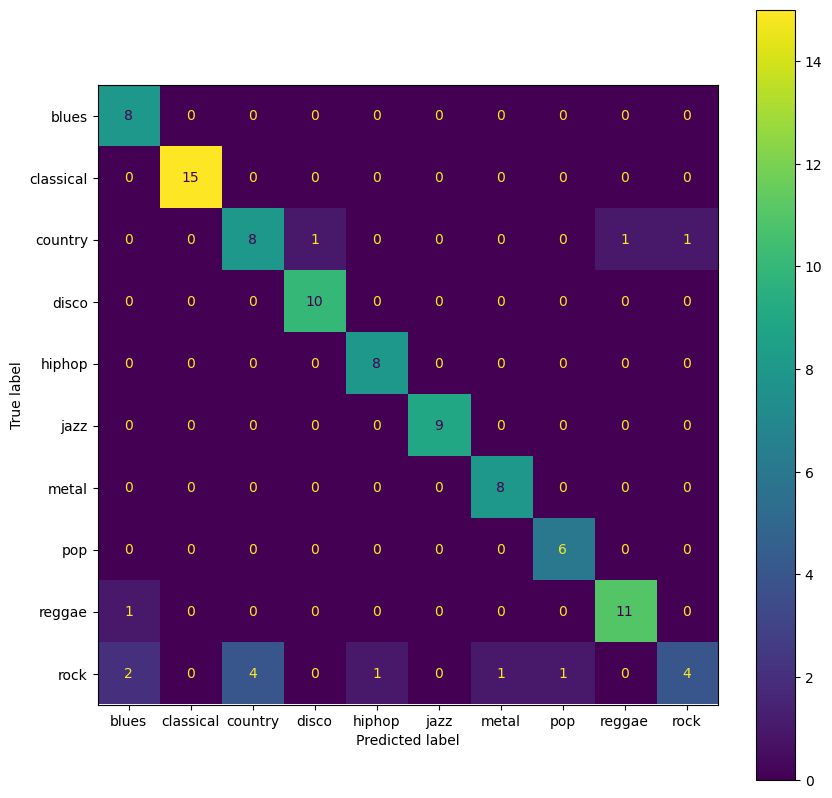

In [14]:
pred=trainer.predict(gtzan_encoded["test"].with_format("torch"))
print(pred.metrics)
confusion_matrix=metrics.confusion_matrix(pred.label_ids, np.argmax(pred.predictions, axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(label2id.keys()))
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
if not os.path.exists("images"):
  os.mkdir("images")
fig.savefig(os.path.join("images","Test_confusion_matrix.jpg"))
plt.show()